# Topic 28 - Microbes Classification - with duplicates

This documentation is the main one. In first part we will do analyse of data and then will do modelling for data with duplicates.

Our goal is to classify each type of microorganism correctly, that is a supervised task, - multiclass classification problem.

For modelling we chose the following 6 models:
1. KNeighborsClassifier.
2. LogisticRegression.
3. RandomForest.
4. GradientBoostingClassifier.
5. MLPClassifier.
6. SVC (C-Support Vector Classification).

## EDA

### Libraries and Data loading

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.rcParams['figure.dpi'] =  100
df = pd.read_csv('microbes.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

### Structure of the dataset

Now we take a look at overall dataset structure

In [2]:
print('features:\n', df.columns, end='\n\n')
print(df.head(3), end='\n\n')
print(f'number of rows: {df.shape[0]}\nnumber of columns: {df.shape[1]}', end='\n\n')

features:
 Index(['Solidity', 'Eccentricity', 'EquivDiameter', 'Extrema', 'FilledArea',
       'Extent', 'Orientation', 'EulerNumber', 'BoundingBox1', 'BoundingBox2',
       'BoundingBox3', 'BoundingBox4', 'ConvexHull1', 'ConvexHull2',
       'ConvexHull3', 'ConvexHull4', 'MajorAxisLength', 'MinorAxisLength',
       'Perimeter', 'ConvexArea', 'Centroid1', 'Centroid2', 'Area', 'raddi',
       'microorganisms'],
      dtype='object')

   Solidity  Eccentricity  EquivDiameter  Extrema  FilledArea  Extent  \
0     10.70          15.8           5.43     3.75       0.785    8.14   
1      5.60          18.3           4.14     6.16       0.364    3.51   
2      8.32          19.8           4.63     6.66       0.415    5.85   

   Orientation  EulerNumber  BoundingBox1  BoundingBox2  ...  ConvexHull4  \
0         2.15         22.3          2.97          10.9  ...         2.97   
1        18.60         22.5          5.41          19.2  ...         5.47   
2        21.00         22.4          5.

We can see that the dataset has **30527** samples and **24** features. Target will be the last column - classify each microorganism, that is a multiclass classification problem.

As we have enough samples we will use a validation set.

In [3]:
from sklearn.model_selection import train_test_split

features = df.drop(columns=['microorganisms'])
target = df['microorganisms']

x_train_val, x_test, y_train_val, y_test = train_test_split(features, target, train_size=0.8, stratify=target, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, train_size=0.8, stratify=y_train_val, random_state=42)


Lets now investigate what types given features have.  
As well as check if we have any missing/zero values.

In [4]:
print(x_train.info(), end='\n\n')
print(y_train.info(), end='\n\n')
print('missing values in features: ', (x_train.isna().any().any()))
print('missing values in target: ', (y_train.isna().any().any()))
print('zero values in features: ', (x_train==0.0).any().any())
print('zero values in target: ', (y_train==0.0).any().any())

<class 'pandas.core.frame.DataFrame'>
Index: 19536 entries, 21996 to 26274
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Solidity         19536 non-null  float64
 1   Eccentricity     19536 non-null  float64
 2   EquivDiameter    19536 non-null  float64
 3   Extrema          19536 non-null  float64
 4   FilledArea       19536 non-null  float64
 5   Extent           19536 non-null  float64
 6   Orientation      19536 non-null  float64
 7   EulerNumber      19536 non-null  float64
 8   BoundingBox1     19536 non-null  float64
 9   BoundingBox2     19536 non-null  float64
 10  BoundingBox3     19536 non-null  float64
 11  BoundingBox4     19536 non-null  float64
 12  ConvexHull1      19536 non-null  float64
 13  ConvexHull2      19536 non-null  float64
 14  ConvexHull3      19536 non-null  float64
 15  ConvexHull4      19536 non-null  float64
 16  MajorAxisLength  19536 non-null  float64
 17  MinorAxisLeng

As we can see the dataset does not have any missing points, however, it has zero values, which needs to be investigated further.

In [5]:
x_train.describe()

Solidity  Eccentricity  EquivDiameter       Extrema    FilledArea  \
count  19536.000000  19536.000000   19536.000000  19536.000000  19536.000000   
mean       9.684724     19.475353       3.627856     11.869358      0.417562   
std        4.051480      3.469683       2.214713      6.068893      0.871785   
min        0.000000      0.000000       0.000000      0.000000      0.000000   
25%        6.630000     17.300000       2.180000      6.760000      0.093700   
50%        9.360000     20.700000       3.370000     12.000000      0.228000   
75%       12.600000     22.200000       4.570000     17.200000      0.432000   
max       23.000000     23.000000      23.000000     23.000000     23.000000   

             Extent   Orientation   EulerNumber  BoundingBox1  BoundingBox2  \
count  19536.000000  19536.000000  19536.000000  19536.000000  19536.000000   
mean       5.847227     11.724373     22.381045     10.922155     10.369667   
std        3.240655      6.609031      0.972343      6.113965      5.792505   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.310000      5.910000     22.300000      5.690000      5.710000   
50%        5.270000     12.100000     22.600000     10.900000     10.000000   
75%        7.870000     17.200000     22.900000     15.800000     14.900000   
max       23.000000     23.000000     23.000000     23.000000     23.000000   

       ...   ConvexHull3   ConvexHull4  MajorAxisLength  MinorAxisLength  \
count  ...  19536.000000  19536.000000     19536.000000     19536.000000   
mean   ...     11.051122     11.026235         1.607533         1.015712   
std    ...      6.112046      6.110457         1.699920         1.268348   
min    ...      0.000000      0.000000         0.000000         0.000000   
25%    ...      5.760000      5.745000         0.635000         0.421000   
50%    ...     11.000000     11.000000         1.150000         0.743000   
75%    ...     15.900000     15.900000         2.050000         1.210000   
max    ...     23.000000     23.000000        23.000000        23.000000   

          Perimeter    ConvexArea     Centroid1     Centroid2          Area  \
count  19536.000000  19536.000000  19536.000000  19536.000000  19536.000000   
mean       0.829442      0.259997     11.753951     11.524800      0.801763   
std        1.173987      1.042430      6.048938      5.688628      1.180746   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.253000      0.035000      6.560000      7.100000      0.218000   
50%        0.512000      0.085200     12.000000     11.100000      0.510000   
75%        0.960000      0.196000     16.900000     16.100000      0.929000   
max       23.000000     23.000000     23.000000     23.000000     23.000000   

              raddi  
count  19536.000000  
mean       5.206181  
std        2.797916  
min        0.000000  
25%        3.010000  
50%        5.320000  
75%        7.050000  
max       23.000000  

[8 rows x 24 columns]

Each feature has a minimal value of 0.0 and maximal value of 23.0, that can indicate that some preprocessing of the data was already done. Unfortunately we were not able to find any additional information about preprocessing, performed on our data set.

In [6]:
print('number of zero values overall: ', (x_train == 0.0).any(axis=1).sum())

number of zero values overall:  166


As 158 samples is not big quantity, comparing to the number of samples in data set, and as from description of the data set we don't know what kind of preprocessing was done, we decide to keep rows, containing zeros.

### Feature exploration

The process of manual identification of algae in water bodies is tedious and laborious, and highly dependent on experts. To collect the information about agiles, firstly water samples were collected, then with the use of a microscope were prepared images of agiles.

The image processing consists of two steps. In this first step the gray scale images of the microbes are subjected to the pixel clustering. This removes unwanted pixels from the image. In this second step, boundaries of the microbes are extracted.

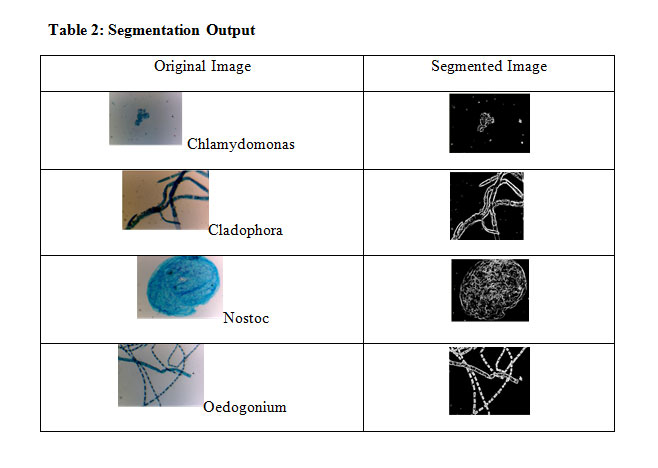

The images are then subjected to morphological /shape feature extraction process to build the automated process of identification.

1.	Solidity: It is the ratio of area of an object to the area of a convex hull of the object. Computed as Area/ConvexArea.
2.	Eccentricity: The eccentricity is the ratio of length of major to minor axis of an object. Can help to measure the roundness of the algae object, which again gives indication about the morphology of objects.
3.	EquivDiameter: Diameter of a circle with the same area as the region.
4.	Extrema: Point, where the value of a number is the largest or smallest in computational space.
5.	Filled Area: Number of on pixels in FilledImage, returned as a scalar.
6.	Extent: Ratio of the pixel area of a region with respect to the bounding box area of an object.  
7.	Orientation: The overall direction of the shape (tan angle).
8.	Euler number: Value that can be obtained after the subtraction of a number of holes in an image from the total objects in an image.
9.	Bounding box: Position and size of the smallest box (rectangle) which bounds the object.
10.	Convex hull: Smallest convex shape/polygon that contains the object. Gives triangulated information about the shape, size, and volume of the algae.
11.	Major axis: The major axis is the endpoints of the longest line that can be drawn through the object. Length (in pixels) of the major axis is the largest dimension of the object. We obtain MajorAxisLength in out data set.
12.	Minor axis: The axis perpendicular to the major axis is called the minor axis. Length (in pixels) of the minor axis is the smallest line connecting a pair of points on the contour. We obtain MinorAxisLength in out data set.
13.	Perimeter: Number of pixels around the border of the region.
14.	Centroid: Centre of mass of the region. It is a measure of object’s location in the image.
15.	Area: Total number of pixels in a region/shape.
16. Radii: Radius length.

Features such as area (filled and convex), bounding box, perimeter and centroid can give an idea about the shape, size of the microorganism as well as the position of the object in the vector space model.

The values of minor and major axes and orientation (tan angle) gives information about the direction and inclination in which the object geometrically is. 

### Duplicates

We need to see if we have any duplicates in samples.

In [7]:
print(x_train.join(y_train).duplicated().value_counts(), end='\n\n')

True     14875
False     4661
Name: count, dtype: int64



This shows that we have only 4661 original data points, everything else are duplicates. To work with duplicates correctly, we need to delete them from initial data set and only then separate into test, validation and test sets. Then establish and train separate models for sets without duplicates. Due to time issue we will do it correctly later. For now we will ignore duplicates and work with previously separated data.

### Distribution of classes

Lets investigate given classes in a more precise manner.

number of classes:  10


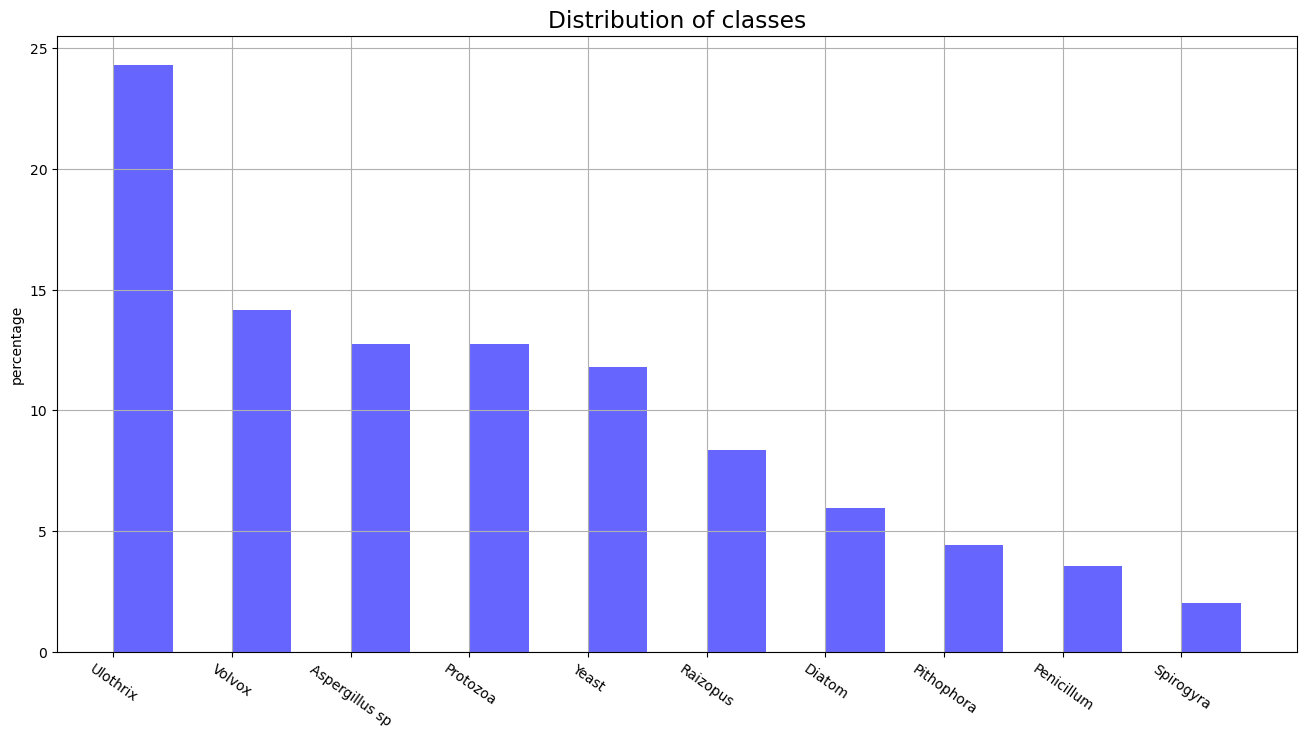

In [8]:
class_distribution = y_train.value_counts(normalize=True)*100

print('number of classes: ', len(class_distribution))

fig, ax = plt.subplots(figsize=(16, 8))
plt.rcParams.update({'font.size': 14})
indices = np.arange(0,10,1)

bar_width = 0.5
bars = ax.bar(indices, class_distribution, bar_width, color='blue', alpha=0.6)

ax.set_ylabel('percentage')
ax.set_xticks(indices - bar_width / 2)
ax.set_xticklabels(class_distribution.index)

plt.title('Distribution of classes')
plt.xticks(rotation= -35)
plt.grid()


In [9]:
y_train.value_counts()

microorganisms
Ulothrix          4749
Volvox            2765
Aspergillus sp    2488
Protozoa          2488
Yeast             2304
Raizopus          1633
Diatom            1163
Pithophora         864
Penicillum         691
Spirogyra          391
Name: count, dtype: int64

We can observe that dataset is **highly** imbalanced, that is the reason to use stratify method in train_test_split.

### Boxplots and outliers

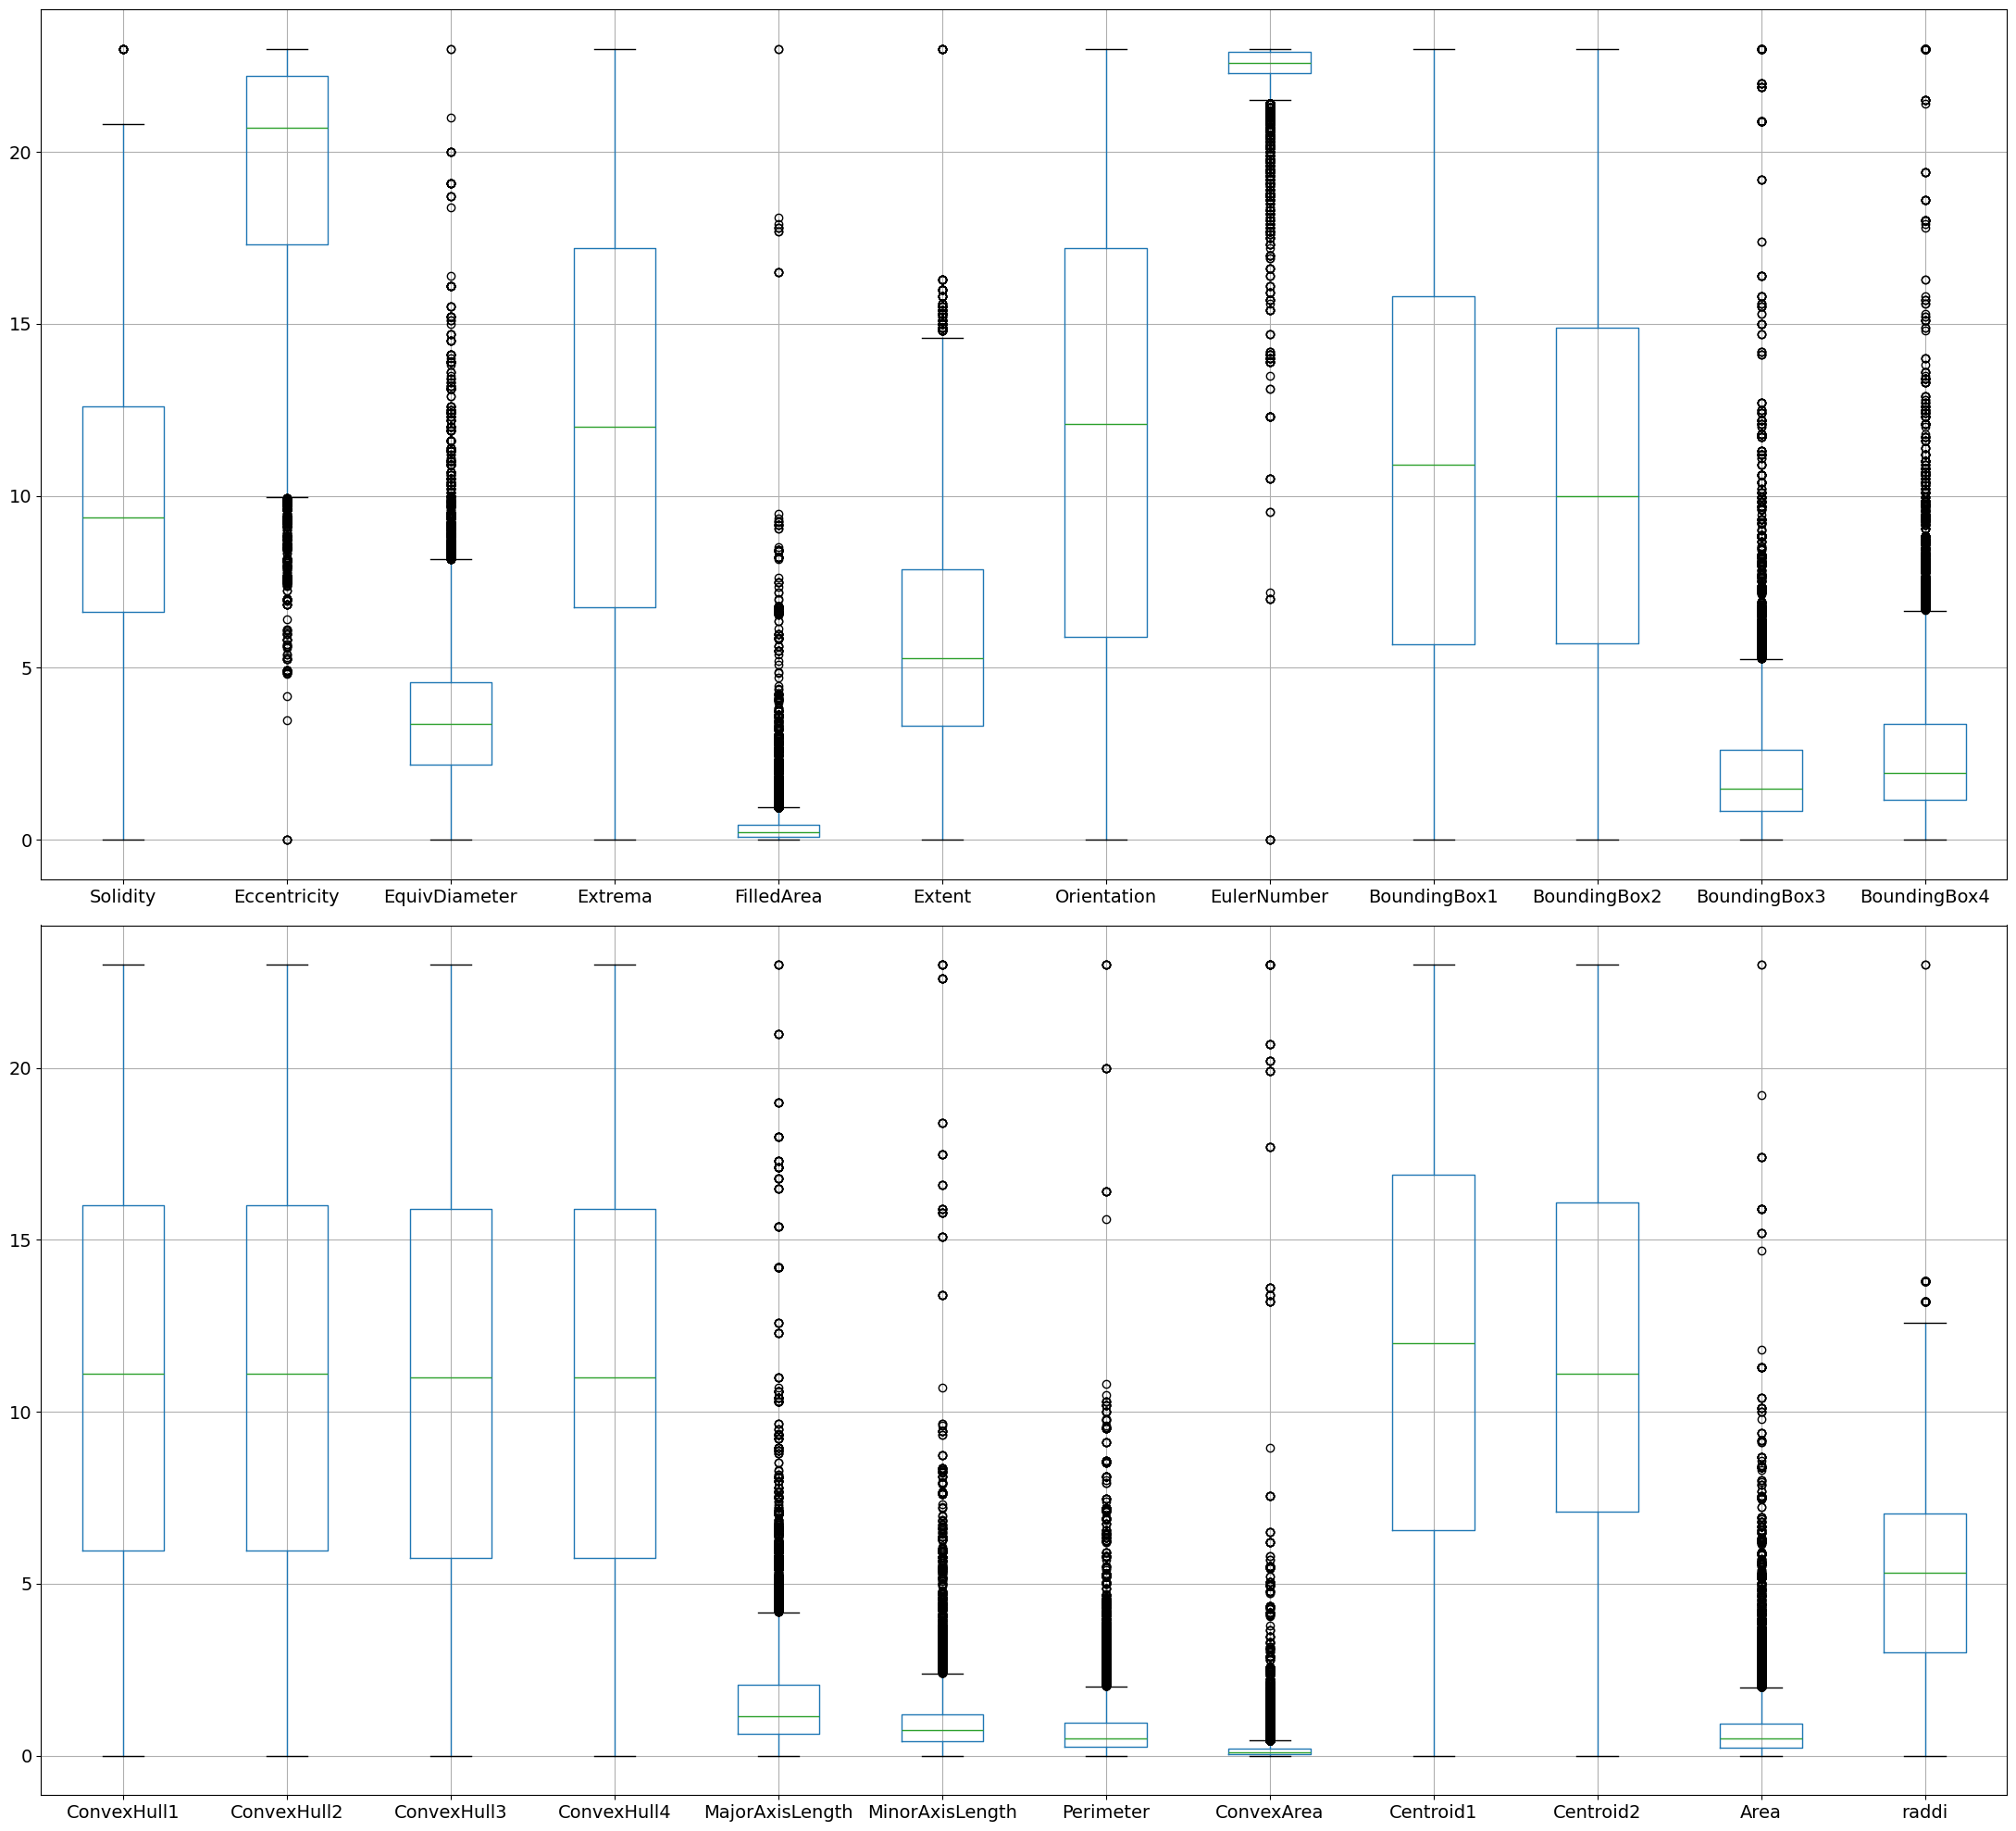

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 20))
x_train.boxplot(ax=ax1, column=list(x_train.columns)[:12], fontsize=14)
x_train.boxplot(ax=ax2, column=list(x_train.columns)[12:], fontsize=14)
plt.tight_layout()

From the boxplots above we can clearly see that the dataset contains a lot of extreme outliers. There are different ways to calculate outliers, namely using quantiles and standard deviation.

Firstly we calculate number of outliers using quantiles.

In [11]:
q25 = x_train.quantile(q=0.25)
q50 = x_train.quantile(q=0.50)
q75 = x_train.quantile(q=0.75)
iqr = q75 - q25
lower_bound = q25 - 1.5 * iqr
upper_bound = q75 + 1.5 * iqr

In [12]:
iqr_outliers = x_train[(x_train < lower_bound) | (x_train > upper_bound)].any(axis=1)

print('Number of outliers using IQR:', iqr_outliers.sum().max())

Number of outliers using IQR: 3597


Secondly we find outliers using standard deviation.

In [13]:
std = x_train.std(axis=0)
mean = x_train.mean(axis=0)
outliers = (abs(x_train - mean) > (3 * std))

print('Number of outliers using std:', outliers.sum().max())

Number of outliers using std: 368


We see that the number of outliers, calculated using IQR is 10 times bigger, using std. Then we will work with outliers using different transformers (s.t. StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer) and comparing there influence on models.

### Distribution of features

Next we will use histograms to determine feature's distributions.

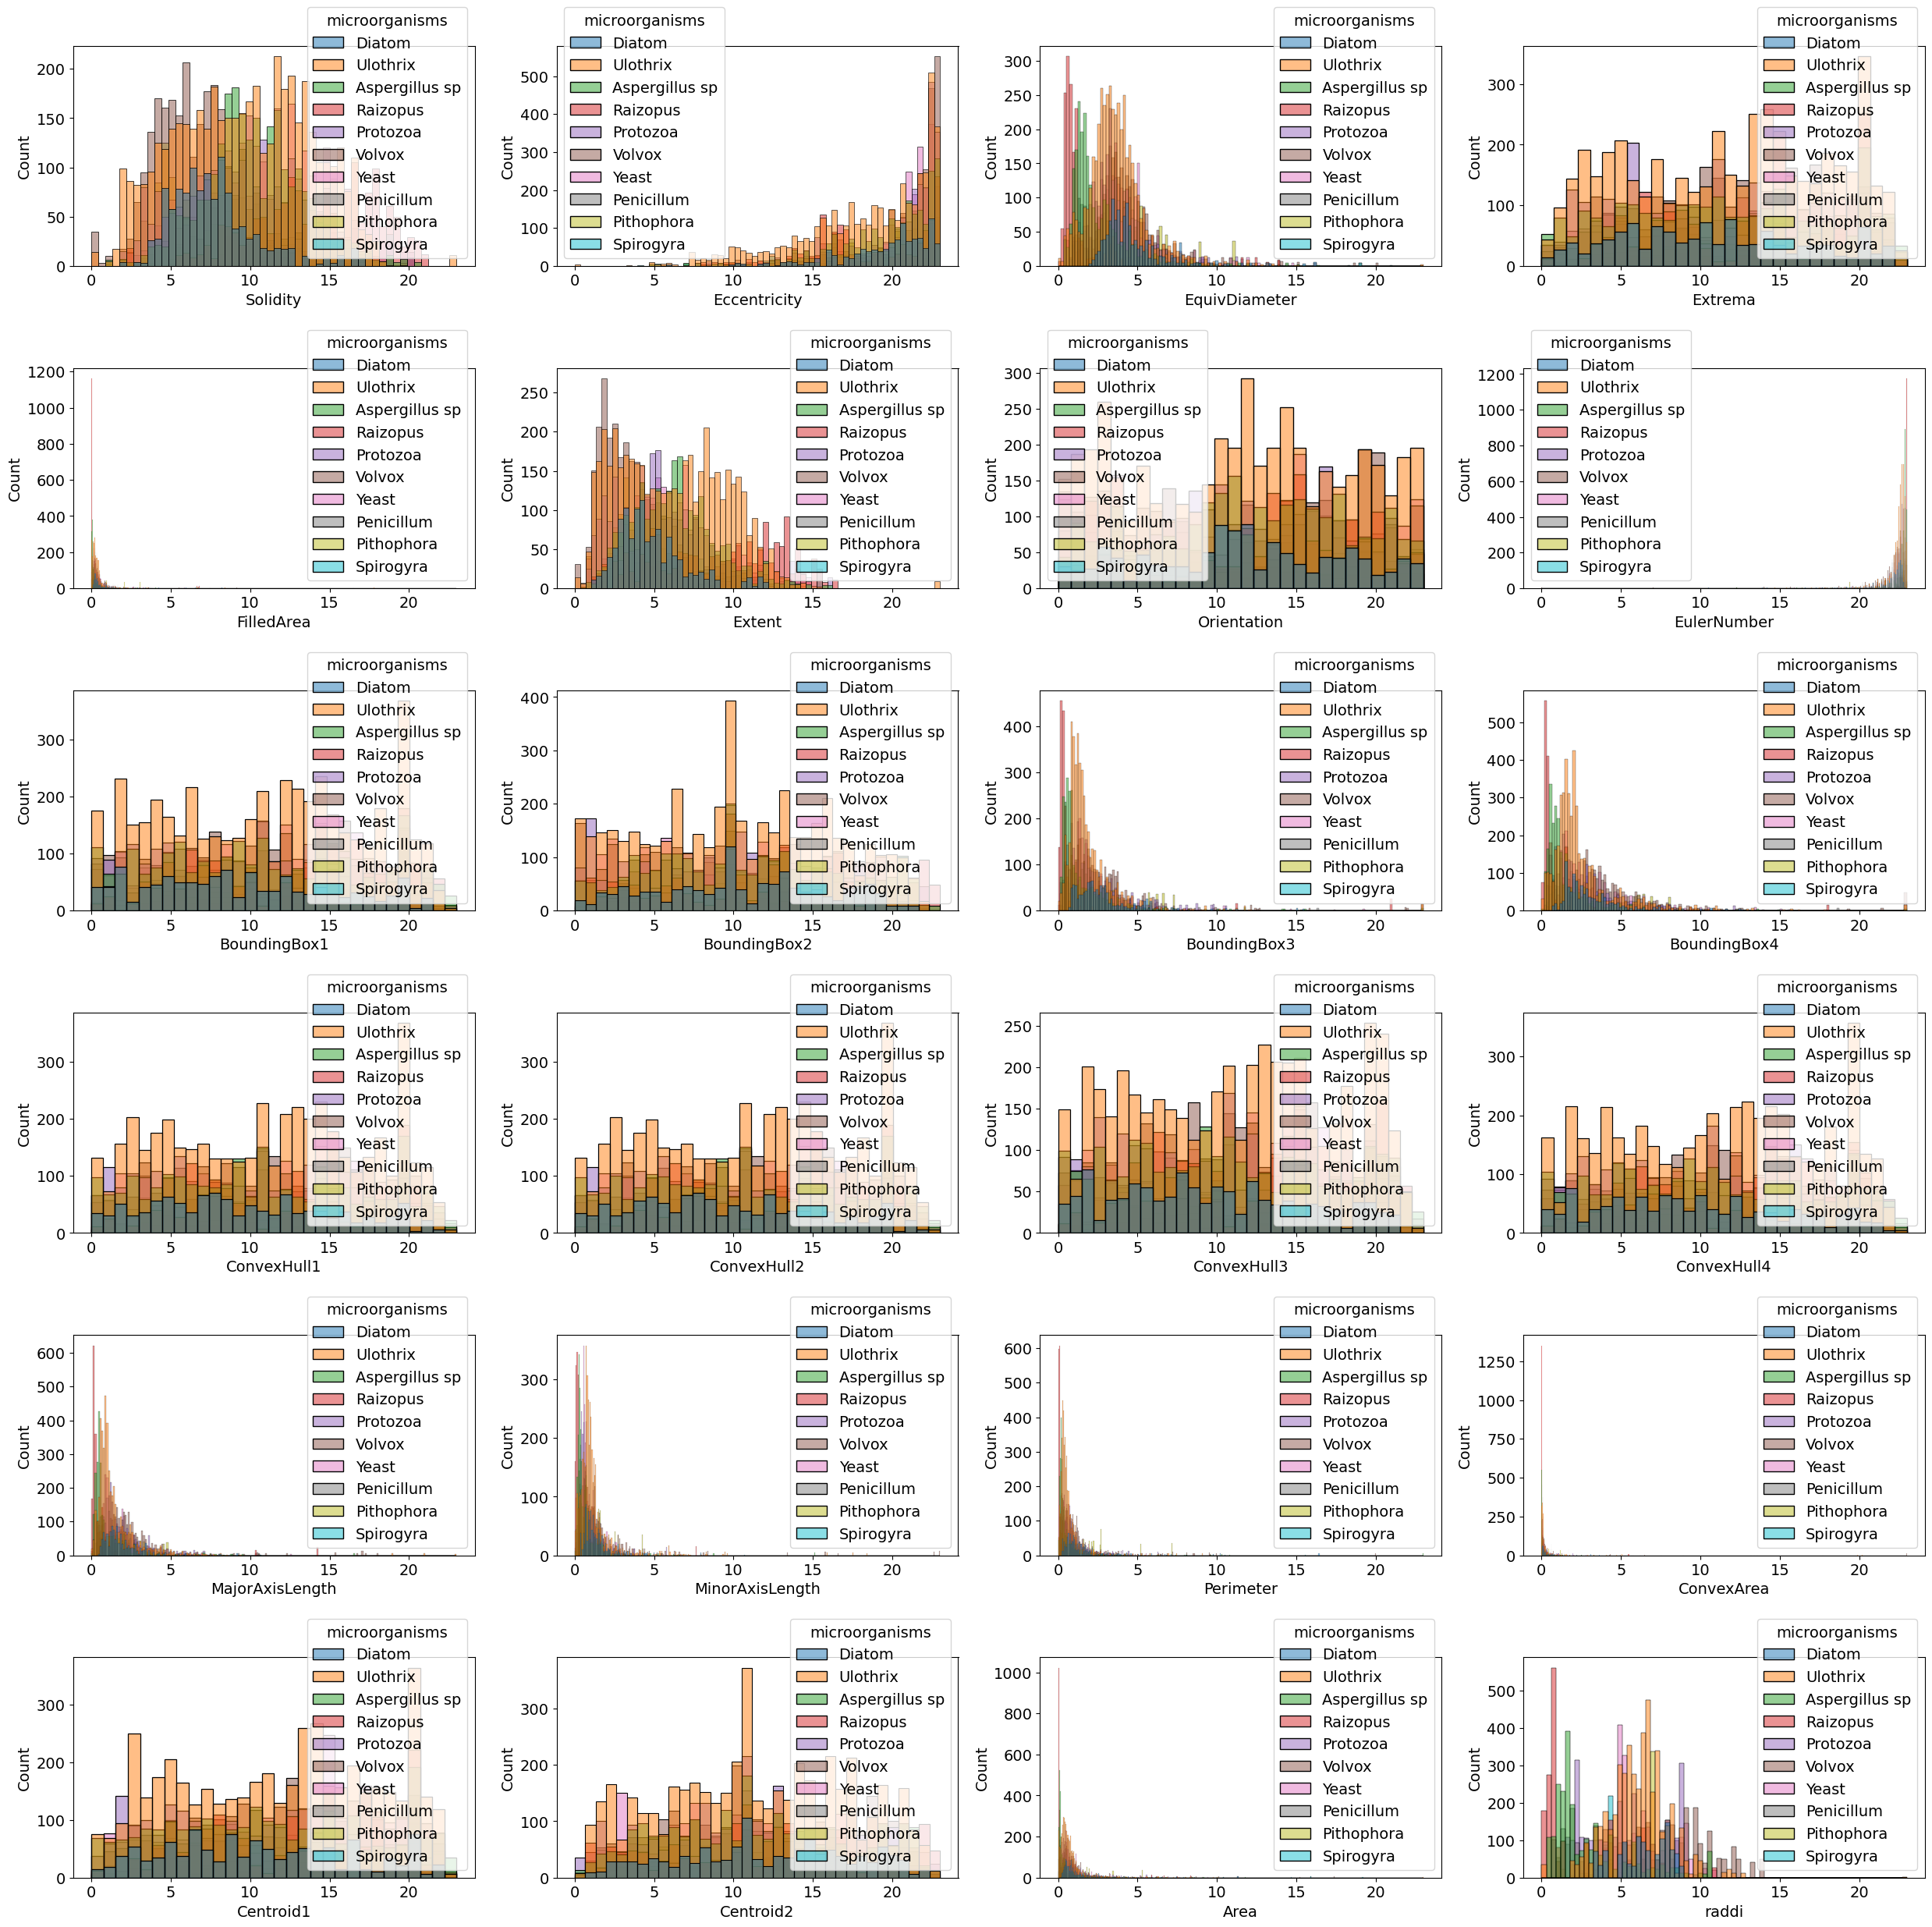

In [14]:
train_df = x_train.join(y_train)
fig, ax = plt.subplots(6, 4, figsize=(25, 25))

for name, a in zip(train_df.columns[:-1], ax.ravel()):
  sns.histplot(data=train_df, x=name, hue="microorganisms", ax=a)

plt.tight_layout()
plt.show()

We notice that the distribution of features is rarely standard, as well, some parameters take significantly smaller values, then others.

### Corellation matrix

<Axes: >

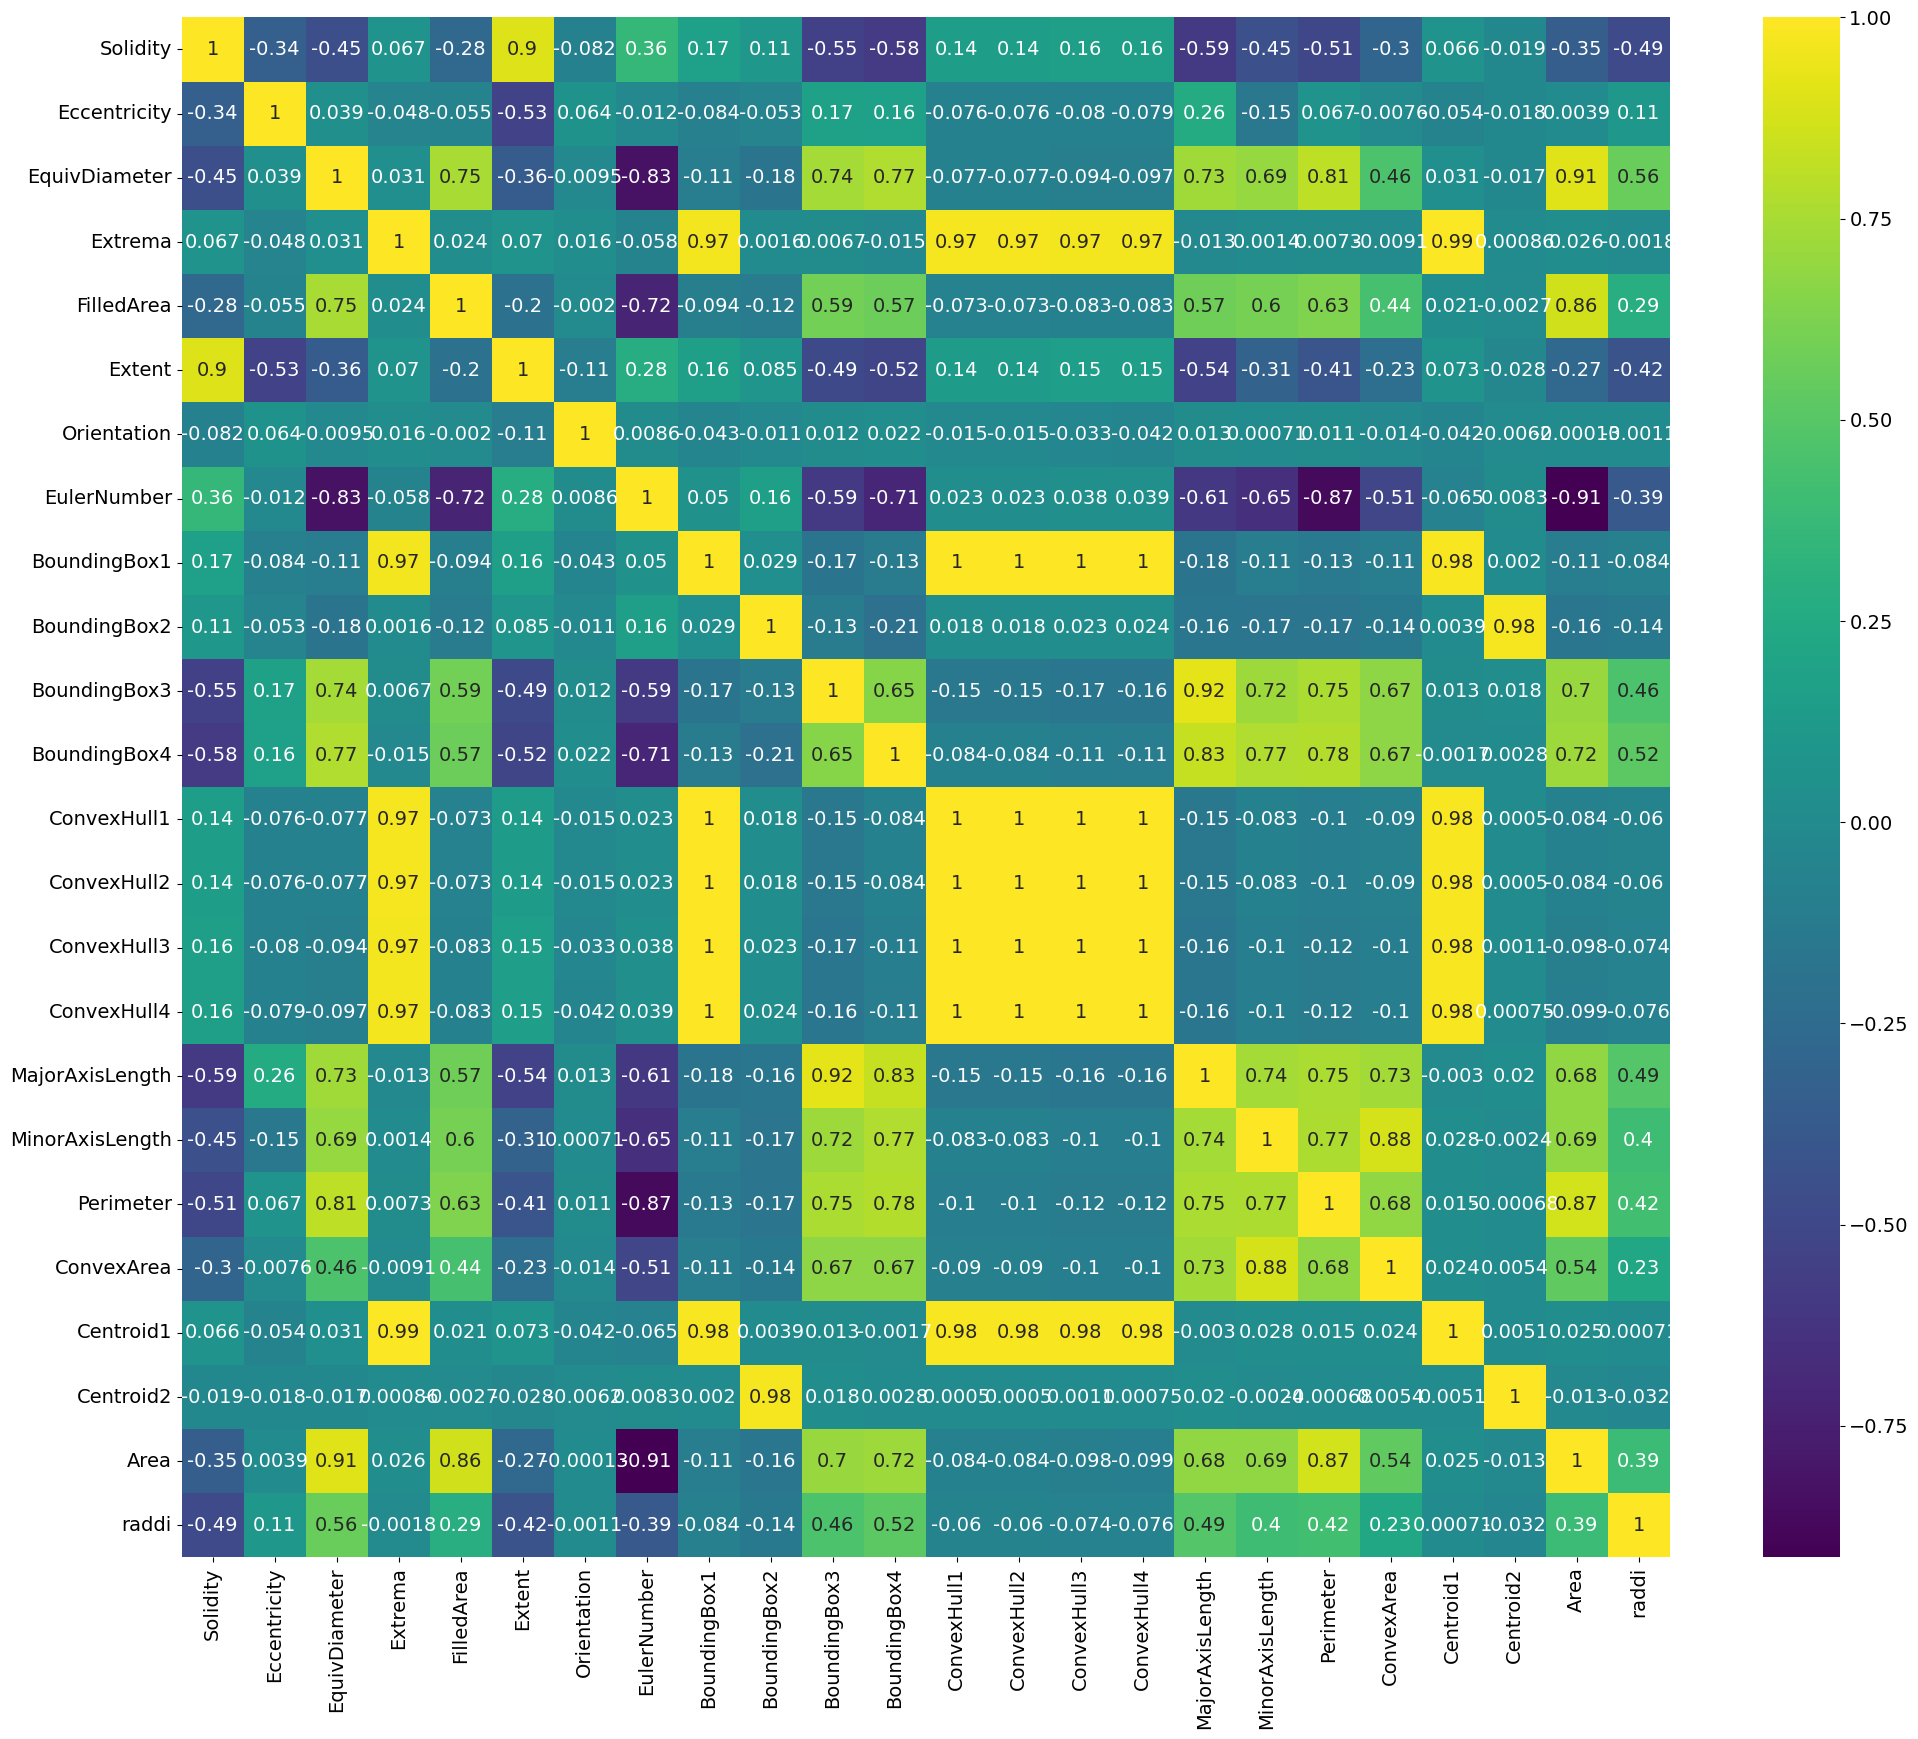

In [15]:
matrix = x_train.corr()
plt.figure(figsize=(24,20))
sns.heatmap(matrix, cmap="viridis", annot=True)

Having correlation coef equal to 1 and approximately equal to 1 is suspicuos, so we will look at these columns closer.

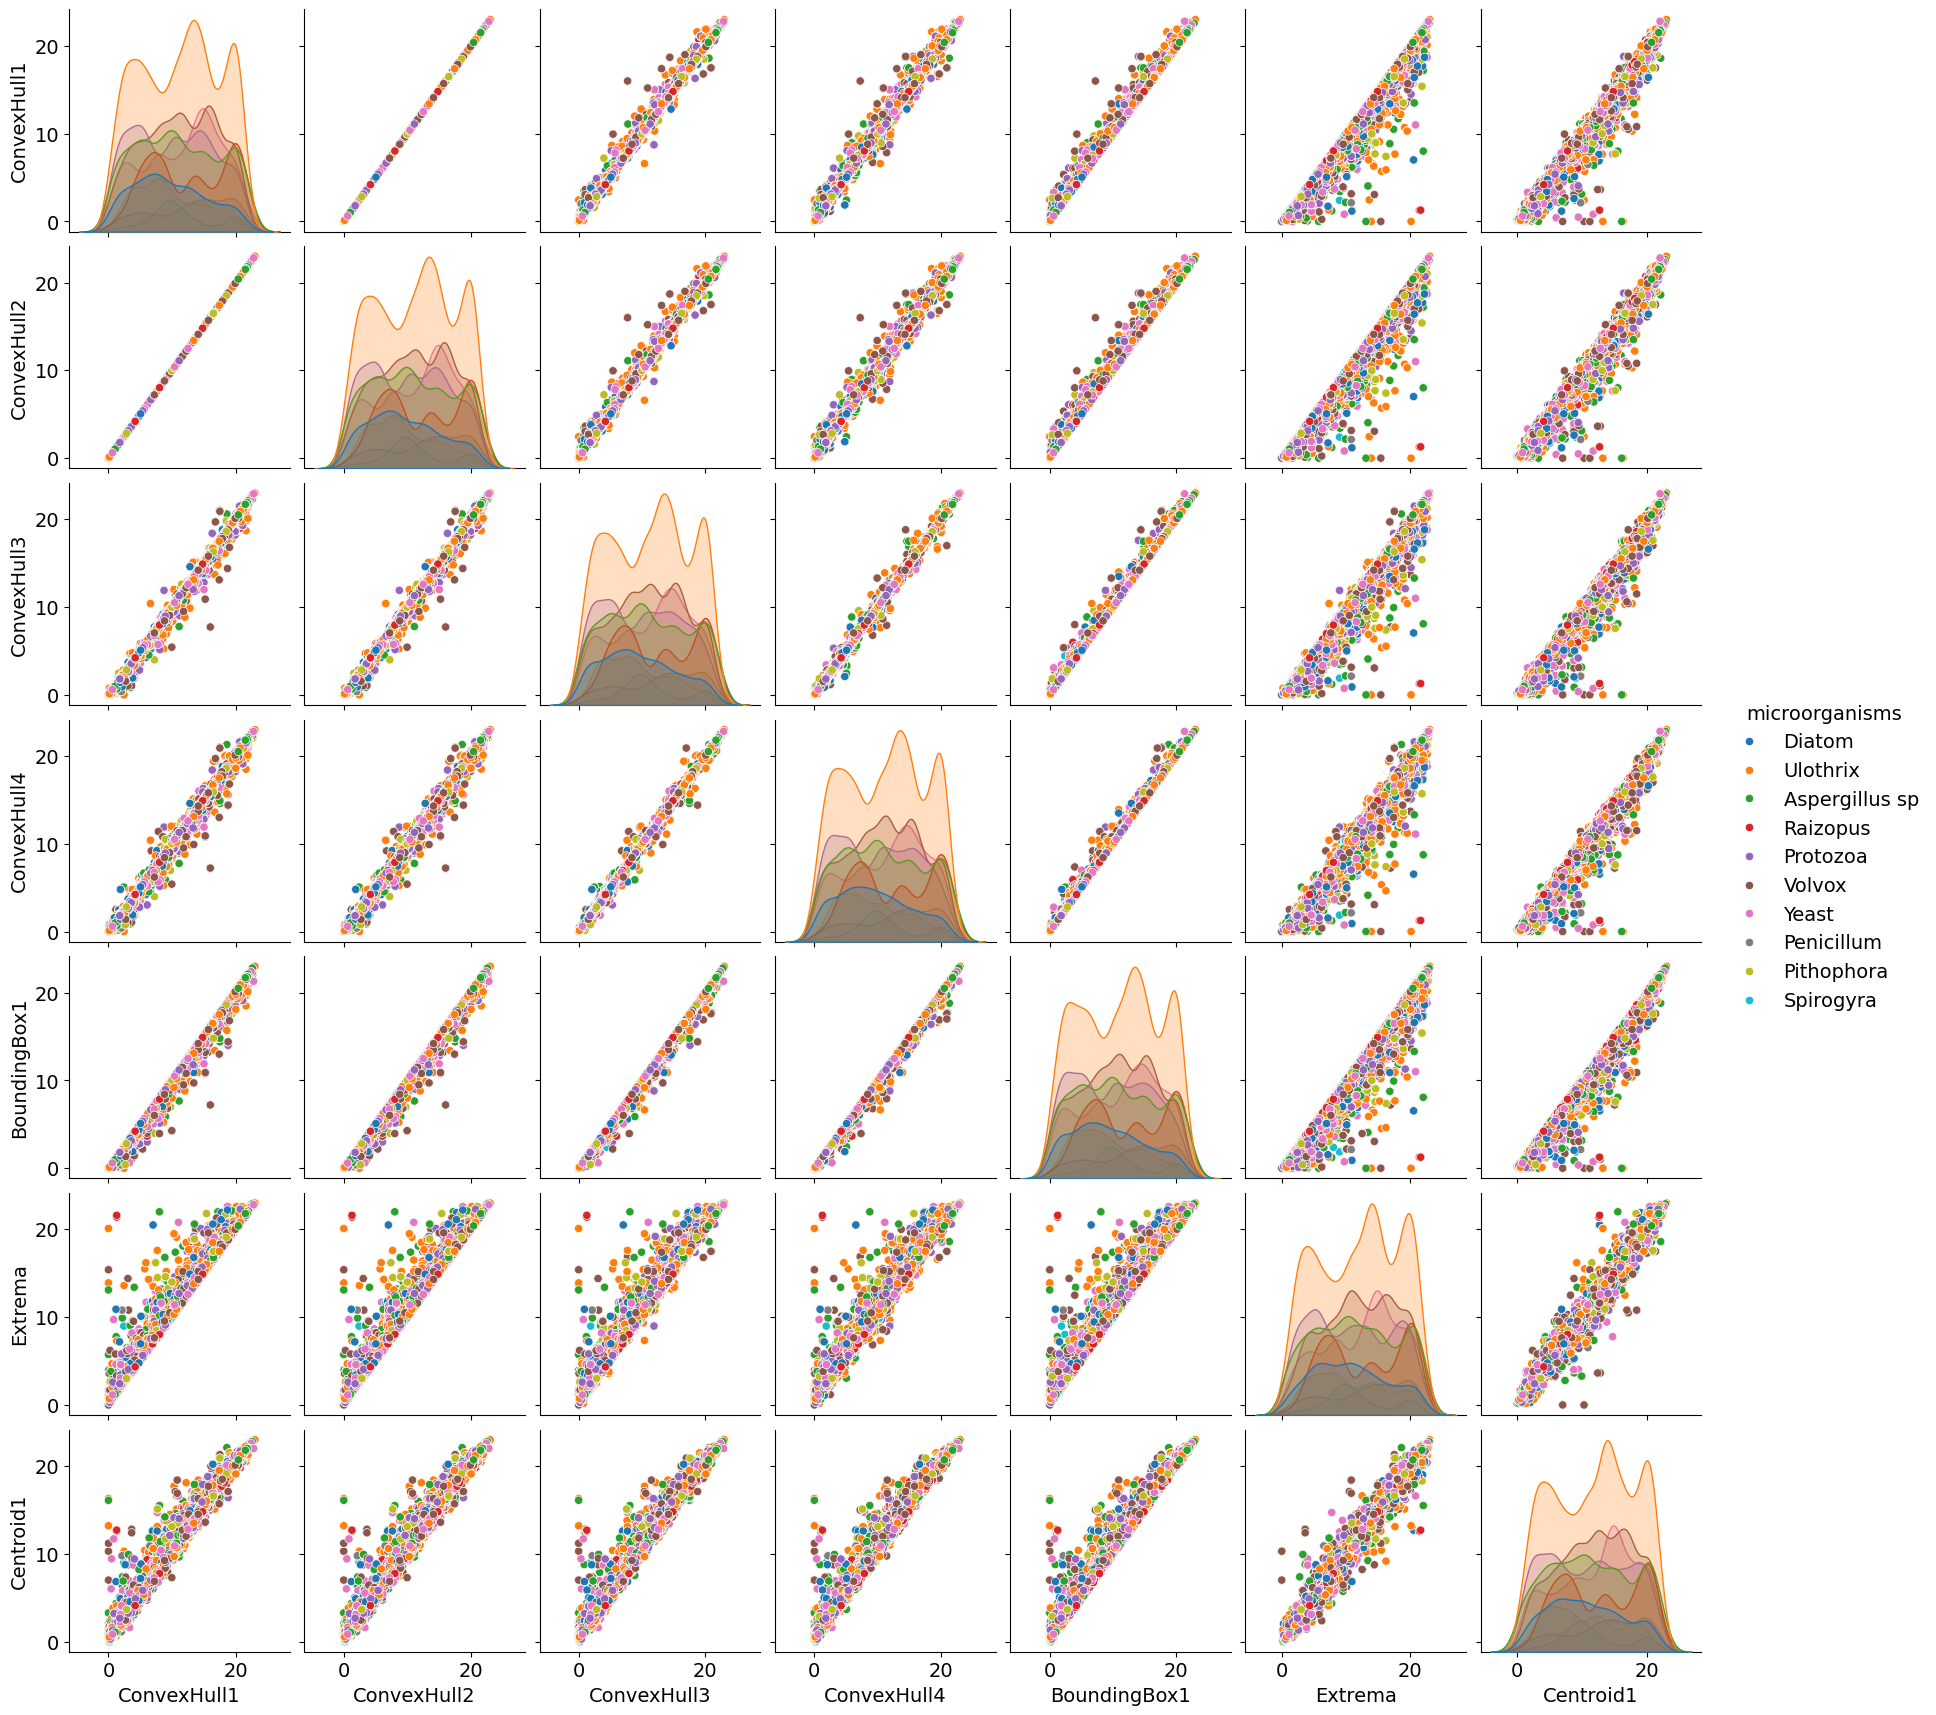

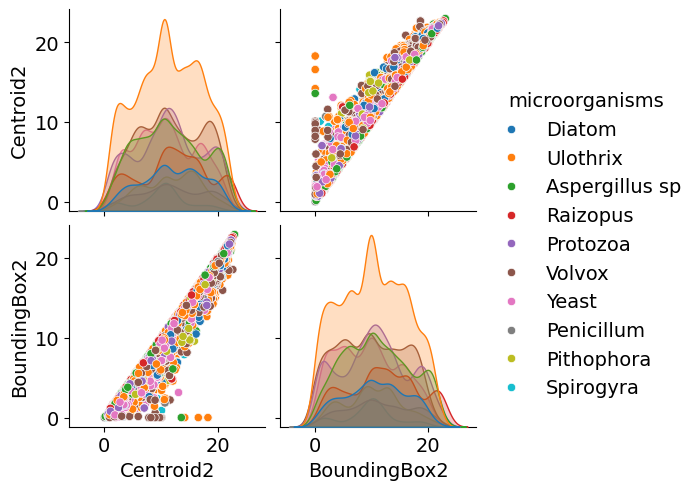

In [16]:
sns.pairplot(
        data=train_df, 
        vars=train_df[['ConvexHull1', 'ConvexHull2', 'ConvexHull3', 'ConvexHull4', 'BoundingBox1', 'Extrema', 'Centroid1']],
        hue='microorganisms',
        )
plt.show()
sns.pairplot(
        data=train_df, 
        vars=train_df[['Centroid2', 'BoundingBox2', ]],
        hue='microorganisms',
        )
plt.show()

The linear dependence for all selected features is obvious, but the most strange dependence is between ConvexHull1 and ConvexHull2, so we want to compare these columns.

In [17]:
convex_hull_array = np.array(df[['ConvexHull1', 'ConvexHull2']])
print(np.sum(np.diff(convex_hull_array)))

0.0


As the difference between the entries of the ConvexHull1 and ConvexHull2 is equal to 0, we conclude that ConvexHull1=ConvexHull2 and delete this feature from all data sets.

In [18]:
x_train.drop(columns='ConvexHull2', inplace=True)
x_val.drop(columns='ConvexHull2', inplace=True)
x_test.drop(columns='ConvexHull2', inplace=True)

train_df.drop(columns='ConvexHull2', inplace=True)

We will keep other features despite the fact there exists a linear correlation between them. As our problem is classification, not regression (if we would like to determine value of some params), this correlation chouldn't influence our classification.

### Conclusion of EDA

We acknowledge the following problems:
1. The data set is highly imbalanced with the smallest class containing roughly 2% of data. However despite this fact we don't want to simplify the problem to binary classification or to classification of 2-3 biggest classes and will stick to multiclass classification of all given classes.
2. The data set contains outliers and is not standardised. For some classifiers (for example KNN or Logistic Regression) it is crucial for features to be in a specific range. Thus, we will use different transformers to shift and scale each feature in a suitable way.
3. The data set contains a huge amount of duplicates. However deleting them influences the distribution of the data among classes, so we don't decide to delete duplicates in advance and will study the behaviour of models with/without duplicates.
   
Model performance evaluation:  

As it states in the dataset description, the correct classification of given microorganism is crucial. Thus we assume that all classes have the same worth. Therefore, the most valuable metric for model evaluation shall be **Recall**, however, to gain a full picture of model performance we will also use **Cohen's Kappa** as it fits good with the imbalanced classification. We prefer to use **Macro Recall** as for us every class is important, despite it's weight. It is also worth using confusion matrix to gain additional information of model performance.

As data contains outliers and features take different range of values we want to use different transformers. 
According to userguide (https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) we would like to compare the following transformers:
1. StandardScaler. According to userguide cannot guarantee balanced feature scales in the presence of outliers. We want to use it to compare what is 'good'/'bad' result for our data set.
2. RobustScaler. The centering and scaling statistics of RobustScaler are based on percentiles and are therefore not influenced by a small number of very large marginal outliers.
3. PowerTransformer. Applies a power transformation to each feature to make the data more Gaussian-like in order to stabilize variance and minimize skewness. The optimal scaling factor is determined via maximum likelihood estimation. Has 2 variations: Yeo-Johnson and Box-Cox. Box-Cox can only be applied to strictly positive data, that is not suitable for our case because of 0 values. So we will apply Yeo-Johnson method.
4. QuantileTransformer (uniform output). Applies a non-linear transformation such that the probability density function of each feature will be mapped to a uniform or Gaussian distribution. All the data, including outliers, will be mapped to a uniform distribution with the range [0, 1], making outliers indistinguishable from inliers.

## Modelling

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import LearningCurveDisplay, StratifiedKFold, GridSearchCV, RandomizedSearchCV, PredefinedSplit, cross_validate, cross_val_predict, learning_curve, validation_curve, ValidationCurveDisplay
from sklearn.metrics import recall_score, f1_score, log_loss, cohen_kappa_score, accuracy_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, Normalizer, PolynomialFeatures, label_binarize

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


Initialize scoring parameters for GridSearchCV and RandomizedSearchCV.

In [20]:
def cohen_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

scoring = {
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro',
    'cohen_kappa': make_scorer(cohen_kappa),
    'accuracy': 'accuracy'
}

In this section we will try each models with default parameters and then will tune them.

### kNeighborsClassifier

For better comparison of results we will save them into a dataframe. 

In [21]:
columns = [
    'Scaler',
    'Sampler',
    'Weights',
    'Number of neighbors',
    'Macro recall train',
    'Macro recall validation',
    'Macro f1 validation',
    'Cohens Kappa validation',
    'Accuracy validation',
    ]
kNN_scores = pd.DataFrame(columns=columns)

Default model:

In [22]:
neigh = KNeighborsClassifier(
    n_neighbors=5, #default parameter
    n_jobs=-1
    ) 
neigh.fit(x_train, y_train)
predictions = neigh.predict(x_val)

new_row = {
    'Scaler': None,
    'Sampler': None,
    'Weights': 'uniform',
    'Number of neighbors': 5,
    'Macro recall train': recall_score(y_train, neigh.predict(x_train), average='macro'),
    'Macro recall validation': recall_score(y_val, predictions, average='macro'),
    'Macro f1 validation': f1_score(y_val, predictions, average='macro'),
    'Cohens Kappa validation': cohen_kappa_score(y_val, predictions),
    'Accuracy validation': neigh.score(x_val, y_val),
}
kNN_scores = pd.concat([kNN_scores, pd.DataFrame([new_row])], ignore_index=True)
display(kNN_scores)

C:\Users\user\AppData\Local\Temp\ipykernel_14612\420319063.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kNN_scores = pd.concat([kNN_scores, pd.DataFrame([new_row])], ignore_index=True)


Scaler Sampler  Weights Number of neighbors  Macro recall train  \
0   None    None  uniform                   5            0.920809   

   Macro recall validation  Macro f1 validation  Cohens Kappa validation  \
0                  0.87972             0.881305                 0.881878   

   Accuracy validation  
0              0.89826

We try a few data transformers to see if data transformation impacts on model performance.
For data transformers we chosed:
1. StandardScaler.
2. RobustScaler.
3. QuantileTransformer.
4. PowerTransformer.


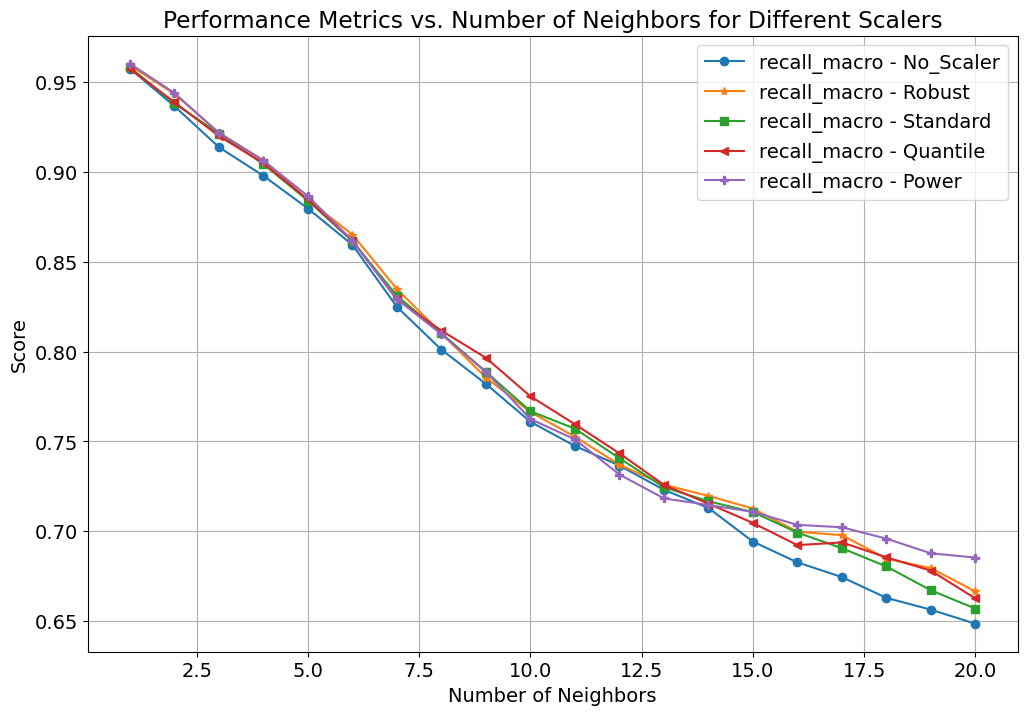

In [23]:
k_values = range(1, 21)

metrics = {
    'No_Scaler': {'recall_macro': [], },
    'Robust': {'recall_macro': [], },
    'Standard': {'recall_macro': [], },
    'Quantile': {'recall_macro': [], },
    'Power': {'recall_macro': [], },
}

for k in k_values:
    kNN = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    kNN.fit(x_train, y_train)
    y_pred = kNN.predict(x_val)
    
    metrics['No_Scaler']['recall_macro'].append(recall_score(y_val, y_pred, average='macro'))


transformers = [
    ('Robust', RobustScaler()),
    ('Standard', StandardScaler()),
    ('Quantile', QuantileTransformer()),
    ('Power', PowerTransformer()),
]

for transformer_name, transformer_obj in transformers:
    for k in k_values:
        pipe = Pipeline([
            ('scaler', transformer_obj),
            ('knn', KNeighborsClassifier(n_neighbors=k, n_jobs=-1))
        ])
        pipe.fit(x_train, y_train)
        y_pred = pipe.predict(x_val)
        
        metrics[transformer_name]['recall_macro'].append(recall_score(y_val, y_pred, average='macro'))


plt.figure(figsize=(12, 8))
markers = {'No_Scaler': 'o', 'Robust': '*', 'Standard': 's', 'Quantile': '<', 'Power': 'P'}

for scaler_name in metrics:
    for metric_name in metrics[scaler_name]:
        plt.plot(k_values, metrics[scaler_name][metric_name], marker=markers[scaler_name], label=f'{metric_name} - {scaler_name}')

plt.title('Performance Metrics vs. Number of Neighbors for Different Scalers')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.show()


We observe that scalers do not do significant difference, but on long term run PowerTransformer shows the best result.

In [24]:
pipe = Pipeline([
    ('power', PowerTransformer()),
    ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
])
pipe.fit(x_train, y_train)

new_row = {
    'Scaler': 'PowerTransformer',
    'Sampler': None,
    'Weights': 'uniform',
    'Number of neighbors': 5,
    'Macro recall train': recall_score(y_train, pipe.predict(x_train), average='macro'),
    'Macro recall validation': recall_score(y_val, pipe.predict(x_val), average='macro'),
    'Macro f1 validation': f1_score(y_val, pipe.predict(x_val), average='macro'),
    'Cohens Kappa validation': cohen_kappa_score(y_val, pipe.predict(x_val)),
    'Accuracy validation': pipe.score(x_val, y_val),
}
kNN_scores = pd.concat([kNN_scores, pd.DataFrame([new_row])], ignore_index=True)
display(kNN_scores)

Scaler Sampler  Weights Number of neighbors  Macro recall train  \
0              None    None  uniform                   5            0.920809   
1  PowerTransformer    None  uniform                   5            0.926347   

   Macro recall validation  Macro f1 validation  Cohens Kappa validation  \
0                 0.879720             0.881305                 0.881878   
1                 0.886645             0.885706                 0.886696   

   Accuracy validation  
0             0.898260  
1             0.902354

Next we try different samplers to work with imbalance.

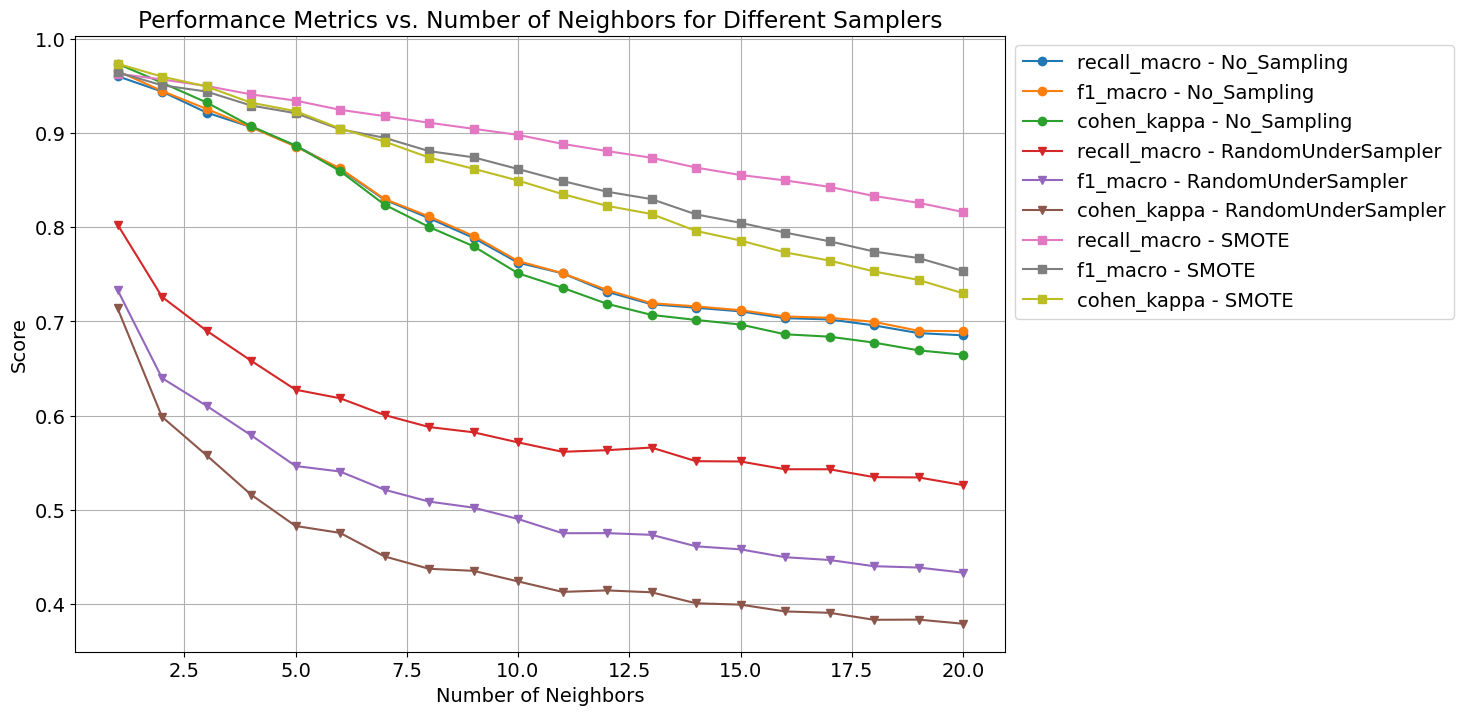

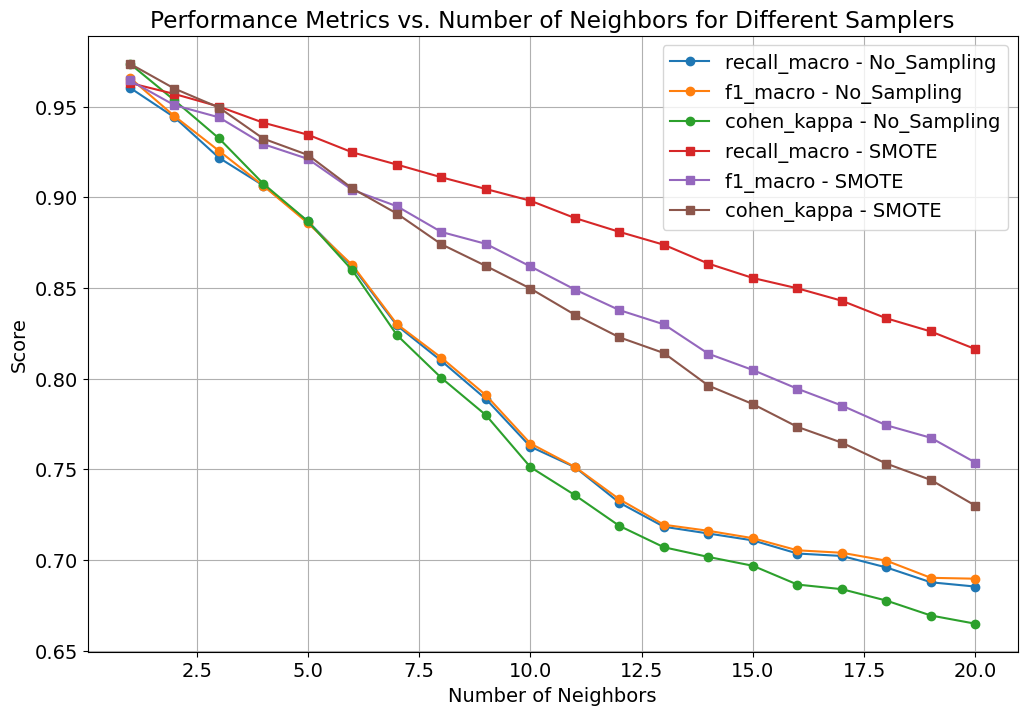

In [25]:
k_values = range(1, 21)

metrics = {
    'No_Sampling': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
    'RandomUnderSampler': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
    'SMOTE': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
}

for k in k_values:
    pipe_no_sampling = ImbPipeline([
        ('power', PowerTransformer()),
        ('knn', KNeighborsClassifier(n_neighbors=k, n_jobs=-1))
    ])
    pipe_no_sampling.fit(x_train, y_train)
    y_pred = pipe_no_sampling.predict(x_val)
    
    metrics['No_Sampling']['recall_macro'].append(recall_score(y_val, y_pred, average='macro'))
    metrics['No_Sampling']['f1_macro'].append(f1_score(y_val, y_pred, average='macro'))
    metrics['No_Sampling']['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))

samplers = [
    ('RandomUnderSampler', RandomUnderSampler(random_state=42)),
    ('SMOTE', SMOTE(random_state=42)),
]

for sampler_name, sampler_obj in samplers:
    for k in k_values:
        pipe_with_sampling = ImbPipeline([
            ('power', PowerTransformer()),
            ('sampler', sampler_obj),
            ('knn', KNeighborsClassifier(n_neighbors=k, n_jobs=-1))
        ])
        pipe_with_sampling.fit(x_train, y_train)
        y_pred = pipe_with_sampling.predict(x_val)

        metrics[sampler_name]['recall_macro'].append(recall_score(y_val, y_pred, average='macro'))
        metrics[sampler_name]['f1_macro'].append(f1_score(y_val, y_pred, average='macro'))
        metrics[sampler_name]['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))

plt.figure(figsize=(12, 8))
markers = {'No_Sampling': 'o', 'RandomUnderSampler': 'v', 'SMOTE':'s'}

for sampler_name in metrics:
    for metric_name in metrics[sampler_name]:
        plt.plot(k_values, metrics[sampler_name][metric_name], marker=markers[sampler_name], label=f'{metric_name} - {sampler_name}')

plt.title('Performance Metrics vs. Number of Neighbors for Different Samplers')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))

for sampler_name in metrics:
    if sampler_name == 'RandomUnderSampler':
        continue
    for metric_name in metrics[sampler_name]:
        plt.plot(k_values, metrics[sampler_name][metric_name], marker=markers[sampler_name], label=f'{metric_name} - {sampler_name}')

plt.title('Performance Metrics vs. Number of Neighbors for Different Samplers')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


We observe that RandomUnderSampler gives the worse results and SMOTE the best one.

In [26]:
pipe = ImbPipeline([
    ('power', PowerTransformer()),
    ('SMOTE', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
])
pipe.fit(x_train, y_train)

new_row = {
    'Scaler': 'PowerTransformer',
    'Sampler': 'SMOTE',
    'Weights': 'uniform',
    'Number of neighbors': 5,
    'Macro recall train': recall_score(y_train, pipe.predict(x_train), average='macro'),
    'Macro recall validation': recall_score(y_val, pipe.predict(x_val), average='macro'),
    'Macro f1 validation': f1_score(y_val, pipe.predict(x_val), average='macro'),
    'Cohens Kappa validation': cohen_kappa_score(y_val, pipe.predict(x_val)),
    'Accuracy validation': pipe.score(x_val, y_val),
}
kNN_scores = pd.concat([kNN_scores, pd.DataFrame([new_row])], ignore_index=True)
display(kNN_scores)

Scaler Sampler  Weights Number of neighbors  Macro recall train  \
0              None    None  uniform                   5            0.920809   
1  PowerTransformer    None  uniform                   5            0.926347   
2  PowerTransformer   SMOTE  uniform                   5            0.986759   

   Macro recall validation  Macro f1 validation  Cohens Kappa validation  \
0                 0.879720             0.881305                 0.881878   
1                 0.886645             0.885706                 0.886696   
2                 0.934461             0.921117                 0.923288   

   Accuracy validation  
0             0.898260  
1             0.902354  
2             0.933675

Search for the best k_neighbors parameter for SMOTE:

Best Parameters: {'SMOTE__k_neighbors': 20}
Best macro Recall score: 0.9435839034108031


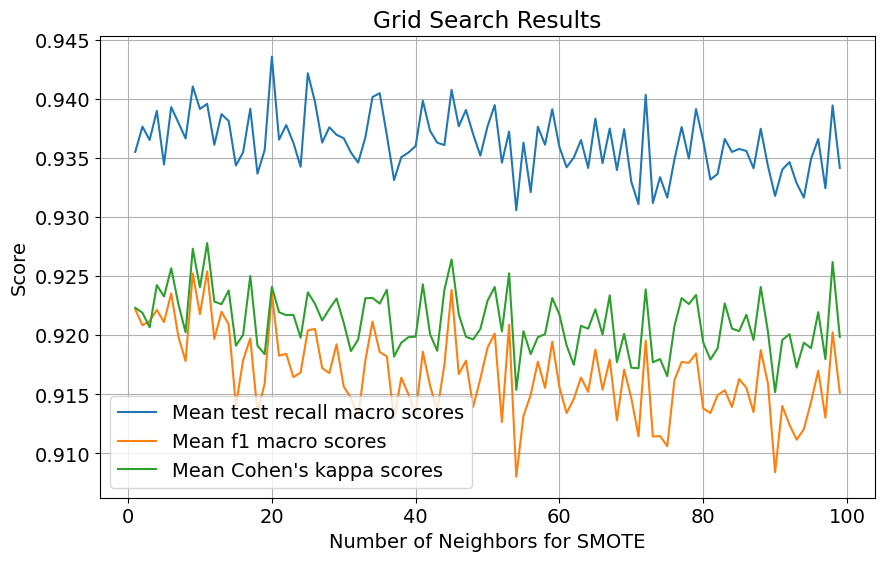

In [27]:
x_combined = pd.concat([x_train, x_val], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

validation_fold = [-1] * len(x_train) + [0] * len(x_val)
ps = PredefinedSplit(test_fold=validation_fold)

pipe = ImbPipeline([
    ('power', PowerTransformer()),
    ('SMOTE', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

param_search = {
    'SMOTE__k_neighbors': np.arange(1, 100, 1),
    }
    
gridsearch = GridSearchCV(
    pipe,
    param_grid=param_search,
    scoring=scoring,
    n_jobs=-1,
    refit='recall_macro',
    cv=ps,
    )

gridsearch.fit(x_combined, y_combined)

print('Best Parameters:', gridsearch.best_params_)
print('Best macro Recall score:', gridsearch.best_score_)

#plot results
results = gridsearch.cv_results_
mean_recall_scores = results['mean_test_recall_macro']
mean_f1_scores = results['mean_test_f1_macro']
mean_cohen_kappa = results['mean_test_cohen_kappa']
smote_values = results['param_SMOTE__k_neighbors']
plt.figure(figsize=(10, 6))
plt.plot(smote_values, mean_recall_scores, label='Test recall macro')
plt.plot(smote_values, mean_f1_scores, label='F1 macro')
plt.plot(smote_values, mean_cohen_kappa, label="Cohen's kappa")
plt.xlabel('Number of Neighbors for SMOTE')
plt.ylabel('Score')
plt.title('Grid Search Results')
plt.grid(True)
plt.legend()
plt.show()


Naive search for hyperparameter number of neighbors for kNN:

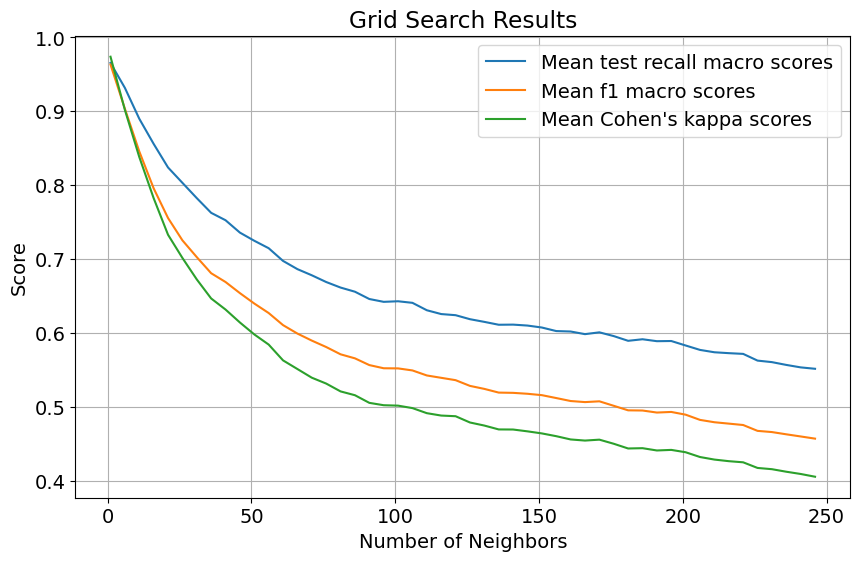

Best Parameters: {'knn__n_neighbors': 1}
Best macro Recall score: 0.9654457374085128


In [28]:
x_combined = pd.concat([x_train, x_val], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

validation_fold = [-1] * len(x_train) + [0] * len(x_val)
ps = PredefinedSplit(test_fold=validation_fold)

pipe = ImbPipeline([
    ('power', PowerTransformer()),
    ('SMOTE', SMOTE(random_state=42, k_neighbors=20)),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

param_search = {
    'knn__n_neighbors': np.arange(1, 250, 5),
    }
    
gridsearch = GridSearchCV(
    pipe,
    param_grid=param_search,
    scoring=scoring,
    n_jobs=-1,
    refit='recall_macro',
    cv=ps,
    )

gridsearch.fit(x_combined, y_combined)

#plot results
results = gridsearch.cv_results_
mean_recall_scores = results['mean_test_recall_macro']
mean_f1_scores = results['mean_test_f1_macro']
mean_cohen_kappa = results['mean_test_cohen_kappa']
param_values = results['param_knn__n_neighbors']
plt.figure(figsize=(10, 6))
plt.plot(param_values, mean_recall_scores, label='Mean test recall macro scores')
plt.plot(param_values, mean_f1_scores, label='Mean f1 macro scores')
plt.plot(param_values, mean_cohen_kappa, label="Mean Cohen's kappa scores")
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.title('Grid Search Results')
plt.grid(True)
plt.legend()
plt.show()

#print best found params
print('Best Parameters:', gridsearch.best_params_)
print('Best macro Recall score:', gridsearch.best_score_)


From the graph we observe that with increasing number of neighbors, our metrics decrease. GridsearchCV shows that the best n_neighbors=1, that is an indicator of overfitting. However we shouldn't forget, that out data set now contains duplicates, that is it is highly possible that we have the same samples in train, validation and test sets, so that kNN just memorises samples.

We try to tune kNN changing the parameter weights to distance from default uniform.

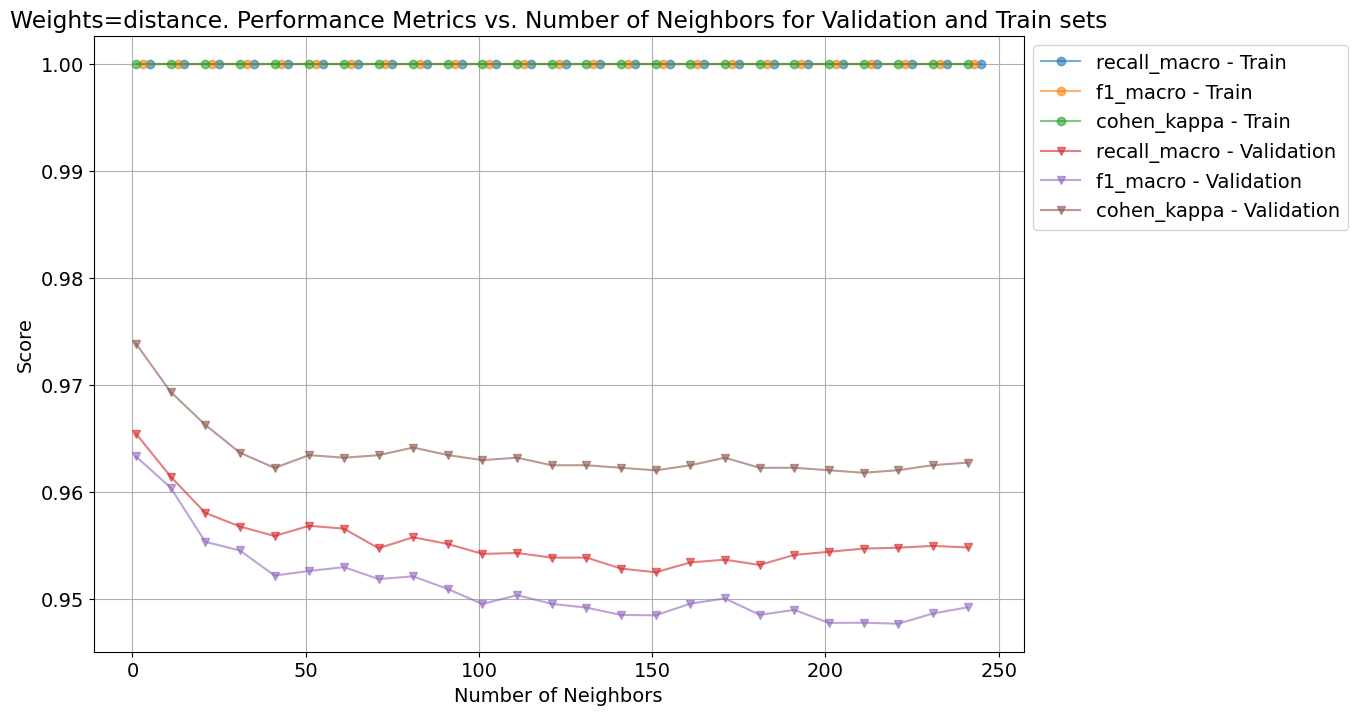

In [29]:
k_values = np.arange(1, 250, 10)

metrics = {
    'Train': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
    'Validation': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
}

for k in k_values:
    pipe = ImbPipeline([
        ('power', PowerTransformer()),
        ('SMOTE', SMOTE(random_state=42, k_neighbors=20)),
        ('knn', KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1))
    ])
    pipe.fit(x_train, y_train)
    pred_train = pipe.predict(x_train)
    pred_val = pipe.predict(x_val)
    
    metrics['Train']['recall_macro'].append(recall_score(y_train, pred_train, average='macro'))
    metrics['Train']['f1_macro'].append(f1_score(y_train, pred_train, average='macro'))
    metrics['Train']['cohen_kappa'].append(cohen_kappa_score(y_train, pred_train))

    metrics['Validation']['recall_macro'].append(recall_score(y_val, pred_val, average='macro'))
    metrics['Validation']['f1_macro'].append(f1_score(y_val, pred_val, average='macro'))
    metrics['Validation']['cohen_kappa'].append(cohen_kappa_score(y_val, pred_val))


plt.figure(figsize=(12, 8))
markers = {'Train': 'o', 'Validation': 'v', }
offset = {
    'Train': {'recall_macro': 4, 'f1_macro': 2, 'cohen_kappa': 0},
    'Validation': {'recall_macro': 0, 'f1_macro': 0, 'cohen_kappa': 0},
}

for set in metrics:
    for metric_name in metrics[set]:
        plt.plot(
            k_values + offset[set][metric_name],
            metrics[set][metric_name],
            marker=markers[set],
            label=f'{metric_name} - {set}',
            alpha=0.6
            )

plt.title('Weights=distance. Performance Metrics vs. Number of Neighbors for Validation and Train sets')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.show()

We see that just changing of weights from uniform to distance highly improves the model. Increasing a number of Neighbors doesn't decrease scores that fast anymore. 

In [30]:
pipe = ImbPipeline([
    ('power', PowerTransformer()),
    ('SMOTE', SMOTE(random_state=42, k_neighbors=20)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1))
])
pipe.fit(x_train, y_train)

new_row = {
    'Scaler': 'PowerTransformer',
    'Sampler': 'SMOTE',
    'Weights': 'distance',
    'Number of neighbors': 5,
    'Macro recall train': recall_score(y_train, pipe.predict(x_train), average='macro'),
    'Macro recall validation': recall_score(y_val, pipe.predict(x_val), average='macro'),
    'Macro f1 validation': f1_score(y_val, pipe.predict(x_val), average='macro'),
    'Cohens Kappa validation': cohen_kappa_score(y_val, pipe.predict(x_val)),
    'Accuracy validation': pipe.score(x_val, y_val),
}
kNN_scores = pd.concat([kNN_scores, pd.DataFrame([new_row])], ignore_index=True)
display(kNN_scores)

Scaler Sampler   Weights Number of neighbors  Macro recall train  \
0              None    None   uniform                   5            0.920809   
1  PowerTransformer    None   uniform                   5            0.926347   
2  PowerTransformer   SMOTE   uniform                   5            0.986759   
3  PowerTransformer   SMOTE  distance                   5            1.000000   

   Macro recall validation  Macro f1 validation  Cohens Kappa validation  \
0                 0.879720             0.881305                 0.881878   
1                 0.886645             0.885706                 0.886696   
2                 0.934461             0.921117                 0.923288   
3                 0.965513             0.964543                 0.972899   

   Accuracy validation  
0             0.898260  
1             0.902354  
2             0.933675  
3             0.976663

New search for n_neighbors for kNN with weights=distance:

Best Parameters: {'knn__n_neighbors': 4}
Best macro Recall score: 0.966674974921693


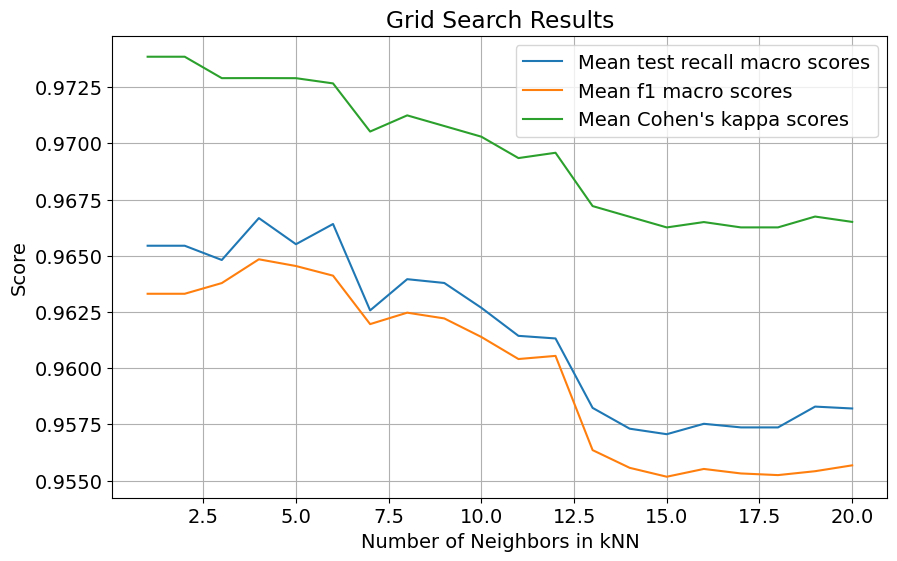

Scaler Sampler   Weights Number of neighbors  Macro recall train  \
0              None    None   uniform                   5            0.920809   
1  PowerTransformer    None   uniform                   5            0.926347   
2  PowerTransformer   SMOTE   uniform                   5            0.986759   
3  PowerTransformer   SMOTE  distance                   5            1.000000   
4  PowerTransformer   SMOTE  distance                   4            1.000000   

   Macro recall validation  Macro f1 validation  Cohens Kappa validation  \
0                 0.879720             0.881305                 0.881878   
1                 0.886645             0.885706                 0.886696   
2                 0.934461             0.921117                 0.923288   
3                 0.965513             0.964543                 0.972899   
4                 0.966675             0.964842                 0.972903   

   Accuracy validation  
0             0.898260  
1             0.902354  
2             0.933675  
3             0.976663  
4             0.976663

In [31]:
pipe = ImbPipeline([
    ('power', PowerTransformer()),
    ('SMOTE', SMOTE(random_state=42, k_neighbors=20)),
    ('knn', KNeighborsClassifier(weights='distance', n_jobs=-1))
])

param_search = {
    'knn__n_neighbors': np.arange(1, 21, 1),
    }
    
gridsearch = GridSearchCV(
    pipe,
    param_grid=param_search,
    scoring=scoring,
    n_jobs=-1,
    refit='recall_macro',
    cv=ps,
    return_train_score=True
    )

gridsearch.fit(x_combined, y_combined)

print('Best Parameters:', gridsearch.best_params_)
print('Best macro Recall score:', gridsearch.best_score_)

best_knn = gridsearch.best_estimator_

results = gridsearch.cv_results_
mean_recall_scores = results['mean_test_recall_macro']
mean_f1_scores = results['mean_test_f1_macro']
mean_cohen_kappa = results['mean_test_cohen_kappa']
knn_values = results['param_knn__n_neighbors']
plt.figure(figsize=(10, 6))
plt.plot(knn_values, mean_recall_scores, label='Mean test recall macro scores')
plt.plot(knn_values, mean_f1_scores, label='Mean f1 macro scores')
plt.plot(knn_values, mean_cohen_kappa, label="Mean Cohen's kappa scores")
plt.xlabel('Number of Neighbors in kNN')
plt.ylabel('Score')
plt.title('Grid Search Results')
plt.grid(True)
plt.legend()
plt.show()

best_index = gridsearch.best_index_

new_row = {
    'Scaler': 'PowerTransformer',
    'Sampler': 'SMOTE',
    'Weights': 'distance',
    'Number of neighbors': gridsearch.best_params_['knn__n_neighbors'],
    'Macro recall train': results['mean_train_recall_macro'][best_index],
    'Macro recall validation': results['mean_test_recall_macro'][best_index],
    'Macro f1 validation': results['mean_test_f1_macro'][best_index],
    'Cohens Kappa validation': results['mean_test_cohen_kappa'][best_index],
    'Accuracy validation': results['mean_test_accuracy'][best_index],
}

kNN_scores = pd.concat([kNN_scores, pd.DataFrame([new_row])], ignore_index=True)
display(kNN_scores)


In [32]:
kNN_scores_sorted = kNN_scores.sort_values(by='Macro recall validation', ascending=False)
display(kNN_scores_sorted)

Scaler Sampler   Weights Number of neighbors  Macro recall train  \
4  PowerTransformer   SMOTE  distance                   4            1.000000   
3  PowerTransformer   SMOTE  distance                   5            1.000000   
2  PowerTransformer   SMOTE   uniform                   5            0.986759   
1  PowerTransformer    None   uniform                   5            0.926347   
0              None    None   uniform                   5            0.920809   

   Macro recall validation  Macro f1 validation  Cohens Kappa validation  \
4                 0.966675             0.964842                 0.972903   
3                 0.965513             0.964543                 0.972899   
2                 0.934461             0.921117                 0.923288   
1                 0.886645             0.885706                 0.886696   
0                 0.879720             0.881305                 0.881878   

   Accuracy validation  
4             0.976663  
3             0.976663  
2             0.933675  
1             0.902354  
0             0.898260

Make confusion matrix.

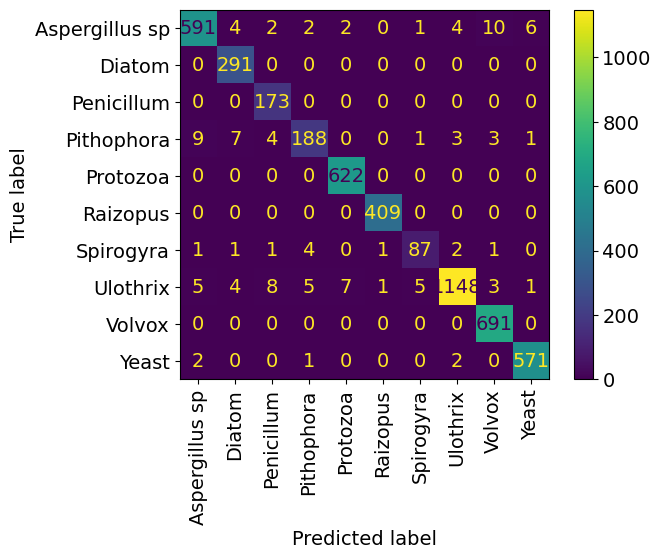

In [33]:
best_knn = ImbPipeline([
    ('power', PowerTransformer()),
    ('SMOTE', SMOTE(random_state=42, k_neighbors=20)),
    ('knn', KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1))
])
best_knn.fit(x_train, y_train)
predictions = best_knn.predict(x_val)
cm = confusion_matrix(y_val, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
disp.plot(cmap='viridis')
plt.xticks(rotation=90)
plt.show()

As we are dealing with multiclass classification, threshold is of no use. From the confusion matrix we observe that our error rate is not related to one specific class and is distributed among different classes.

Make learning curve for the best model:

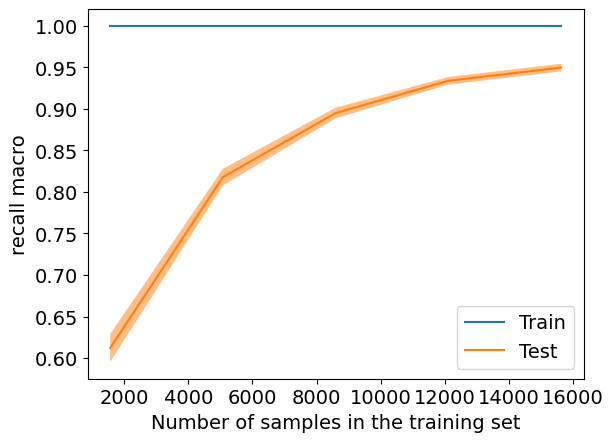

In [75]:
skf = StratifiedKFold()
learning_curve_logreg = LearningCurveDisplay.from_estimator(
    best_knn,
    x_train,
    y_train,
    cv=skf,
    scoring='recall_macro',
    n_jobs=-1,
    random_state=73,
    score_name='recall macro',
    score_type='both',
    std_display_style='fill_between'
    )


We observe that we don't have too much train data as train and test lines don't cross each other.

Finally we validate our model with the best found params on actual test data and do confusion matrix.

Test metrics:
Macro recall: 0.9642085727483808
Macro f1: 0.9654735773197519
Cohens Kappa: 0.9758469718716651
Accuracy: 0.979200786112021


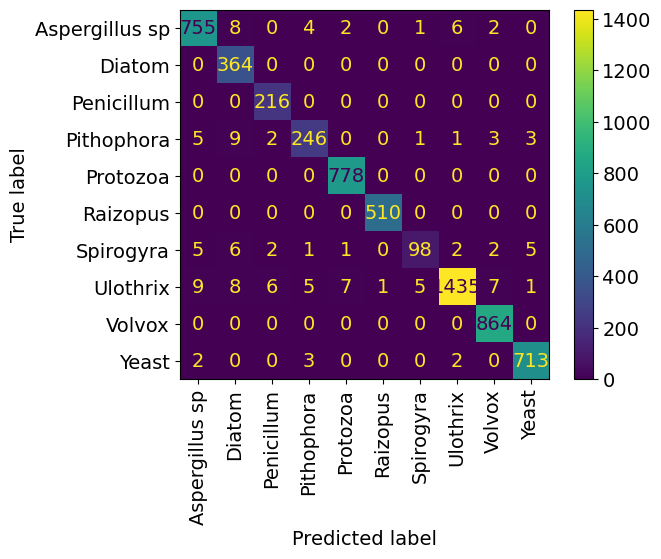

In [34]:
predictions = best_knn.predict(x_test)

cm = confusion_matrix(y_test, predictions)
print('Test metrics:')
print('Macro recall:', recall_score(y_test, predictions, average='macro'))
print('Macro f1:', f1_score(y_test, predictions, average='macro'))
print('Cohens Kappa:', cohen_kappa_score(y_test, predictions))
print('Accuracy:', best_knn.score(x_test, y_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
disp.plot(cmap='viridis')
plt.xticks(rotation=90)
plt.show()

We observe that results obtained on validation set are confirmed also on test data.

### RandomForestClassifier

For better comparison of results we will save them into a dataframe. 

In [35]:
columns = [
    'Sampler',
    'n_estimators',
    'criterion',
    'max_features',
    'max_depth',
    'bootstrap',
    'Macro recall train',
    'Macro recall validation',
    'Macro f1 validation',
    'Cohens Kappa validation',
    'Accuracy validation',
    ]
randomforest_scores = pd.DataFrame(columns=columns)

Default model:

In [36]:
randomforest = RandomForestClassifier(
    n_jobs=-1,
    random_state=42
    ) 
randomforest.fit(x_train, y_train)

new_row = {
    'Sampler': None,
    'n_estimators': 100,
    'criterion':'gini',
    'max_features': 'sqrt',
    'max_depth': None,
    'bootstrap': 'True',
    'Macro recall train': recall_score(y_train, randomforest.predict(x_train), average='macro'),
    'Macro recall validation': recall_score(y_val, randomforest.predict(x_val), average='macro'),
    'Macro f1 validation': f1_score(y_val, randomforest.predict(x_val), average='macro'),
    'Cohens Kappa validation': cohen_kappa_score(y_val, randomforest.predict(x_val)),
    'Accuracy validation': randomforest.score(x_val, y_val),

}
randomforest_scores = pd.concat([randomforest_scores, pd.DataFrame([new_row])], ignore_index=True)
display(randomforest_scores)

C:\Users\user\AppData\Local\Temp\ipykernel_14612\2783057566.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  randomforest_scores = pd.concat([randomforest_scores, pd.DataFrame([new_row])], ignore_index=True)


Sampler n_estimators criterion max_features max_depth bootstrap  \
0    None          100      gini         sqrt      None      True   

   Macro recall train  Macro recall validation  Macro f1 validation  \
0                 1.0                 0.956891             0.968205   

   Cohens Kappa validation  Accuracy validation  
0                 0.974495             0.978096

Next we try different samplers to work with imbalance.

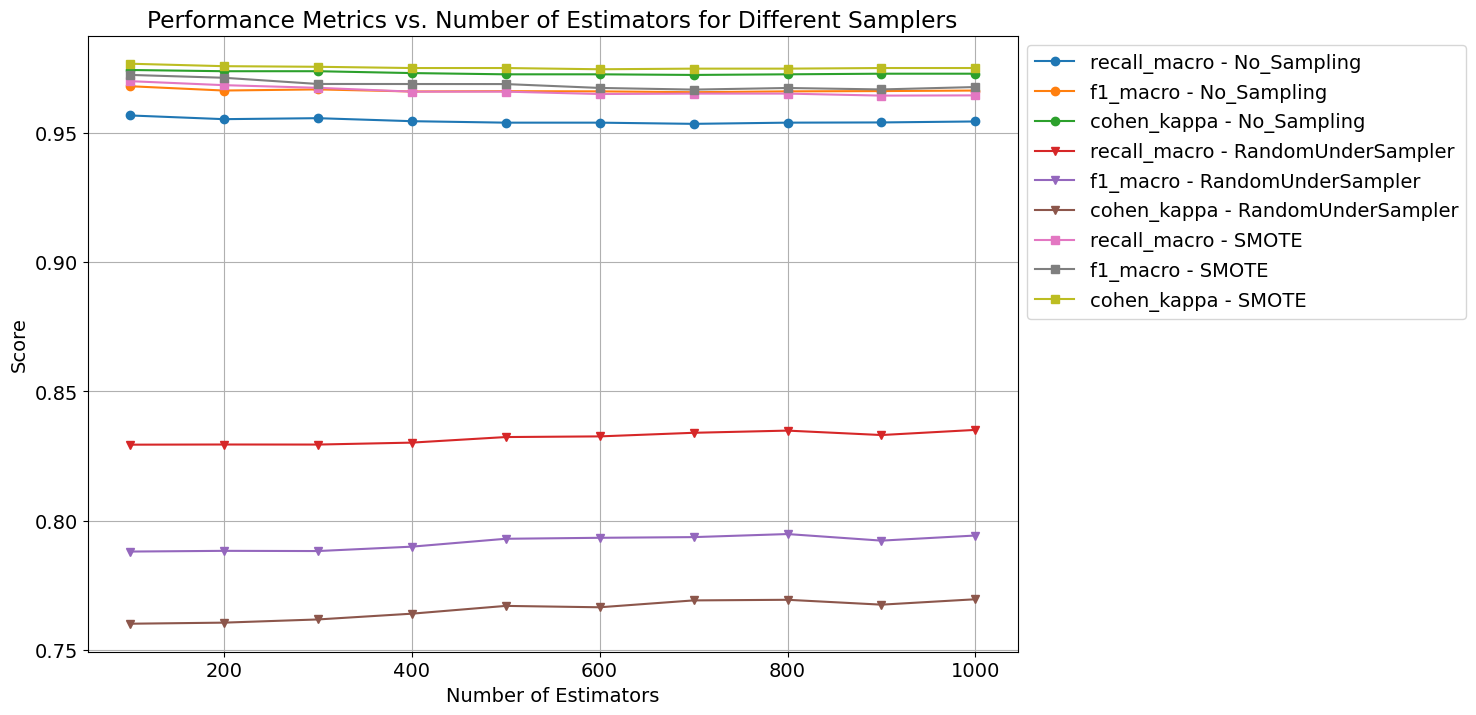

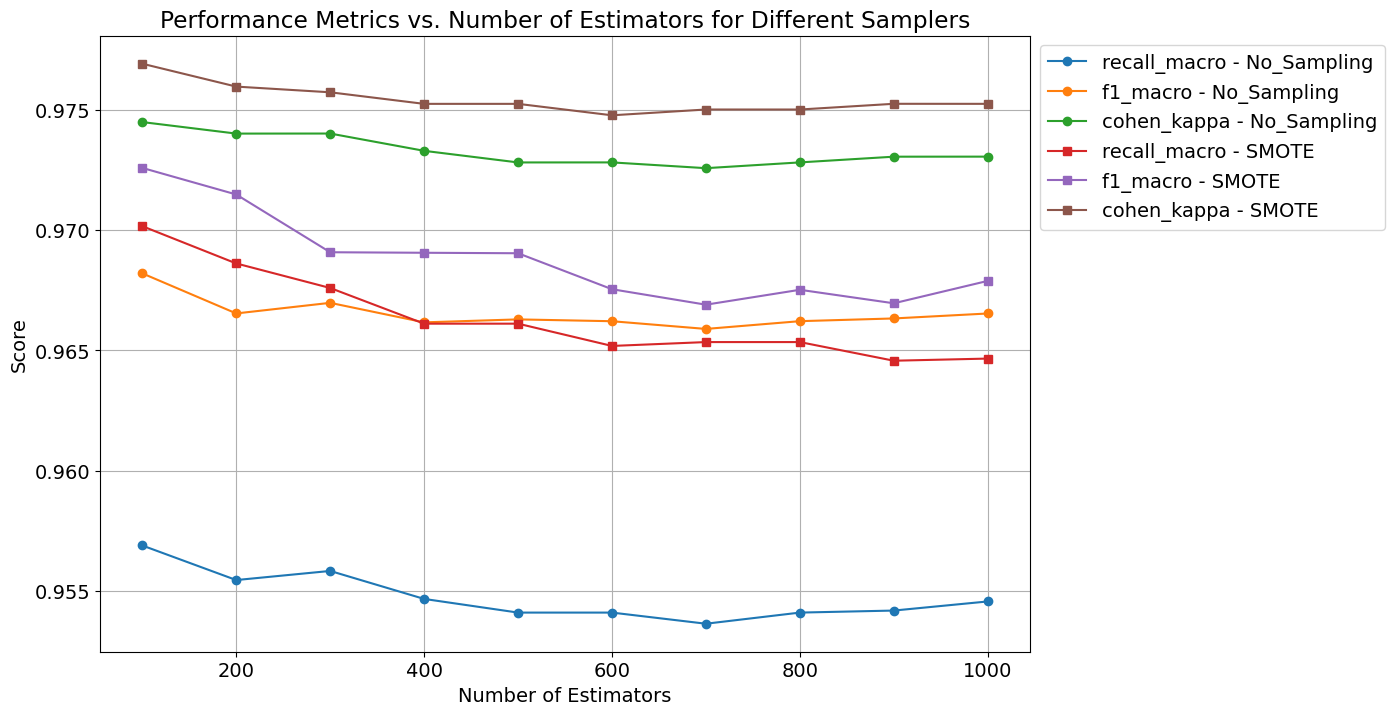

In [37]:
n_values = np.arange(100, 1001, 100)

metrics = {
    'No_Sampling': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
    'RandomUnderSampler': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
    'SMOTE': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
}

for n in n_values:
    forest = RandomForestClassifier(n_estimators=n, n_jobs=-1, random_state=42)
    forest.fit(x_train, y_train)
    y_pred = forest.predict(x_val)
    
    metrics['No_Sampling']['recall_macro'].append(recall_score(y_val, y_pred, average='macro'))
    metrics['No_Sampling']['f1_macro'].append(f1_score(y_val, y_pred, average='macro'))
    metrics['No_Sampling']['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))

samplers = [
    ('RandomUnderSampler', RandomUnderSampler(random_state=42)),
    ('SMOTE', SMOTE(random_state=42)),
]

for sampler_name, sampler_obj in samplers:
    for n in n_values:
        pipe_with_sampling = ImbPipeline([
            ('sampler', sampler_obj),
            ('forest', RandomForestClassifier(n_estimators=n, n_jobs=-1, random_state=42))
        ])
        pipe_with_sampling.fit(x_train, y_train)
        y_pred = pipe_with_sampling.predict(x_val)

        metrics[sampler_name]['recall_macro'].append(recall_score(y_val, y_pred, average='macro'))
        metrics[sampler_name]['f1_macro'].append(f1_score(y_val, y_pred, average='macro'))
        metrics[sampler_name]['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))

plt.figure(figsize=(12, 8))
markers = {'No_Sampling': 'o', 'RandomUnderSampler': 'v', 'SMOTE':'s'}

for sampler_name in metrics:
    for metric_name in metrics[sampler_name]:
        plt.plot(
            n_values,
            metrics[sampler_name][metric_name],
            marker=markers[sampler_name],
            label=f'{metric_name} - {sampler_name}'
            )

plt.title('Performance Metrics vs. Number of Estimators for Different Samplers')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))

for sampler_name in metrics:
    if sampler_name == 'RandomUnderSampler':
        continue
    for metric_name in metrics[sampler_name]:
        plt.plot(n_values, metrics[sampler_name][metric_name], marker=markers[sampler_name], label=f'{metric_name} - {sampler_name}')

plt.title('Performance Metrics vs. Number of Estimators for Different Samplers')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.show()


We see that SMOTE again shows better results then other samplers.

In [38]:
pipe = ImbPipeline([
            ('SMOTE', SMOTE(random_state=42)),
            ('forest', RandomForestClassifier(n_jobs=-1, random_state=42))
        ])
pipe.fit(x_train, y_train)

new_row = {
    'Sampler': 'SMOTE',
    'n_estimators': 100,
    'criterion': 'gini',
    'max_features': 'sqrt',
    'max_depth': None,
    'bootstrap': 'True',
    'Macro recall train': recall_score(y_train, pipe.predict(x_train), average='macro'),
    'Macro recall validation': recall_score(y_val, pipe.predict(x_val), average='macro'),
    'Macro f1 validation': f1_score(y_val, pipe.predict(x_val), average='macro'),
    'Cohens Kappa validation': cohen_kappa_score(y_val, pipe.predict(x_val)),
    'Accuracy validation': pipe.score(x_val, y_val),
}
randomforest_scores = pd.concat([randomforest_scores, pd.DataFrame([new_row])], ignore_index=True)
display(randomforest_scores)

Sampler n_estimators criterion max_features max_depth bootstrap  \
0    None          100      gini         sqrt      None      True   
1   SMOTE          100      gini         sqrt      None      True   

   Macro recall train  Macro recall validation  Macro f1 validation  \
0                 1.0                 0.956891             0.968205   
1                 1.0                 0.970167             0.972589   

   Cohens Kappa validation  Accuracy validation  
0                 0.974495             0.978096  
1                 0.976921             0.980143

Search for the best k_neighbors parameter for SMOTE:

Best Parameters: {'SMOTE__k_neighbors': 11}
Best macro Recall score: 0.9723290055307847


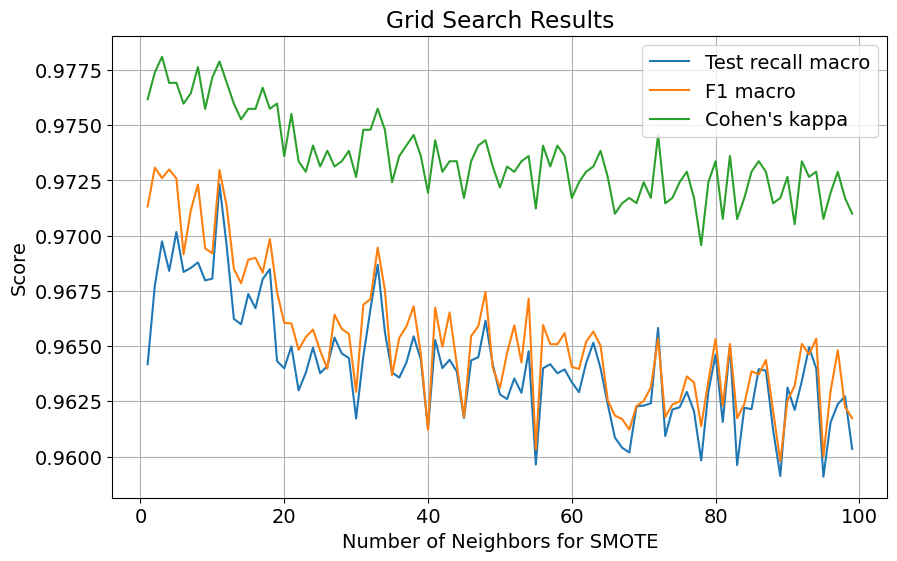

In [40]:
x_combined = pd.concat([x_train, x_val], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

validation_fold = [-1] * len(x_train) + [0] * len(x_val)
ps = PredefinedSplit(test_fold=validation_fold)

pipe = ImbPipeline([
    ('SMOTE', SMOTE(random_state=42)),
    ('knn', RandomForestClassifier(n_jobs=-1, random_state=42))
])

param_search = {
    'SMOTE__k_neighbors': np.arange(1, 100, 1),
    }
    
gridsearch = GridSearchCV(
    pipe,
    param_grid=param_search,
    scoring=scoring,
    n_jobs=-1,
    refit='recall_macro',
    cv=ps,
    )

gridsearch.fit(x_combined, y_combined)

print('Best Parameters:', gridsearch.best_params_)
print('Best macro Recall score:', gridsearch.best_score_)

#plot results
results = gridsearch.cv_results_
mean_recall_scores = results['mean_test_recall_macro']
mean_f1_scores = results['mean_test_f1_macro']
mean_cohen_kappa = results['mean_test_cohen_kappa']
smote_values = results['param_SMOTE__k_neighbors']
plt.figure(figsize=(10, 6))
plt.plot(smote_values, mean_recall_scores, label='Test recall macro')
plt.plot(smote_values, mean_f1_scores, label='F1 macro')
plt.plot(smote_values, mean_cohen_kappa, label="Cohen's kappa")
plt.xlabel('Number of Neighbors for SMOTE')
plt.ylabel('Score')
plt.title('Grid Search Results')
plt.grid(True)
plt.legend()
plt.show()


Discover whether bootstrap param influences performance of a model:

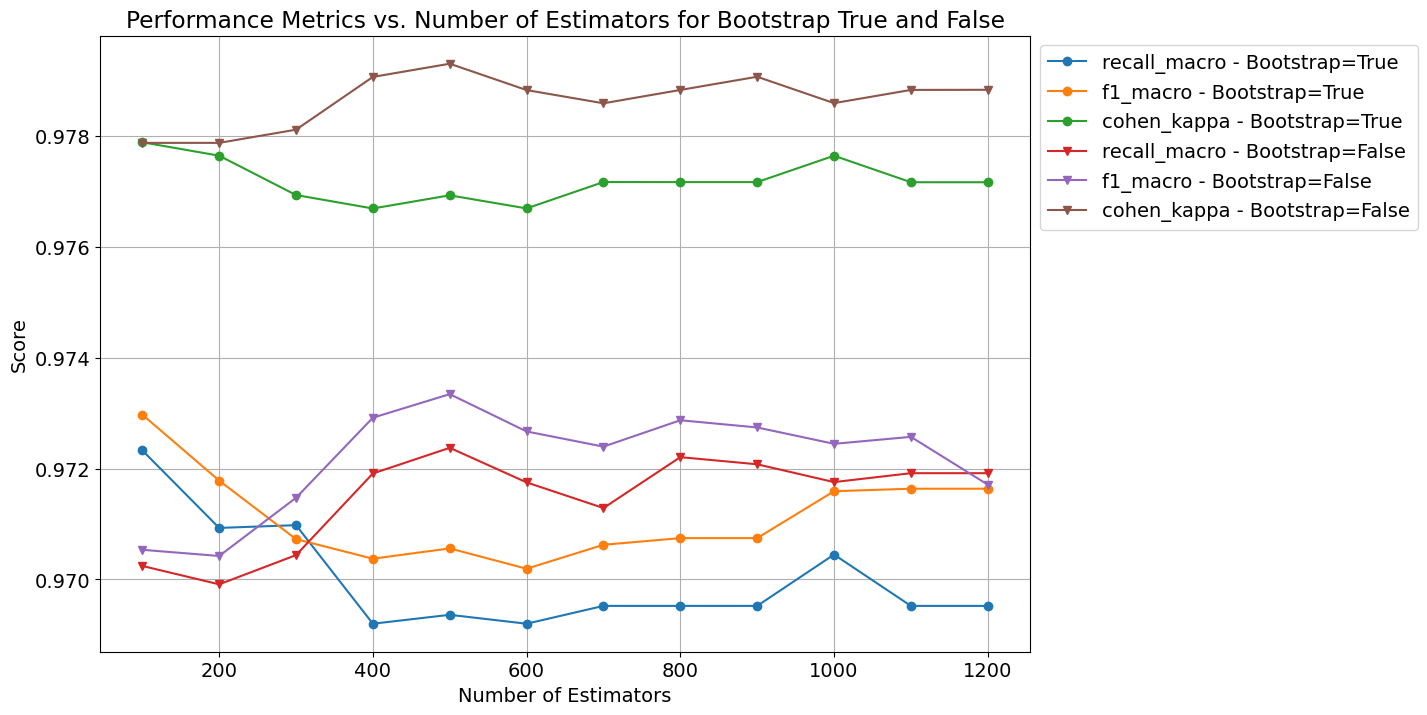

In [42]:
n_values = np.arange(100, 1201, 100)

metrics = {
    'Bootstrap=True': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
    'Bootstrap=False': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
}

for n in n_values:
    pipe_bootstrap_True = ImbPipeline([
        ('SMOTE', SMOTE(k_neighbors=11, random_state=42)),
        ('forest', RandomForestClassifier(n_estimators=n, n_jobs=-1, random_state=42))
    ])
    pipe_bootstrap_True.fit(x_train, y_train)

    y_pred = pipe_bootstrap_True.predict(x_val)
    
    metrics['Bootstrap=True']['recall_macro'].append(recall_score(y_val, y_pred, average='macro'))
    metrics['Bootstrap=True']['f1_macro'].append(f1_score(y_val, y_pred, average='macro'))
    metrics['Bootstrap=True']['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))


    pipe_bootstrap_False = ImbPipeline([
        ('SMOTE', SMOTE(random_state=42)),
        ('forest', RandomForestClassifier(n_estimators=n, bootstrap=False, n_jobs=-1, random_state=42))
    ])
    pipe_bootstrap_False.fit(x_train, y_train)

    y_pred = pipe_bootstrap_False.predict(x_val)
    
    metrics['Bootstrap=False']['recall_macro'].append(recall_score(y_val, y_pred, average='macro'))
    metrics['Bootstrap=False']['f1_macro'].append(f1_score(y_val, y_pred, average='macro'))
    metrics['Bootstrap=False']['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))


plt.figure(figsize=(12, 8))
markers = {'Bootstrap=True': 'o', 'Bootstrap=False': 'v', }

for sampler_name in metrics:
    for metric_name in metrics[sampler_name]:
        plt.plot(
            n_values,
            metrics[sampler_name][metric_name],
            marker=markers[sampler_name],
            label=f'{metric_name} - {sampler_name}'
            )

plt.title('Performance Metrics vs. Number of Estimators for Bootstrap True and False')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.show()

We observe that bootstrap=False gives slightly better results. We suppose that such behaviour might be caused by duplicates in data set, because these duplicates may end up in the same bootstrap sample for multiple trees. As a result we get similar trees because they are trained on the same (or overlapping) subsets of the data.

In [43]:
pipe = ImbPipeline([
            ('SMOTE', SMOTE(k_neighbors=11, random_state=42)),
            ('forest', RandomForestClassifier(n_jobs=-1, bootstrap=False, random_state=42))
        ])
pipe.fit(x_train, y_train)

new_row = {
    'Sampler': 'SMOTE',
    'n_estimators': 100,
    'criterion': 'gini',
    'max_features': 'sqrt',
    'max_depth': None,
    'bootstrap': 'False',
    'Macro recall train': recall_score(y_train, pipe.predict(x_train), average='macro'),
    'Macro recall validation': recall_score(y_val, pipe.predict(x_val), average='macro'),
    'Macro f1 validation': f1_score(y_val, pipe.predict(x_val), average='macro'),
    'Cohens Kappa validation': cohen_kappa_score(y_val, pipe.predict(x_val)),
    'Accuracy validation': pipe.score(x_val, y_val),
}
randomforest_scores = pd.concat([randomforest_scores, pd.DataFrame([new_row])], ignore_index=True)
display(randomforest_scores)

Sampler n_estimators criterion max_features max_depth bootstrap  \
0    None          100      gini         sqrt      None      True   
1   SMOTE          100      gini         sqrt      None      True   
2   SMOTE          100      gini         sqrt      None     False   

   Macro recall train  Macro recall validation  Macro f1 validation  \
0                 1.0                 0.956891             0.968205   
1                 1.0                 0.970167             0.972589   
2                 1.0                 0.973198             0.973949   

   Cohens Kappa validation  Accuracy validation  
0                 0.974495             0.978096  
1                 0.976921             0.980143  
2                 0.978834             0.981781

Next we do a search for hyperparameters. We predefine n_estimators=500 as it's number big enough to avoid overfitting and is small enough to get the results of modelling in reasonable time.

In [64]:
x_combined = pd.concat([x_train, x_val], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

validation_fold = [-1] * len(x_train) + [0] * len(x_val)
ps = PredefinedSplit(test_fold=validation_fold)

pipe = ImbPipeline([
    ('SMOTE', SMOTE(random_state=42, k_neighbors=11)),
    ('forest', RandomForestClassifier(bootstrap=False, n_estimators=500, random_state=42))
    ])

param_grid = {
    'forest__max_features': np.arange(1, 10, 1),
    'forest__max_depth': np.arange(10, 51, 10),
    'forest__criterion': ['gini', 'log_loss']
    }

gridsearch = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring=scoring,
    n_jobs=-1,
    refit='recall_macro',
    cv=ps,
    return_train_score=True
    )

gridsearch.fit(x_combined, y_combined)

print('Best Parameters:', gridsearch.best_params_)
print('Best macro Recall score:', gridsearch.best_score_)

best_forest = gridsearch.best_estimator_

results = gridsearch.cv_results_
best_index = gridsearch.best_index_

new_row = {
    'Sampler': 'SMOTE',
    'n_estimators': 500,
    'criterion':  gridsearch.best_params_['forest__criterion'],
    'max_features': gridsearch.best_params_['forest__max_features'],
    'max_depth': gridsearch.best_params_['forest__max_depth'],
    'bootstrap': 'False',
    'Macro recall train': results['mean_train_recall_macro'][best_index],
    'Macro recall validation': results['mean_test_recall_macro'][best_index],
    'Macro f1 validation': results['mean_test_f1_macro'][best_index],
    'Cohens Kappa validation': results['mean_test_cohen_kappa'][best_index],
    'Accuracy validation': results['mean_test_accuracy'][best_index],
}

randomforest_scores = pd.concat([randomforest_scores, pd.DataFrame([new_row])], ignore_index=True)
display(randomforest_scores)


Best Parameters: {'forest__criterion': 'gini', 'forest__max_depth': 30, 'forest__max_features': 7}
Best macro Recall score: 0.9755202057863551


Sampler n_estimators criterion max_features max_depth bootstrap  \
0    None          100      gini         sqrt      None      True   
1   SMOTE          100      gini         sqrt      None      True   
2   SMOTE          100      gini         sqrt      None     False   
3   SMOTE          500  log_loss            3        30       NaN   
4   SMOTE          500      gini            7        30     False   
5   SMOTE          500      gini            7        30     False   

   Macro recall train  Macro recall validation  Macro f1 validation  \
0                 1.0                 0.956891             0.968205   
1                 1.0                 0.970167             0.972589   
2                 1.0                 0.973198             0.973949   
3                 1.0                 0.972687             0.973322   
4                 1.0                 0.975520             0.974068   
5                 1.0                 0.975520             0.974068   

   Cohens Kappa validation  Accuracy validation  
0                 0.974495             0.978096  
1                 0.976921             0.980143  
2                 0.978834             0.981781  
3                 0.978836             0.981781  
4                 0.979079             0.981986  
5                 0.979079             0.981986

Find the best model according recall metric:

In [51]:
randomforest_scores_sorted = randomforest_scores.sort_values(by='Macro recall validation', ascending=False)
display(randomforest_scores_sorted)

Sampler n_estimators criterion max_features max_depth bootstrap  \
4   SMOTE          500      gini            7        30     False   
2   SMOTE          100      gini         sqrt      None     False   
3   SMOTE          500  log_loss            3        30       NaN   
1   SMOTE          100      gini         sqrt      None      True   
0    None          100      gini         sqrt      None      True   

   Macro recall train  Macro recall validation  Macro f1 validation  \
4                 1.0                 0.975520             0.974068   
2                 1.0                 0.973198             0.973949   
3                 1.0                 0.972687             0.973322   
1                 1.0                 0.970167             0.972589   
0                 1.0                 0.956891             0.968205   

   Cohens Kappa validation  Accuracy validation  
4                 0.979079             0.981986  
2                 0.978834             0.981781  
3                 0.978836             0.981781  
1                 0.976921             0.980143  
0                 0.974495             0.978096

Look at the feature importance for the model with the best params.

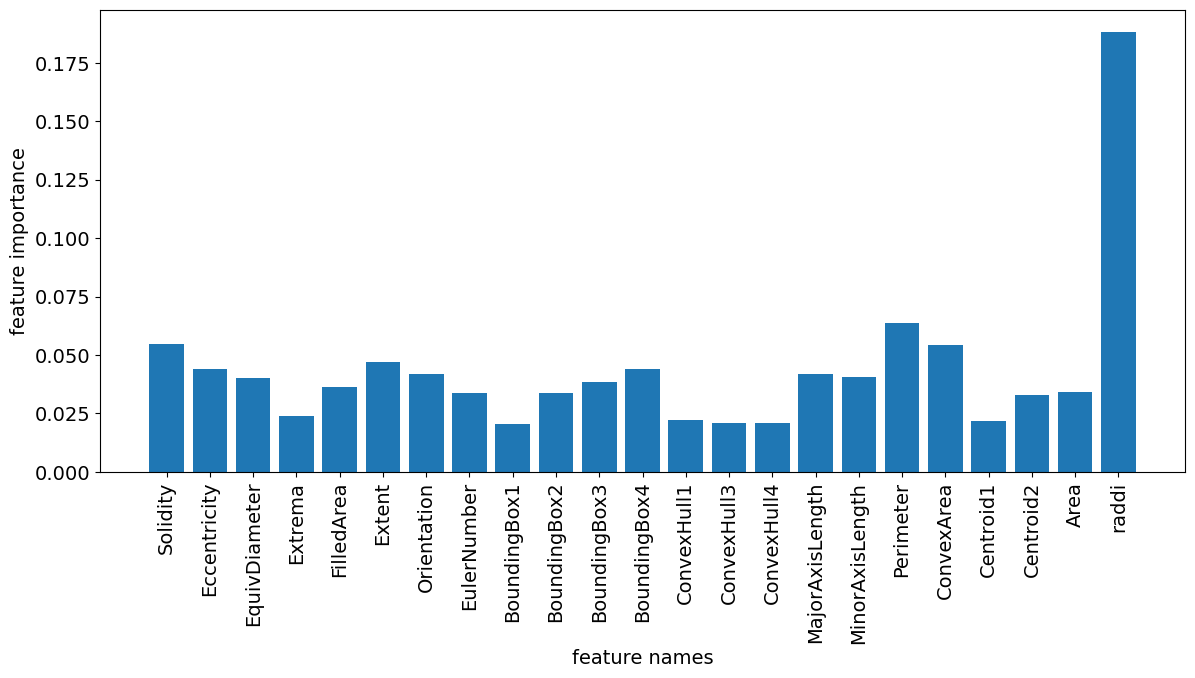

In [52]:
plt.figure(figsize=(14,6))
plt.bar(list(x_train.columns), best_forest.named_steps['forest'].feature_importances_)
plt.xlabel('feature names')
plt.ylabel('feature importance')
plt.xticks(rotation=90)
plt.show()

We see that we have one the most important feature - 'raddi'.

Make confusion matrix.

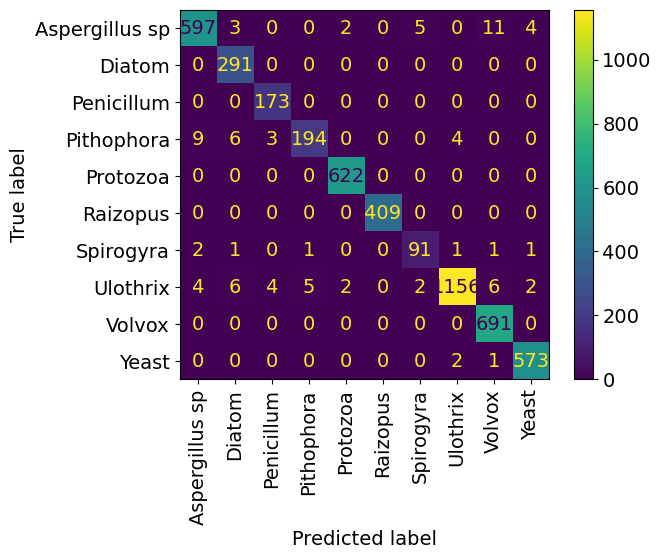

In [54]:
best_forest = ImbPipeline([
    ('SMOTE', SMOTE(random_state=42, k_neighbors=11)),
    ('forest', RandomForestClassifier(max_depth=30, max_features=7, bootstrap=False, n_estimators=500, random_state=42))
    ])
best_forest.fit(x_train, y_train)
cm = confusion_matrix(y_val, best_forest.predict(x_val))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_forest.classes_)
disp.plot(cmap='viridis')
plt.xticks(rotation=90)
plt.show()

Results on the confusion matrix are quite good as we see that errors are mostly equily distributed among different classes and we don't have one systematic error.

Next we do learning curve for tuned model:

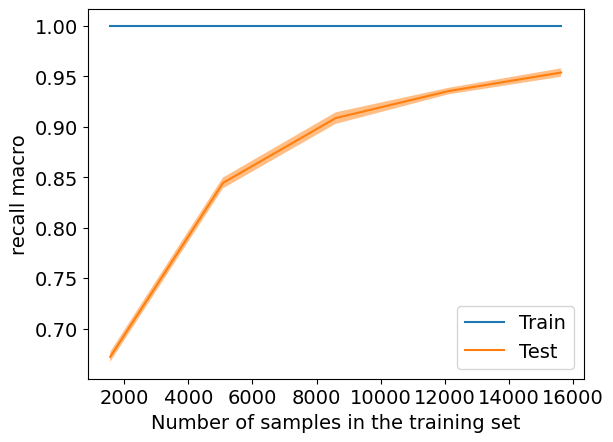

In [73]:
skf = StratifiedKFold()
learning_curve_logreg = LearningCurveDisplay.from_estimator(
    best_forest,
    x_train,
    y_train,
    cv=skf,
    scoring='recall_macro',
    n_jobs=-1,
    random_state=73,
    score_name='recall macro',
    score_type='both',
    std_display_style='fill_between'
    )


We observe that we don't have too much train data as train and test lines don't cross each other.

Finally we test our model with the best found params on actual test data and do confusion matrix.

Test metrics:
Macro recall: 0.9677738402209185
Macro f1: 0.9722828646349363
Cohens Kappa: 0.9809703299207498
Accuracy: 0.9836226662299378


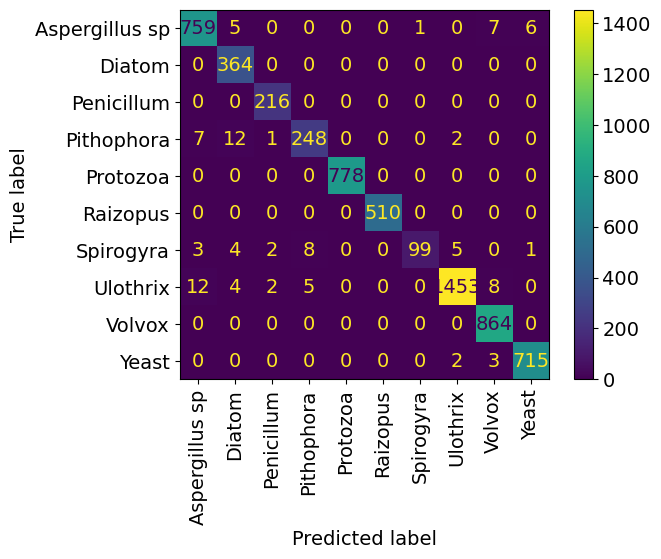

In [55]:
predictions = best_forest.predict(x_test)
cm = confusion_matrix(y_test, predictions)
print('Test metrics:')
print('Macro recall:', recall_score(y_test, predictions, average='macro'))
print('Macro f1:', f1_score(y_test, predictions, average='macro'))
print('Cohens Kappa:', cohen_kappa_score(y_test, predictions))
print('Accuracy:', best_forest.score(x_test, y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_forest.classes_)
disp.plot(cmap='viridis')
plt.xticks(rotation=90)
plt.show()

We observe that results on test data confirm our previously obtained metrics and compairing to validation metrics we don't have an overfitting.

### GradientBoostingClassifier

For better comparison of results we will save them into a dataframe. 

In [56]:
columns = [
    'Sampler',
    'n_estimators',
    'learning_rate',
    'max_depth',
    'Macro recall train',
    'Macro recall validation',
    'Macro f1 validation',
    'Cohens Kappa validation',
    'Accuracy validation',
    ]
gradient_scores = pd.DataFrame(columns=columns)

Default model:

In [57]:
gradient = GradientBoostingClassifier(
    n_estimators=100, #default parameter
    learning_rate=0.1, #default parameter
    max_depth=3, #default parameter
    random_state=42
    ) 
gradient.fit(x_train, y_train)

new_row = {
    'Sampler': None,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'Macro recall train': recall_score(y_train, gradient.predict(x_train), average='macro'),
    'Macro recall validation': recall_score(y_val, gradient.predict(x_val), average='macro'),
    'Macro f1 validation': f1_score(y_val, gradient.predict(x_val), average='macro'),
    'Cohens Kappa validation': cohen_kappa_score(y_val, gradient.predict(x_val)),
    'Accuracy validation': gradient.score(x_val, y_val),
}
gradient_scores = pd.concat([gradient_scores, pd.DataFrame([new_row])], ignore_index=True)
display(gradient_scores)

C:\Users\user\AppData\Local\Temp\ipykernel_14612\341952510.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gradient_scores = pd.concat([gradient_scores, pd.DataFrame([new_row])], ignore_index=True)


Sampler n_estimators  learning_rate max_depth  Macro recall train  \
0    None          100            0.1         3            0.884466   

   Macro recall validation  Macro f1 validation  Cohens Kappa validation  \
0                 0.855763             0.872184                 0.837819   

   Accuracy validation  
0             0.861208

Discover the best sampler:

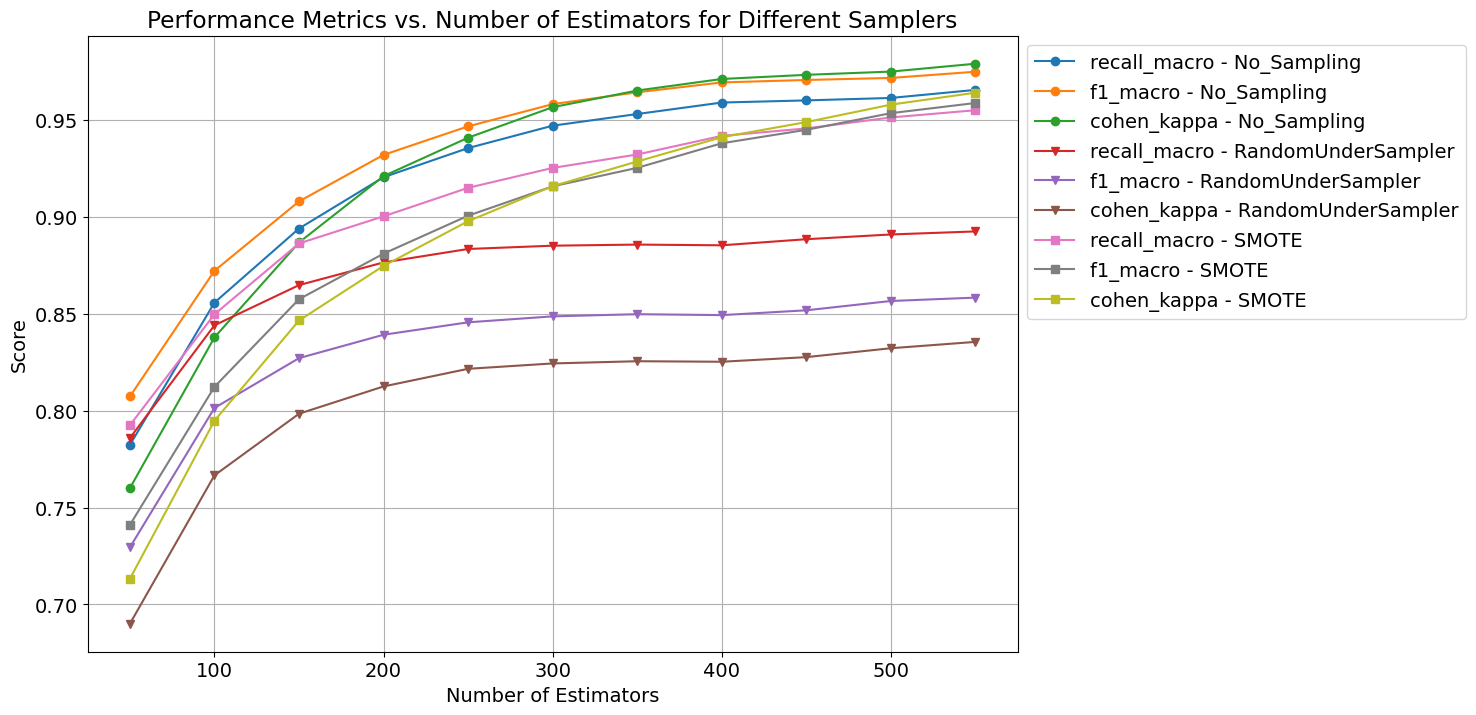

In [60]:
n_values = np.arange(50, 551, 50)

metrics = {
    'No_Sampling': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
    'RandomUnderSampler': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
    'SMOTE': {'recall_macro': [], 'f1_macro': [], 'cohen_kappa': []},
}

for n in n_values:
    gradient =  GradientBoostingClassifier(n_estimators=n, random_state=42)
    gradient.fit(x_train, y_train)
    y_pred = gradient.predict(x_val)
    
    metrics['No_Sampling']['recall_macro'].append(recall_score(y_val, y_pred, average='macro'))
    metrics['No_Sampling']['f1_macro'].append(f1_score(y_val, y_pred, average='macro'))
    metrics['No_Sampling']['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))

samplers = [
    ('RandomUnderSampler', RandomUnderSampler(random_state=42)),
    ('SMOTE', SMOTE(random_state=42)),
]

for sampler_name, sampler_obj in samplers:
    for n in n_values:
        pipe_with_sampling = ImbPipeline([
            ('sampler', sampler_obj),
            ('gradient', GradientBoostingClassifier(n_estimators=n, random_state=42))
        ])
        pipe_with_sampling.fit(x_train, y_train)
        y_pred = pipe_with_sampling.predict(x_val)

        metrics[sampler_name]['recall_macro'].append(recall_score(y_val, y_pred, average='macro'))
        metrics[sampler_name]['f1_macro'].append(f1_score(y_val, y_pred, average='macro'))
        metrics[sampler_name]['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))

plt.figure(figsize=(12, 8))
markers = {'No_Sampling': 'o', 'RandomUnderSampler': 'v', 'SMOTE':'s'}

for sampler_name in metrics:
    for metric_name in metrics[sampler_name]:
        plt.plot(
            n_values,
            metrics[sampler_name][metric_name],
            marker=markers[sampler_name],
            label=f'{metric_name} - {sampler_name}'
            )

plt.title('Performance Metrics vs. Number of Estimators for Different Samplers')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.show()


From the graph we observe a few things. First, a small number of estimators affects our model negatively and we need a higher order of number of estimators. Second, in this case data without a sampler gives better results, so we will not use any sampler. 

Using early stop we will approximate needed number of estimators.

In [59]:
import time

tol_levels = [0.01, 0.001, 0.0001]

for t in tol_levels:
    start_time = time.time()
    gradient = GradientBoostingClassifier(
        n_estimators=2000,
        n_iter_no_change=5,
        tol=t,
        validation_fraction=0.1, #default parameter
        random_state=42,
        )
    gradient.fit(x_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print('Tolerance =', t)
    print('stopped after', gradient.n_estimators_, 'steps')
    print('train accuracy:', gradient.score(x_train, y_train))
    print('validation accuracy:', gradient.score(x_val, y_val))
    print('train recall macro:', recall_score(y_train, gradient.predict(x_train), average='macro'))
    print('validation recall macro:', recall_score(y_val, gradient.predict(x_val), average='macro'))
    print('Time taken: {:.2f} seconds'.format(elapsed_time))
    print()


Tolerance = 0.01
stopped after 143 steps
train accuracy: 0.9241912366912367
validation accuracy: 0.8955987717502559
train recall macro: 0.9222958824634407
validation recall macro: 0.8855873223707118
Time taken: 89.47 seconds

Tolerance = 0.001
stopped after 543 steps
train accuracy: 0.9968263718263718
validation accuracy: 0.9803480040941658
train recall macro: 0.994999254739392
validation recall macro: 0.9657611226254404
Time taken: 323.47 seconds

Tolerance = 0.0001
stopped after 858 steps
train accuracy: 0.9986179361179361
validation accuracy: 0.9852610030706244
train recall macro: 0.996340950483094
validation recall macro: 0.9713696115353713
Time taken: 508.45 seconds



We observe that number of estimators to get higher recall is quite big. We want to find balance between precised model and time spent on fitting the model. We will graph metrics:

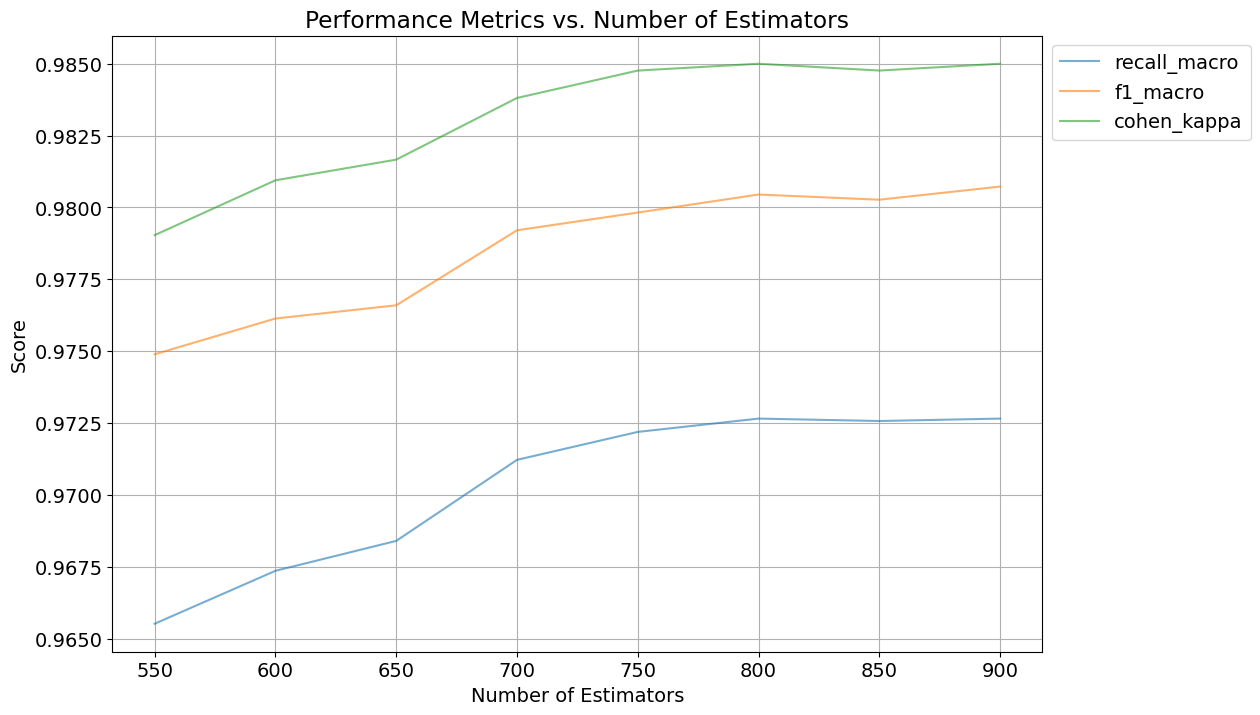

In [62]:
n_values = np.arange(550, 901, 50)

metrics = {
    'recall_macro': [], 'f1_macro': [], 'cohen_kappa': [],
}

for n in n_values:
    gradient = GradientBoostingClassifier(n_estimators=n, random_state=42)
    gradient.fit(x_train, y_train)
    y_pred = gradient.predict(x_val)
    
    metrics['recall_macro'].append(recall_score(y_val, y_pred, average='macro'))
    metrics['f1_macro'].append(f1_score(y_val, y_pred, average='macro'))
    metrics['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))


plt.figure(figsize=(12, 8))

for metric_name in metrics:
    plt.plot(
        n_values,
        metrics[metric_name],
        label=metric_name,
        alpha=0.6
        )

plt.title('Performance Metrics vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.show()


From n_estimators = 750 the growth in metrics is not as significant so we will use n_estimators=750 due to time issues. 

Search for hyperparameters:

In [63]:
x_combined = pd.concat([x_train, x_val], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

validation_fold = [-1] * len(x_train) + [0] * len(x_val)
ps = PredefinedSplit(test_fold=validation_fold)

gradient = GradientBoostingClassifier(
    n_estimators=750,
    random_state=42
    )

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 1],
    'max_depth': np.arange(1, 6, 1),
    }

search = GridSearchCV(
    gradient,
    param_grid=param_grid,
    scoring=scoring,
    refit='recall_macro',
    cv=ps,
    verbose=3,
    )
search.fit(x_combined, y_combined)

print('Best Parameters:', search.best_params_)
print('Best macro Recall score:', search.best_score_)
best_gradient = search.best_estimator_

Fitting 1 folds for each of 30 candidates, totalling 30 fits
[CV 1/1] END learning_rate=0.001, max_depth=1; accuracy: (test=0.402) cohen_kappa: (test=0.246) f1_macro: (test=0.229) recall_macro: (test=0.251) total time= 3.4min
[CV 1/1] END learning_rate=0.001, max_depth=2; accuracy: (test=0.476) cohen_kappa: (test=0.354) f1_macro: (test=0.446) recall_macro: (test=0.422) total time= 5.8min
[CV 1/1] END learning_rate=0.001, max_depth=3; accuracy: (test=0.609) cohen_kappa: (test=0.529) f1_macro: (test=0.584) recall_macro: (test=0.553) total time= 8.3min
[CV 1/1] END learning_rate=0.001, max_depth=4; accuracy: (test=0.686) cohen_kappa: (test=0.626) f1_macro: (test=0.671) recall_macro: (test=0.637) total time=10.9min
[CV 1/1] END learning_rate=0.001, max_depth=5; accuracy: (test=0.729) cohen_kappa: (test=0.678) f1_macro: (test=0.728) recall_macro: (test=0.684) total time=13.8min
[CV 1/1] END learning_rate=0.01, max_depth=1; accuracy: (test=0.566) cohen_kappa: (test=0.483) f1_macro: (test=0.5

In [65]:
gradient = GradientBoostingClassifier(
    n_estimators=750,
    max_depth=5,
    learning_rate=0.2,
    random_state=42
    )
gradient.fit(x_train, y_train)
val_predict = gradient.predict(x_val)
new_row = {
    'Sampler': None,
    'n_estimators': 750,
    'learning_rate': 0.2,
    'max_depth': 5,
    'Macro recall train': recall_score(y_train, gradient.predict(x_train), average='macro'),
    'Macro recall validation': recall_score(y_val, val_predict, average='macro'),
    'Macro f1 validation': f1_score(y_val, val_predict, average='macro'),
    'Cohens Kappa validation': cohen_kappa_score(y_val, val_predict),
    'Accuracy validation': gradient.score(x_val, y_val),
}
gradient_scores = pd.concat([gradient_scores, pd.DataFrame([new_row])], ignore_index=True)
display(gradient_scores)

Sampler n_estimators  learning_rate max_depth  Macro recall train  \
0    None          100            0.1         3            0.884466   
1    None          750            0.2         5            1.000000   

   Macro recall validation  Macro f1 validation  Cohens Kappa validation  \
0                 0.855763             0.872184                 0.837819   
1                 0.978119             0.984166                 0.988332   

   Accuracy validation  
0             0.861208  
1             0.989969

Find the best model according recall metric:

In [66]:
gradient_scores_sorted = gradient_scores.sort_values(by='Macro recall validation', ascending=False)
display(gradient_scores_sorted)

Sampler n_estimators  learning_rate max_depth  Macro recall train  \
1    None          750            0.2         5            1.000000   
0    None          100            0.1         3            0.884466   

   Macro recall validation  Macro f1 validation  Cohens Kappa validation  \
1                 0.978119             0.984166                 0.988332   
0                 0.855763             0.872184                 0.837819   

   Accuracy validation  
1             0.989969  
0             0.861208

Look at the feature importance for the model with the best params.

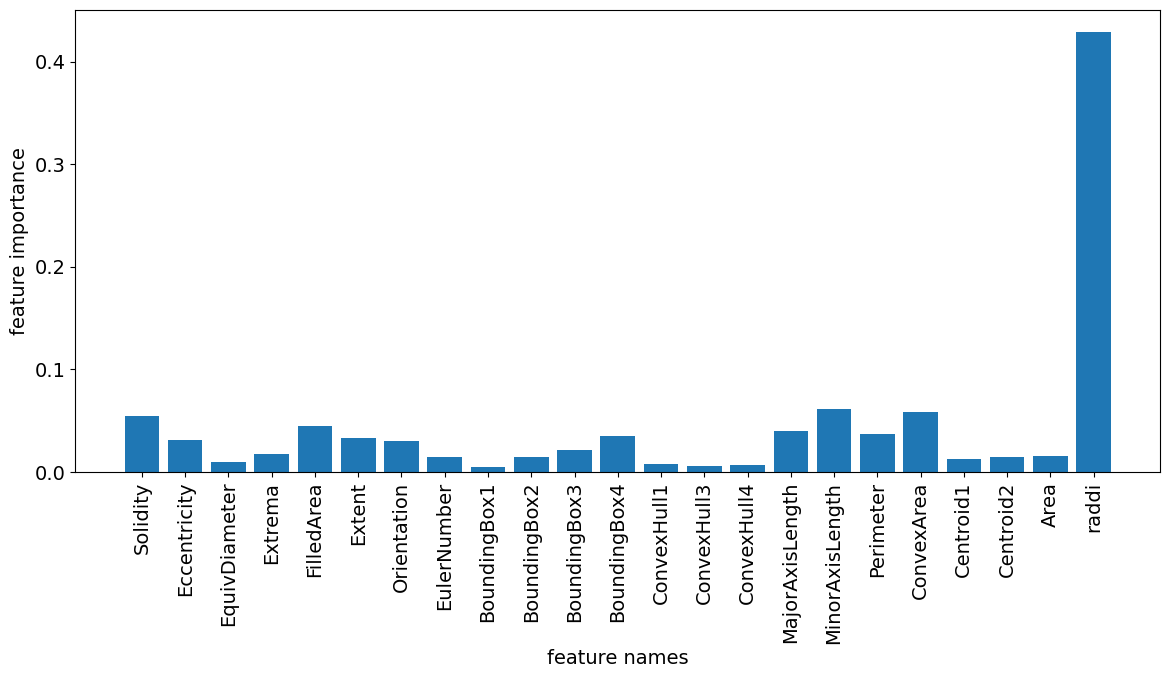

In [67]:
plt.figure(figsize=(14,6))
plt.bar(list(x_train.columns), gradient.feature_importances_)
plt.xlabel('feature names')
plt.ylabel('feature importance')
plt.xticks(rotation=90)
plt.show()

We see that we have one the most important feature - 'raddi'.

Make confusion matrix.

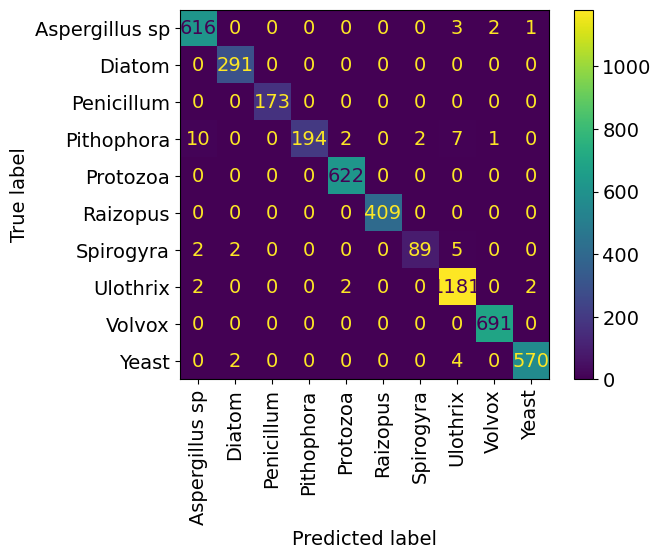

In [68]:
cm = confusion_matrix(y_val, val_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gradient.classes_)
disp.plot(cmap='viridis')
plt.xticks(rotation=90)
plt.show()

Results on the confusion matrix are quite good as we see that errors are mostly equily distributed among different classes and we don't have one systematic error.

Make learning curve for the best model:

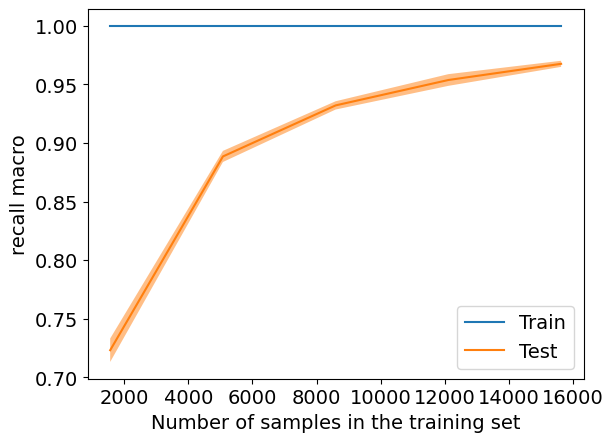

In [74]:
skf = StratifiedKFold()
learning_curve_logreg = LearningCurveDisplay.from_estimator(
    gradient,
    x_train,
    y_train,
    cv=skf,
    scoring='recall_macro',
    n_jobs=-1,
    random_state=73,
    score_name='recall macro',
    score_type='both',
    std_display_style='fill_between'
    )


We observe that we don't have too much train data as train and test lines don't cross each other.

Finally we test our model with the best found params on actual test data and do confusion matrix.

Test metrics:
Macro recall: 0.9771888229661478
Macro f1: 0.9848332414211921
Cohens Kappa: 0.9900926865134951
Accuracy: 0.9914837864395677


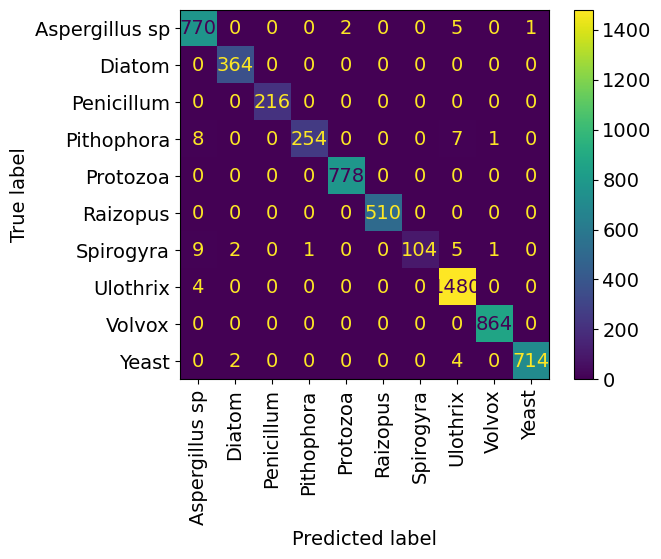

In [69]:
predictions = gradient.predict(x_test)
cm = confusion_matrix(y_test, predictions)
print('Test metrics:')
print('Macro recall:', recall_score(y_test, predictions, average='macro'))
print('Macro f1:', f1_score(y_test, predictions, average='macro'))
print('Cohens Kappa:', cohen_kappa_score(y_test, predictions))
print('Accuracy:', gradient.score(x_test, y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gradient.classes_)
disp.plot(cmap='viridis')
plt.xticks(rotation=90)
plt.show()

We observe that results on test data confirm our previously obtained metrics and compairing to validation metrics we don't have an overfitting.

### Logistic regression

REMARK:

StandardScaler() doesn't work good when the data doesn't follow Gaussian distribution.  
QuantileTransformer(output_distribution='uniform') is also not a good choice for Logistic Regression.  
Normalizer() is not suitable for Logistic Regression.

In [ ]:
scalers = [RobustScaler(),
           PowerTransformer(method='yeo-johnson'),
           QuantileTransformer(output_distribution='normal')
           ]

x_train_scaled = [x_train, ]
x_val_scaled = [x_val, ]

for scaler in scalers:
    x_train_scaled.append(pd.DataFrame(scaler.fit_transform(x_train)))
    x_val_scaled.append(pd.DataFrame(scaler.transform(x_val)))

In [ ]:
list_of_scalers = [
    'No scaling',
    'RobustScaler',
    'PowerTransformer',
    'QuantileTransformer (Gaussian)'
    ]

data_scalers = {
    'Scaler': None,
    'macro recall train' : None,
    'macro recall validation': None,
    'macro f1 train' : None,
    'macro f1 validation': None,
    'Cohens Kappa train' : None,
    'Cohens Kappa validation': None
}

In [ ]:
logreg_quick_scores = pd.DataFrame(data=data_scalers, index=np.arange(len(list_of_scalers)))

In [ ]:
for count, (x_train_scale, x_val_scale) in enumerate(zip(x_train_scaled, x_val_scaled)):

    logreg_baseline = LogisticRegression(solver='saga', max_iter=100_000, n_jobs=-1)
    logreg_baseline.fit(x_train_scale, y_train)

    logreg_quick_scores.loc[count] = [
        list_of_scalers[count],
        recall_score(y_train, logreg_baseline.predict(x_train_scale), average='macro'),
        recall_score(y_val, logreg_baseline.predict(x_val_scale), average='macro'),
        f1_score(y_train, logreg_baseline.predict(x_train_scale), average='macro'),
        f1_score(y_val, logreg_baseline.predict(x_val_scale), average='macro'),
        cohen_kappa_score(y_train, logreg_baseline.predict(x_train_scale)),
        cohen_kappa_score(y_val, logreg_baseline.predict(x_val_scale))
        ]

In [ ]:
display(logreg_quick_scores)

Scaler macro recall train macro recall validation  \
0                      No scaling           0.392739                0.395838   
1                    RobustScaler           0.397403                0.401808   
2                PowerTransformer           0.428755                0.427619   
3  QuantileTransformer (Gaussian)           0.406182                0.412739   

  macro f1 train macro f1 validation Cohens Kappa train  \
0       0.393598             0.39139           0.384009   
1       0.400739            0.401788            0.39253   
2       0.437783            0.433425           0.411385   
3       0.416022            0.418428           0.375202   

  Cohens Kappa validation  
0                0.391148  
1                0.396733  
2                0.415575  
3                0.391299

It seems that PowerTransformer is the best option.

Lets now see if resampling will influence model's performance.  

First we need to find the best hyperparameter k_neighbors for SMOTE.

In [ ]:
from sklearn.model_selection import PredefinedSplit

In [ ]:
# using PredefinedSplit()

smote_pipe_logreg = ImbPipeline([
    ('smote', SMOTE(random_state=73)),
    ('scaler', PowerTransformer()),
    ('logreg', LogisticRegression(solver='saga', max_iter=100_000, n_jobs=-1))
])

x_combined_processed = np.vstack((x_train, x_val))
y_combined_processed = np.hstack((y_train, y_val))

validation_fold = [-1 for _ in range(x_train.shape[0])] + [0 for _ in range(x_val.shape[0])]
ps = PredefinedSplit(test_fold=validation_fold)

param_grid_logreg_smote = {'smote__k_neighbors': np.arange(1, 21, 1)}
smote_grid_logreg = GridSearchCV(smote_pipe_logreg, param_grid=param_grid_logreg_smote, scoring=scoring, refit='recall_macro', cv=ps, n_jobs=-1)

smote_grid_logreg.fit(x_combined_processed, y_combined_processed)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=73)),
                                       ('scaler', PowerTransformer()),
                                       ('logreg',
                                        LogisticRegression(max_iter=100000,
                                                           n_jobs=-1,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'smote__k_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             refit='recall_macro',
             scoring={'cohen_kappa': make_scorer(cohen_kappa),
                      'f1_macro': 'f1_macro', 'recall_macro': 'recall_macro'})

In [ ]:
print('best parameters: ', smote_grid_logreg.best_params_)
print('best recall_macro: ', smote_grid_logreg.best_score_)

display(smote_grid_logreg.cv_results_)

best parameters:  {'smote__k_neighbors': 1}
best recall_macro:  0.5457676588841777


{'mean_fit_time': array([27.02537227, 28.017663  , 31.63736081, 29.33465528, 26.81626916,
        29.91022992, 30.50363421, 29.93313718, 35.27431011, 34.17740512,
        35.99223089, 33.85444212, 34.25532198, 37.45324111, 36.09311914,
        35.28403616, 21.41413999, 23.01607084, 22.397228  , 21.77002287]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'mean_score_time': array([0.11498499, 0.17349911, 0.10125113, 0.10974789, 0.18535686,
        0.14471793, 0.16544199, 0.14025283, 0.08710718, 0.12174892,
        0.10758901, 0.10675979, 0.11904502, 0.11826706, 0.10446191,
        0.08780074, 0.10043502, 0.08906817, 0.07246971, 0.05942988]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'param_smote__k_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                    17, 18, 19, 20],
              mask=[False,

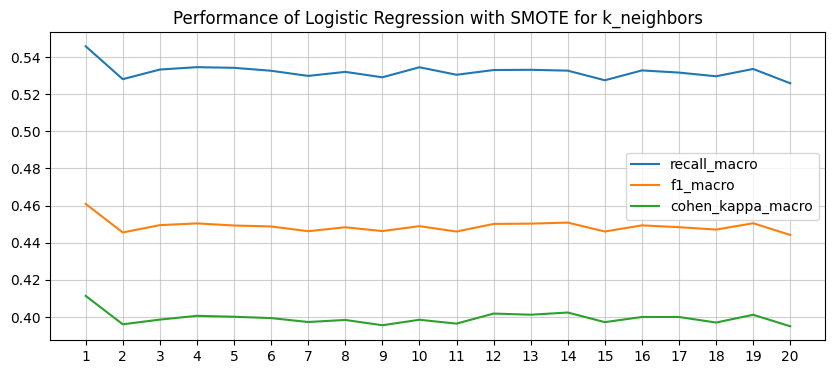

In [ ]:
logreg_smote_results = pd.DataFrame(smote_grid_logreg.cv_results_)

logreg_smote_plot_recall = logreg_smote_results['mean_test_recall_macro']
logreg_smote_plot_f1 = logreg_smote_results['mean_test_f1_macro']
logreg_smote_plot_kappa = logreg_smote_results['mean_test_cohen_kappa']
logreg_smote_plot_neighbors = logreg_smote_results['param_smote__k_neighbors']

plt.figure(figsize=(10,4))
plt.style.use('default')
plt.title('Performance of Logistic Regression with SMOTE for k_neighbors', fontsize=12)
plt.plot(logreg_smote_plot_neighbors, logreg_smote_plot_recall, label='recall_macro')
plt.plot(logreg_smote_plot_neighbors, logreg_smote_plot_f1, label='f1_macro')
plt.plot(logreg_smote_plot_neighbors, logreg_smote_plot_kappa, label='cohen_kappa_macro')
plt.xticks(ticks=np.arange(1, 21, 1))
plt.grid(True, alpha=0.6)
plt.legend(loc='best')
plt.show()

In [ ]:
best_smote_logreg = SMOTE(k_neighbors=smote_grid_logreg.best_params_['smote__k_neighbors'], random_state=73)

In [ ]:
initial_logreg = ImbPipeline([('scaler', PowerTransformer()),
                              ('logreg', LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100_000, n_jobs=-1))])

undersampled_logreg = ImbPipeline([('scaler', PowerTransformer()),
                                   ('sampler', RandomUnderSampler(random_state=42)),
                                   ('logreg', LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100_000, n_jobs=-1))])

smoted_logreg = ImbPipeline([('scaler', PowerTransformer()),
                             ('sampler', best_smote_logreg),
                             ('logreg', LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100_000, n_jobs=-1))])

logreg_pipes = [initial_logreg, undersampled_logreg, smoted_logreg]
logreg_data = {
    'resampler': None,
    'macro recall train' : None,
    'macro recall validation': None,
    'macro f1 train' : None,
    'macro f1 validation': None,
    'Cohens Kappa train' : None,
    'Cohens Kappa validation': None
}

logreg_resample_scores = pd.DataFrame(data=logreg_data, index=np.arange(len(logreg_pipes)))
resamplers = ['No resampling', 'RandomUnderSampler', 'SMOTE']

for index, pipe in enumerate(logreg_pipes):

    pipe.fit(x_train, y_train)

    logreg_resample_scores.loc[index] = [
        resamplers[index],
        recall_score(y_train, pipe.predict(x_train), average='macro'),
        recall_score(y_val, pipe.predict(x_val), average='macro'),
        f1_score(y_train, pipe.predict(x_train), average='macro'),
        f1_score(y_val, pipe.predict(x_val), average='macro'),
        cohen_kappa_score(y_train, pipe.predict(x_train)),
        cohen_kappa_score(y_val, pipe.predict(x_val))
        ]

In [ ]:
display(logreg_resample_scores)

resampler macro recall train macro recall validation  \
0       No resampling           0.428755                0.427619   
1  RandomUnderSampler           0.519794                0.525908   
2               SMOTE           0.538203                0.537973   

  macro f1 train macro f1 validation Cohens Kappa train  \
0       0.437783            0.433425           0.411385   
1       0.430144            0.438807           0.377997   
2       0.448594            0.452137           0.392881   

  Cohens Kappa validation  
0                0.415575  
1                0.392966  
2                0.401573

Thus, SMOTE turned out to be the best strategy for Logistic Regression.  
But the results are still very disappointing, so, as a last resort, we will use Polynomial features to see if it can significantly improve performance of the model.

Before applying Polynomialfeatures we should first resample the data as it works better on the original feature space where the relationships between features are more straightforward.

First, we try degree=2

In [ ]:
poly_logreg = ImbPipeline([('scaler', PowerTransformer()),
                           ('sampler', best_smote_logreg),
                           ('poly', PolynomialFeatures(degree=2)),
                           ('logreg', LogisticRegression(solver='saga', multi_class='multinomial', max_iter=200_000, n_jobs=-1))])

poly_logreg.fit(x_train, y_train)

poly_logreg_data = {
    'macro recall train' : None,
    'macro recall validation': None,
    'macro f1 train' : None,
    'macro f1 validation': None,
    'Cohens Kappa train' : None,
    'Cohens Kappa validation': None
}
poly_logreg_resample_scores = pd.DataFrame(data=poly_logreg_data, index=[0])

poly_logreg_resample_scores.loc[0] = [
        recall_score(y_train, poly_logreg.predict(x_train), average='macro'),
        recall_score(y_val, poly_logreg.predict(x_val), average='macro'),
        f1_score(y_train, poly_logreg.predict(x_train), average='macro'),
        f1_score(y_val, poly_logreg.predict(x_val), average='macro'),
        cohen_kappa_score(y_train, poly_logreg.predict(x_train)),
        cohen_kappa_score(y_val, poly_logreg.predict(x_val))
        ]


In [ ]:
display(poly_logreg_resample_scores)

macro recall train macro recall validation macro f1 train  \
0            0.75192                0.730595       0.676641   

  macro f1 validation Cohens Kappa train Cohens Kappa validation  
0             0.65783           0.644404                 0.63057

Now degree=3

In [ ]:
poly_logreg_deg3 = ImbPipeline([('scaler', PowerTransformer()),
                           ('sampler', best_smote_logreg),
                           ('poly', PolynomialFeatures(degree=3)),
                           ('logreg', LogisticRegression(solver='saga', multi_class='multinomial', max_iter=600_000, n_jobs=-1))])

poly_logreg_deg3.fit(x_train, y_train)

poly_logreg_data = {
    'macro recall train' : None,
    'macro recall validation': None,
    'macro f1 train' : None,
    'macro f1 validation': None,
    'Cohens Kappa train' : None,
    'Cohens Kappa validation': None
}
poly_deg3_logreg_scores = pd.DataFrame(data=poly_logreg_data, index=[0])

poly_deg3_logreg_scores.loc[0] = [
        recall_score(y_train, poly_logreg_deg3.predict(x_train), average='macro'),
        recall_score(y_val, poly_logreg_deg3.predict(x_val), average='macro'),
        f1_score(y_train, poly_logreg_deg3.predict(x_train), average='macro'),
        f1_score(y_val, poly_logreg_deg3.predict(x_val), average='macro'),
        cohen_kappa_score(y_train, poly_logreg_deg3.predict(x_train)),
        cohen_kappa_score(y_val, poly_logreg_deg3.predict(x_val))
        ]

In [ ]:
display(poly_deg3_logreg_scores)

macro recall train macro recall validation macro f1 train  \
0           0.903065                0.875464       0.861283   

  macro f1 validation Cohens Kappa train Cohens Kappa validation  
0            0.837499           0.848464                0.822631

We might get even better results with degree=4, however, it most likely will introduce a strong overfitting and the computation time would be extremely long.

We see that recall has improved significantly.  
Thus, we will try to fine-tune it with the best transformer, resampler (which we found earlier) and polynomial transformation over several hyperparameters of Logistic regression to see if we can get even better macro recall.

In [ ]:
x_combined = np.vstack((x_train, x_val))
y_combined = np.hstack((y_train, y_val))

In [ ]:
# we will first transform and rescale the data to save a considerable amount of time during GridSearchCV

pwr = PowerTransformer()
poly = PolynomialFeatures(degree=2)

x_train_pwr = pwr.fit_transform(x_train)
x_val_pwr = pwr.transform(x_val)

x_train_pwr_smote, y_train_smote = best_smote_logreg.fit_resample(x_train_pwr, y_train)

x_train_pwr_smote_poly = poly.fit_transform(x_train_pwr_smote)
x_val_pwr_poly = poly.transform(x_val_pwr)

x_combined_processed = np.vstack((x_train_pwr_smote_poly, x_val_pwr_poly))
y_combined_processed = np.hstack((y_train_smote, y_val))

Here we evaluate Logistic Regression with defferent values of basic hyperparameters to see which ones will do the job better.

In [ ]:
logreg_pipe = ImbPipeline([('scaler', PowerTransformer()),
                           ('sampler', best_smote_logreg),
                           ('logreg', LogisticRegression(max_iter=100_000, n_jobs=-1))])

validation_fold_solver = [-1 for _ in range(x_train.shape[0])] + [0 for _ in range(x_val.shape[0])]
ps = PredefinedSplit(test_fold=validation_fold)

param_grid_logreg_hyperparams = {'logreg__fit_intercept' : [True, False],
                                 'logreg__multi_class' : ['multinomial', 'ovr'],
                                 'logreg__solver' : ['lbfgs', 'newton-cg', 'sag', 'saga'],
                                 'logreg__penalty' : ['l2', 'l1', 'elasticnet', None]}

logreg_hyperparams_search = GridSearchCV(logreg_pipe, param_grid=param_grid_logreg_hyperparams, cv=ps, scoring='recall_macro',
                                   return_train_score=True, n_jobs=-1, verbose=1)

logreg_hyperparams_search.fit(x_combined, y_combined)

Fitting 1 folds for each of 64 candidates, totalling 64 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
28 fits failed out of a total of 64.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('scaler', PowerTransformer()),
                                       ('sampler',
                                        SMOTE(k_neighbors=1, random_state=73)),
                                       ('logreg',
                                        LogisticRegression(max_iter=100000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'logreg__fit_intercept': [True, False],
                         'logreg__multi_class': ['multinomial', 'ovr'],
                         'logreg__penalty': ['l2', 'l1', 'elasticnet', None],
                         'logreg__solver': ['lbfgs', 'newton-cg', 'sag',
                                            'saga']},
             return_train_score=True, scoring='recall_macro', verbose=1)

In [ ]:
print(logreg_hyperparams_search.best_params_)
print(logreg_hyperparams_search.best_score_)

solver_results_logreg = pd.DataFrame(logreg_hyperparams_search.cv_results_)
display(solver_results_logreg)

{'logreg__fit_intercept': True, 'logreg__multi_class': 'multinomial', 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
0.5416819017959523


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        7.382762           0.0         0.028459             0.0   
1       10.415986           0.0         0.018784             0.0   
2        5.661843           0.0         0.025388             0.0   
3       11.617617           0.0         0.020631             0.0   
4        0.579660           0.0         0.000000             0.0   
..            ...           ...              ...             ...   
59       0.856315           0.0         0.000000             0.0   
60       4.620068           0.0         0.019399             0.0   
61       3.608368           0.0         0.024423             0.0   
62       2.855639           0.0         0.027023             0.0   
63       3.401167           0.0         0.018966             0.0   

   param_logreg__fit_intercept param_logreg__multi_class  \
0                         True               multinomial   
1                         True               multinomial   
2                         True               multinomial   
3                         True               multinomial   
4                         True               multinomial   
..                         ...                       ...   
59                       False                       ovr   
60                       False                       ovr   
61                       False                       ovr   
62                       False                       ovr   
63                       False                       ovr   

   param_logreg__penalty param_logreg__solver  \
0                     l2                lbfgs   
1                     l2            newton-cg   
2                     l2                  sag   
3                     l2                 saga   
4                     l1                lbfgs   
..                   ...                  ...   
59            elasticnet                 saga   
60                  None                lbfgs   
61                  None            newton-cg   
62                  None                  sag   
63                  None                 saga   

                                               params  split0_test_score  \
0   {'logreg__fit_intercept': True, 'logreg__multi...           0.537973   
1   {'logreg__fit_intercept': True, 'logreg__multi...           0.537973   
2   {'logreg__fit_intercept': True, 'logreg__multi...           0.537973   
3   {'logreg__fit_intercept': True, 'logreg__multi...           0.537973   
4   {'logreg__fit_intercept': True, 'logreg__multi...                NaN   
..                                                ...                ...   
59  {'logreg__fit_intercept': False, 'logreg__mult...                NaN   
60  {'logreg__fit_intercept': False, 'logreg__mult...           0.481859   
61  {'logreg__fit_intercept': False, 'logreg__mult...           0.482028   
62  {'logreg__fit_intercept': False, 'logreg__mult...           0.482028   
63  {'logreg__fit_intercept': False, 'logreg__mult...           0.482028   

    mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0          0.537973             0.0                6            0.538140   
1          0.537973             0.0                6            0.538224   
2          0.537973             0.0                6            0.538203   
3          0.537973             0.0                6            0.538203   
4               NaN             NaN               37                 NaN   
..              ...             ...              ...                 ...   
59              NaN             NaN               37                 NaN   
60         0.481859             0.0               31            0.482618   
61         0.482028             0.0               28            0.482660   
62         0.482028             0.0               28            0.482660   
63         0.482028             0.0               28            0.482660   

    mean_train_score  std_train_score  
0          

Now we will try to find the optimal value for C, but we will use x_combined, y_combined (i.e. without polynomialfeatures applied) to save A LOT of computational time.

In [ ]:
logreg_pipe = ImbPipeline([('logreg', logreg_hyperparams_search.best_estimator_['logreg'])])

validation_fold = [-1 for _ in range(x_train.shape[0])] + [0 for _ in range(x_val.shape[0])]
ps = PredefinedSplit(test_fold=validation_fold)

param_grid_logreg_smote = {'logreg__C' : [0.01, 0.1, 0.5, 1, 5, 8, 9, 10, 15, 20, 25, 30, 50]}

logreg_final_search = GridSearchCV(logreg_hyperparams_search.best_estimator_, param_grid=param_grid_logreg_smote, cv=ps, scoring='recall_macro',
                                   return_train_score=True, n_jobs=-1)

logreg_final_search.fit(x_combined, y_combined)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('scaler', PowerTransformer()),
                                       ('sampler',
                                        SMOTE(k_neighbors=1, random_state=73)),
                                       ('logreg',
                                        LogisticRegression(C=20,
                                                           max_iter=100000,
                                                           multi_class='multinomial',
                                                           n_jobs=-1,
                                                           penalty='l1',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.01, 0.1, 0.5, 1, 5, 8, 9, 10, 15, 20,
                                       25, 30, 50]},
             return_train_score=True, scoring='recall_macro')

In [ ]:
print(logreg_final_search.best_params_)
print(logreg_final_search.best_score_)

results_logreg = pd.DataFrame(logreg_final_search.cv_results_)
display(results_logreg)

{'logreg__C': 1}
0.5416819017959523


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.996488           0.0         0.032631             0.0   
1       27.864377           0.0         0.025440             0.0   
2       27.412926           0.0         0.024200             0.0   
3       33.588342           0.0         0.031286             0.0   
4       41.754469           0.0         0.028967             0.0   
5       40.934380           0.0         0.030303             0.0   
6       42.107809           0.0         0.029644             0.0   
7       40.251309           0.0         0.020154             0.0   
8       39.948830           0.0         0.024896             0.0   
9       33.044018           0.0         0.018133             0.0   
10      32.659325           0.0         0.017893             0.0   
11      30.148256           0.0         0.015639             0.0   
12      26.996411           0.0         0.015134             0.0   

   param_logreg__C               params  split0_test_score  mean_test_score  \
0             0.01  {'logreg__C': 0.01}           0.505152         0.505152   
1              0.1   {'logreg__C': 0.1}           0.540597         0.540597   
2              0.5   {'logreg__C': 0.5}           0.537272         0.537272   
3                1     {'logreg__C': 1}           0.541682         0.541682   
4                5     {'logreg__C': 5}           0.538941         0.538941   
5                8     {'logreg__C': 8}           0.538780         0.538780   
6                9     {'logreg__C': 9}           0.539299         0.539299   
7               10    {'logreg__C': 10}           0.539214         0.539214   
8               15    {'logreg__C': 15}           0.539214         0.539214   
9               20    {'logreg__C': 20}           0.539214         0.539214   
10              25    {'logreg__C': 25}           0.539214         0.539214   
11              30    {'logreg__C': 30}           0.539214         0.539214   
12              50    {'logreg__C': 50}           0.539214         0.539214   

    std_test_score  rank_test_score  split0_train_score  mean_train_score  \
0              0.0               13            0.498021          0.498021   
1              0.0                2            0.542912          0.542912   
2              0.0               12            0.539008          0.539008   
3              0.0                1            0.539682          0.539682   
4              0.0               10            0.538996          0.538996   
5              0.0               11            0.538580          0.538580   
6              0.0                3            0.538821          0.538821   
7              0.0                4            0.538800          0.538800   
8              0.0                4            0.538800          0.538800   
9              0.0                4            0.538800          0.538800   
10             0.0                4            0.538800          0.538800   
11             0.0                4            0.538800          0.538800   
12             0.0                4            0.538800          0.538800   

    std_train_score  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
5               0.0  
6               0.0  
7               0.0  
8               0.0  
9               0.0  
10              0.0  
11              0.0  
12              0.0

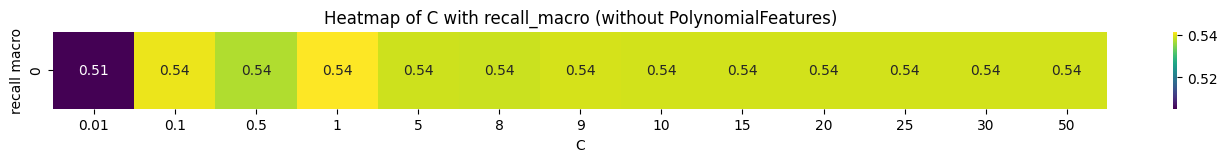

In [ ]:
scores_logreg_c = logreg_final_search.cv_results_['mean_test_score']
scores_logreg_c = scores_logreg_c.reshape(1, len(param_grid_logreg_smote['logreg__C']))

plt.figure(figsize=(17, 1))
sns.heatmap(scores_logreg_c, annot=True, xticklabels=param_grid_logreg_smote['logreg__C'], cmap='viridis')
plt.title('Heatmap of C with recall_macro (without PolynomialFeatures)')
plt.xlabel('C')
plt.ylabel('recall macro')
plt.show()

We can observe the same results on the validation curve.

In [ ]:
param_range_vc_logreg = [0.01, 0.1, 0.5, 1, 5, 8, 9, 10, 15, 20, 25, 30, 50]
train_vc_logreg_c, val_vc_logreg_c = validation_curve(logreg_hyperparams_search.best_estimator_, x_combined, y_combined, param_name="logreg__C",
                                                      param_range=param_range_vc_logreg, cv=ps, scoring="recall_macro", n_jobs=-1)

index_max_logreg_c = np.where(val_vc_logreg_c == max(val_vc_logreg_c))

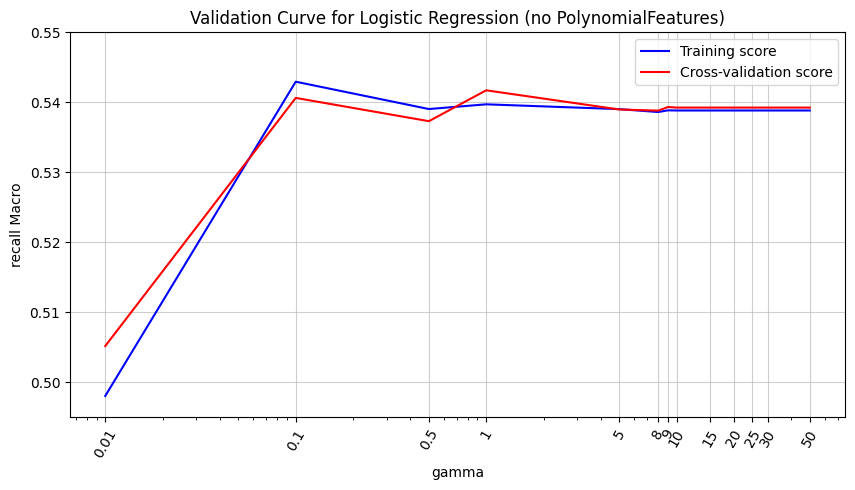

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Validation Curve for Logistic Regression (no PolynomialFeatures)', fontsize=12)
plt.xlabel('gamma')
plt.ylabel('recall Macro')

plt.plot(param_range_vc_logreg, train_vc_logreg_c, label='Training score', color='blue')
plt.plot(param_range_vc_logreg, val_vc_logreg_c, label='Cross-validation score', color='red')
plt.legend(loc='best')
plt.xscale('log')
plt.xticks(ticks=param_range_vc_logreg, labels=param_range_vc_logreg, rotation=60)
plt.ylim(0.495, 0.55)
plt.grid(True, alpha=0.6)
plt.show()

Now we will use the data with applied polynomialfeatures to confirm this value.

In [ ]:
'''logreg_pipe = ImbPipeline([('logreg', logreg_hyperparams_search.best_estimator_['logreg'])])

validation_fold = [-1 for _ in range(x_train_pwr_smote_poly.shape[0])] + [0 for _ in range(x_val_pwr_poly.shape[0])]
ps = PredefinedSplit(test_fold=validation_fold)

param_grid_logreg_smote = {'logreg__C' : [0.1, 1, 10, 20]}

logreg_final_search = GridSearchCV(logreg_pipe, param_grid=param_grid_logreg_smote, cv=ps, scoring=scoring, refit='recall_macro',
                                   return_train_score=True, n_jobs=-1)

logreg_final_search.fit(x_combined_processed, y_combined_processed)'''

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(max_iter=100000,
                                                           multi_class='multinomial',
                                                           n_jobs=-1,
                                                           penalty='l1',
                                                           solver='saga'))]),
             n_jobs=-1, param_grid={'logreg__C': [0.1, 1, 10, 20]},
             return_train_score=True, scoring='recall_macro')

In [ ]:
'''print('best C:           ', logreg_final_search.best_params_)
print('best recall_macro:', logreg_final_search.best_score_)

results_logreg = pd.DataFrame(logreg_final_search.cv_results_)
display(results_logreg)'''

"print('best C:           ', logreg_final_search.best_params_)\nprint('best recall_macro:', logreg_final_search.best_score_)\n\nresults_logreg = pd.DataFrame(logreg_final_search.cv_results_)\ndisplay(results_logreg)"

Thus, we will set C=20.

Thus, we got the best possible hyperparameters of Logistic regression for our problem.  
Let's now evaluate it on the actual test data. (using PolynomialFeatures with degree=3)

In [ ]:
logreg_hyperparams_search.best_estimator_['logreg'].set_params(C = logreg_final_search.best_params_['logreg__C'])
logreg_best = logreg_hyperparams_search.best_estimator_['logreg']
print(logreg_best)

LogisticRegression(C=1, max_iter=100000, multi_class='multinomial', n_jobs=-1,
                   penalty='l1', solver='saga')


We will evaluate the final model with PolynomialFeatures(degree=2), because degree=3 will take a lot of time. However, recall_macro will be noticeably higher for degree=3. (As we have observed above)

In [ ]:
logreg_pipe_best = ImbPipeline([('scaler', PowerTransformer()),
                                ('sampler', best_smote_logreg),
                                ('poly', PolynomialFeatures(degree=2)),
                                ('logreg', logreg_best)],
                                verbose=True)

logreg_pipe_best.fit(x_train, y_train)

[Pipeline] ............ (step 1 of 4) Processing scaler, total=   0.4s
[Pipeline] ........... (step 2 of 4) Processing sampler, total=   0.1s
[Pipeline] .............. (step 3 of 4) Processing poly, total=   0.2s
[Pipeline] ............ (step 4 of 4) Processing logreg, total=69.6min


Pipeline(steps=[('scaler', PowerTransformer()),
                ('sampler', SMOTE(k_neighbors=1, random_state=73)),
                ('poly', PolynomialFeatures()),
                ('logreg',
                 LogisticRegression(C=20, max_iter=100000,
                                    multi_class='multinomial', n_jobs=-1,
                                    penalty='l1', solver='saga'))],
         verbose=True)

In [ ]:
y_pred_logreg_train = logreg_pipe_best.predict(x_train)
y_pred_logreg_test = logreg_pipe_best.predict(x_test)

print('Logistic Regression evaluation results on TEST data')
print('recall_macro: ', recall_score(y_test, y_pred_logreg_test, average='macro'))
print('f1_macro: ', f1_score(y_test, y_pred_logreg_test, average='macro'))
print('Cohens Kappa: ', cohen_kappa_score(y_test, y_pred_logreg_test))
print()
print('Logistic Regression evaluation results on TRAIN data')
print('recall_macro: ', recall_score(y_train, y_pred_logreg_train, average='macro'))
print('f1_macro: ', f1_score(y_train, y_pred_logreg_train, average='macro'))
print('Cohens Kappa: ', cohen_kappa_score(y_train, y_pred_logreg_train))

Logistic Regression evaluation results on TEST data
recall_macro:  0.7509034331831828
f1_macro:  0.6794764462565702
Cohens Kappa:  0.6449882179647242

Logistic Regression evaluation results on TRAIN data
recall_macro:  0.772993480201668
f1_macro:  0.6991769752782042
Cohens Kappa:  0.6680301838194032


Confusion matrix

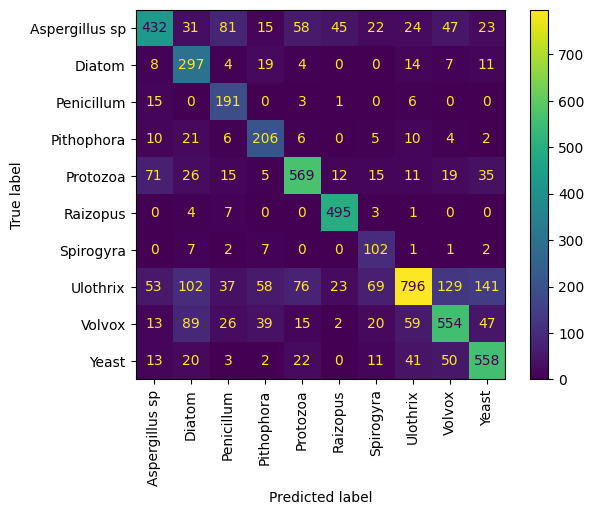

In [ ]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=logreg_pipe_best.classes_)
disp.plot(cmap='viridis')
plt.xticks(rotation=90)
plt.show()

Lets now determine the most missclassified class.

In [ ]:
misclassifications = np.sum(cm_logreg, axis=1) - np.diag(cm_logreg)
mc_index = np.argmax(misclassifications)
print(logreg_pipe_best.classes_[mc_index])

Ulothrix


Learning curve for Logistic Regression. (We didn't include PolynomialFeatures to save a lot of time. Results for data with it applied will look approximately the same)

In [ ]:
learning_curve_logreg_pipeline = ImbPipeline([('scaler', PowerTransformer()),
                                             ('sampler', SMOTE(k_neighbors=1, random_state=73)),
                                             ('logreg', LogisticRegression(C=1, max_iter=100000, multi_class='multinomial', n_jobs=-1, penalty='l1', solver='saga'))])

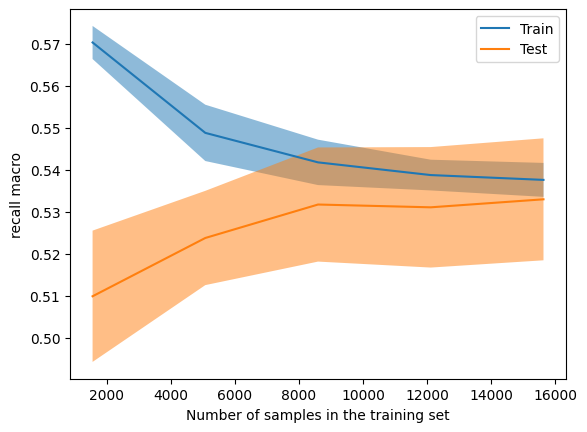

In [ ]:
learning_curve_logreg = LearningCurveDisplay.from_estimator(learning_curve_logreg_pipeline, x_train, y_train, cv=skf, scoring='recall_macro', n_jobs=-1,
                                              random_state=73, score_name='recall macro', score_type='both', std_display_style='fill_between')

And finally we compute logistic loss.

In [ ]:
y_pred_proba_test_logreg = logreg_pipe_best.predict_proba(x_test)
logloss_logreg = log_loss(y_test, y_pred_proba_test_logreg, labels=np.unique(y_test))
print(logloss_logreg)

0.9224897583133067


The reason for such a high log_loss (given that recall is relatively good) might be that predicted probabilities for different classes sre not big (i.e. model is not 100% sure what class to assign)

### SVC

In [ ]:
from sklearn.svm import SVC

We start with baseline model.

In [ ]:
scalers_svc = [StandardScaler(),
               RobustScaler(),
               PowerTransformer(method='yeo-johnson'),
               QuantileTransformer(output_distribution='uniform'),
               QuantileTransformer(output_distribution='normal')
               ]

x_train_scaled_svc = [x_train, ]
x_val_scaled_svc = [x_val, ]

for scaler in scalers_svc:
    x_train_scaled_svc.append(pd.DataFrame(scaler.fit_transform(x_train)))
    x_val_scaled_svc.append(pd.DataFrame(scaler.transform(x_val)))

list_of_scalers_svc = [
    'No scaling',
    'StandardScaler',
    'RobustScaler',
    'PowerTransformer',
    'QuantileTransformer (uniform)',
    'QuantileTransformer (normal)'
    ]

data_scalers = {
    'Scaler': None,
    'macro recall train': None,
    'macro recall validation': None,
    'macro f1 train': None,
    'macro f1 validation': None,
    'Cohens Kappa train': None,
    'Cohens Kappa validation': None,
}

svc_quick_scores = pd.DataFrame(data=data_scalers, index=np.arange(len(list_of_scalers_svc)))

In [ ]:
for count, (x_train_scale, x_val_scale) in enumerate(zip(x_train_scaled_svc, x_val_scaled_svc)):

    svc_base = SVC()
    svc_base.fit(x_train_scale, y_train)

    svc_quick_scores.loc[count] = [
        list_of_scalers_svc[count],
        recall_score(y_train, svc_base.predict(x_train_scale), average='macro'),
        recall_score(y_val, svc_base.predict(x_val_scale), average='macro'),
        f1_score(y_train, svc_base.predict(x_train_scale), average='macro'),
        f1_score(y_val, svc_base.predict(x_val_scale), average='macro'),
        cohen_kappa_score(y_train, svc_base.predict(x_train_scale)),
        cohen_kappa_score(y_val, svc_base.predict(x_val_scale))
        ]

In [ ]:
display(svc_quick_scores)

Scaler macro recall train macro recall validation  \
0                     No scaling           0.385256                0.392531   
1                 StandardScaler           0.580233                0.568247   
2                   RobustScaler           0.437864                0.437732   
3               PowerTransformer            0.65221                0.630043   
4  QuantileTransformer (uniform)           0.650058                0.637503   
5   QuantileTransformer (normal)           0.644459                0.627432   

  macro f1 train macro f1 validation Cohens Kappa train  \
0       0.389674            0.397857           0.427136   
1       0.614663            0.597831           0.603079   
2       0.450545            0.444918           0.471766   
3       0.679627            0.651933           0.657557   
4       0.673919            0.654644           0.656516   
5       0.672774            0.648444           0.653346   

  Cohens Kappa validation  
0                 0.43277  
1                0.590076  
2                0.469687  
3                0.636197  
4                0.641725  
5                0.634158

QuantileTransformer (uniform) has proven to be the best option for SVC.

Now we will see if resampling affects the performance of the baseline model.  
Again, we first evaluate the optimal number of k_neighbors for SMOTE.

In [ ]:
# using PredefinedSplit()

smote_pipe_svc = ImbPipeline([
    ('smote', SMOTE(random_state=73)),
    ('scaler', QuantileTransformer(output_distribution='uniform')),
    ('svc', SVC())
])

validation_fold = [-1 for sample in range(x_train.shape[0])] + [0 for sample in range(x_val.shape[0])]
ps = PredefinedSplit(test_fold=validation_fold)

param_grid_svc = {'smote__k_neighbors': np.arange(1, 21, 1)} # from 1 to 20 (incl.)
smote_grid_svc = GridSearchCV(smote_pipe_svc, param_grid=param_grid_svc, scoring=scoring, refit='recall_macro', cv=ps, n_jobs=-1, verbose=1)

smote_grid_svc.fit(x_combined, y_combined)

Fitting 1 folds for each of 20 candidates, totalling 20 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=73)),
                                       ('scaler', QuantileTransformer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'smote__k_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             refit='recall_macro',
             scoring={'cohen_kappa': make_scorer(cohen_kappa),
                      'f1_macro': 'f1_macro', 'recall_macro': 'recall_macro'},
             verbose=1)

In [ ]:
print('best parameters: ', smote_grid_svc.best_params_)
print('best recall_macro: ', smote_grid_svc.best_score_)

best parameters:  {'smote__k_neighbors': 6}
best recall_macro:  0.7657156808097003


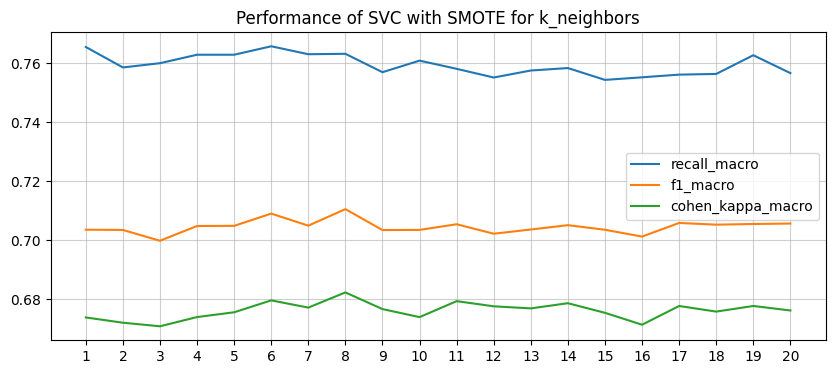

In [ ]:
svc_smote_results = pd.DataFrame(smote_grid_svc.cv_results_)

svc_smote_plot_recall = svc_smote_results['mean_test_recall_macro']
svc_smote_plot_f1 = svc_smote_results['mean_test_f1_macro']
svc_smote_plot_kappa = svc_smote_results['mean_test_cohen_kappa']
svc_smote_plot_neighbors = svc_smote_results['param_smote__k_neighbors']

plt.figure(figsize=(10,4))
plt.style.use('default')
plt.title('Performance of SVC with SMOTE for k_neighbors', fontsize=12)
plt.plot(svc_smote_plot_neighbors, svc_smote_plot_recall, label='recall_macro')
plt.plot(svc_smote_plot_neighbors, svc_smote_plot_f1, label='f1_macro')
plt.plot(svc_smote_plot_neighbors, svc_smote_plot_kappa, label='cohen_kappa_macro')
plt.xticks(ticks=np.arange(1, 21, 1))
plt.grid(True, alpha=0.6)
plt.legend(loc='best')
plt.show()

In [ ]:
best_smote_svc = SMOTE(k_neighbors=smote_grid_svc.best_params_['smote__k_neighbors'], random_state=73)

Now we iteratively evaluate the model on resampled data.

In [ ]:
initial_svc = ImbPipeline([('scaler', PowerTransformer()),
                           ('svc', SVC())])

undersampled_svc = ImbPipeline([('scaler', PowerTransformer()),
                                ('sampler', RandomUnderSampler(random_state=73)),
                                ('svc', SVC())])

smoted_svc = ImbPipeline([('scaler', PowerTransformer()),
                          ('sampler', best_smote_svc),
                          ('svc', SVC())])

balanced_svc = ImbPipeline([('scaler', PowerTransformer()),
                           ('svc', SVC(class_weight='balanced'))])

svc_pipes = [initial_svc, undersampled_svc, smoted_svc, balanced_svc]

svc_data = {
    'resampler': None,
    'macro recall train': None,
    'macro recall validation': None,
    'macro f1 train': None,
    'macro f1 validation': None,
    'Cohens Kappa train': None,
    'Cohens Kappa validation': None,
}

svc_resample_scores = pd.DataFrame(data=svc_data, index=np.arange(len(svc_pipes)))
resamplers = ['No resampling', 'RandomUnderSampler', 'SMOTE', 'class_weight=balanced']

for index, pipe in enumerate(svc_pipes):

    pipe.fit(x_train, y_train)

    svc_resample_scores.loc[index] = [
        resamplers[index],
        recall_score(y_train, pipe.predict(x_train), average='macro'),
        recall_score(y_val, pipe.predict(x_val), average='macro'),
        f1_score(y_train, pipe.predict(x_train), average='macro'),
        f1_score(y_val, pipe.predict(x_val), average='macro'),
        cohen_kappa_score(y_train, pipe.predict(x_train)),
        cohen_kappa_score(y_val, pipe.predict(x_val))
        ]


In [ ]:
display(svc_resample_scores)

resampler macro recall train macro recall validation  \
0          No resampling            0.65221                0.630043   
1     RandomUnderSampler           0.621723                0.617272   
2                  SMOTE             0.7882                0.757953   
3  class_weight=balanced           0.731493                0.712076   

  macro f1 train macro f1 validation Cohens Kappa train  \
0       0.679627            0.651933           0.657557   
1       0.546359            0.547576           0.505316   
2       0.729844            0.702448           0.699619   
3       0.661719            0.647908           0.626136   

  Cohens Kappa validation  
0                0.636197  
1                0.505912  
2                0.674501  
3                0.610522

Finally, we fine-tune the svc.  
One of the most important hyperparameters is kernel.

In [ ]:
svc_pipe_kernel = ImbPipeline([('scaler', PowerTransformer()),
                              ('sampler', best_smote_svc),
                              ('svc', SVC(degree=2))])

validation_fold = [-1 for _ in range(x_train.shape[0])] + [0 for _ in range(x_val.shape[0])]
ps = PredefinedSplit(test_fold=validation_fold)
param_grid_svc_kernel = {'svc__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                         'svc__decision_function_shape' : ['ovo', 'ovr']}

svc_grid_kernel = GridSearchCV(svc_pipe_kernel, param_grid=param_grid_svc_kernel, cv=ps, scoring=scoring, refit='recall_macro', return_train_score=True, n_jobs=-1, verbose=1)

svc_grid_kernel.fit(x_combined, y_combined)

Fitting 1 folds for each of 8 candidates, totalling 8 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('scaler', PowerTransformer()),
                                       ('sampler',
                                        SMOTE(k_neighbors=6, random_state=73)),
                                       ('svc', SVC(degree=2))]),
             n_jobs=-1,
             param_grid={'svc__decision_function_shape': ['ovo', 'ovr'],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             refit='recall_macro', return_train_score=True,
             scoring={'cohen_kappa': make_scorer(cohen_kappa),
                      'f1_macro': 'f1_macro', 'recall_macro': 'recall_macro'},
             verbose=1)

In [ ]:
print('best parameters: ', svc_grid_kernel.best_params_)
print('best recall macro: ', svc_grid_kernel.best_score_)

results_svc = pd.DataFrame(svc_grid_kernel.cv_results_)
display(results_svc)

best parameters:  {'svc__decision_function_shape': 'ovo', 'svc__kernel': 'rbf'}
best recall macro:  0.7610739541423527


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     316.732331           0.0         9.291023             0.0   
1     218.007130           0.0        15.066958             0.0   
2     140.367793           0.0        30.986273             0.0   
3     274.935702           0.0        23.936586             0.0   
4     316.378272           0.0         8.924854             0.0   
5     220.986834           0.0        15.875787             0.0   
6     140.515189           0.0        30.594944             0.0   
7     274.919144           0.0        24.537833             0.0   

  param_svc__decision_function_shape param_svc__kernel  \
0                                ovo            linear   
1                                ovo              poly   
2                                ovo               rbf   
3                                ovo           sigmoid   
4                                ovr            linear   
5                                ovr              poly   
6                                ovr               rbf   
7                                ovr           sigmoid   

                                              params  split0_test_score  \
0  {'svc__decision_function_shape': 'ovo', 'svc__...           0.581007   
1  {'svc__decision_function_shape': 'ovo', 'svc__...           0.622236   
2  {'svc__decision_function_shape': 'ovo', 'svc__...           0.761074   
3  {'svc__decision_function_shape': 'ovo', 'svc__...           0.158647   
4  {'svc__decision_function_shape': 'ovr', 'svc__...           0.581007   
5  {'svc__decision_function_shape': 'ovr', 'svc__...           0.622236   
6  {'svc__decision_function_shape': 'ovr', 'svc__...           0.761074   
7  {'svc__decision_function_shape': 'ovr', 'svc__...           0.158647   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.581007             0.0                5            0.580672   
1         0.622236             0.0                3            0.632409   
2         0.761074             0.0                1            0.788769   
3         0.158647             0.0                7            0.162411   
4         0.581007             0.0                5            0.580672   
5         0.622236             0.0                3            0.632409   
6         0.761074             0.0                1            0.788769   
7         0.158647             0.0                7            0.162411   

   mean_train_score  std_train_score  
0          0.580672              0.0  
1          0.632409              0.0  
2          0.788769              0.0  
3          0.162411              0.0  
4          0.580672              0.0  
5          0.632409              0.0  
6          0.788769              0.0  
7          0.162411              0.0

With the best kernel evaluated, we proceed to search for another hyperparameters, that can significantly affect model's performance.  
(Remark: the choice of values for hyperparameters is not random. We extracted these values from a much bigger GridSearchCV)

In [ ]:
svc_pipe_hyper = ImbPipeline([('scaler', PowerTransformer()),
                              ('sampler', best_smote_svc),
                              ('svc', SVC(kernel='rbf', decision_function_shape='ovo'))])

param_grid_svc_gamma_c = {'svc__C' : np.arange(1, 31, 1),
                          'svc__gamma' : [0.01, 0.1, 1]}

validation_fold = [-1 for _ in range(x_train.shape[0])] + [0 for _ in range(x_val.shape[0])]
ps = PredefinedSplit(test_fold=validation_fold)

svc_grid_hyper = GridSearchCV(svc_pipe_hyper, param_grid=param_grid_svc_gamma_c, cv=ps, scoring=scoring, refit='recall_macro', return_train_score=True, n_jobs=-1, verbose=1)

svc_grid_hyper.fit(x_combined, y_combined)

Fitting 1 folds for each of 90 candidates, totalling 90 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('scaler', PowerTransformer()),
                                       ('sampler',
                                        SMOTE(k_neighbors=1, random_state=73)),
                                       ('svc',
                                        SVC(decision_function_shape='ovo'))]),
             n_jobs=-1,
             param_grid={'svc__C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                         'svc__gamma': [0.01, 0.1, 1]},
             return_train_score=True, scoring='recall_macro', verbose=1)

In [ ]:
print('best parameters: ', svc_grid_hyper.best_params_)
print('best recall_macro: ', svc_grid_hyper.best_score_)

results_svc_gamma_c = pd.DataFrame(svc_grid_hyper.cv_results_)
display(results_svc_gamma_c)

best parameters:  {'svc__C': 29, 'svc__gamma': 0.1}
best recall_macro:  0.9638473911890056


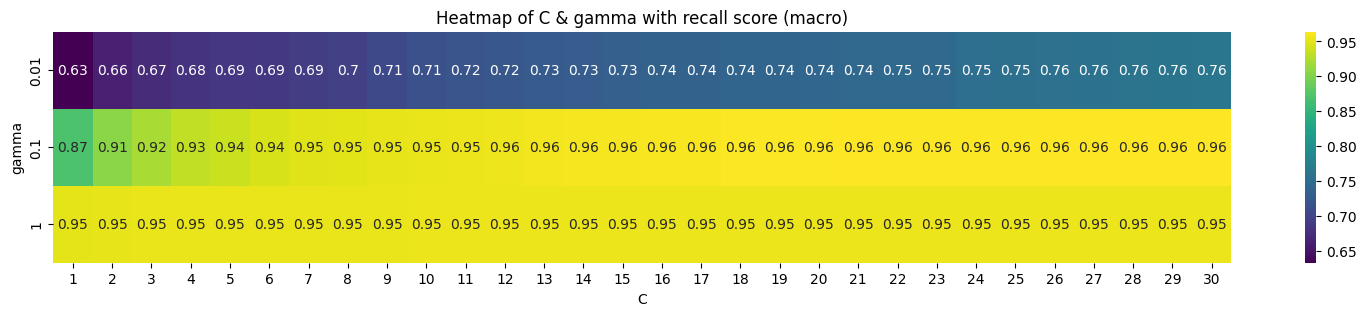

In [ ]:
scores_svc_grid = svc_grid_hyper.cv_results_['mean_test_score']
scores_svc_grid = scores_svc_grid.reshape(len(param_grid_svc_gamma_c['svc__C']), len(param_grid_svc_gamma_c['svc__gamma'])).T

# Plotting the heatmap
plt.figure(figsize=(19, 2.5))
sns.heatmap(scores_svc_grid, annot=True, xticklabels=param_grid_svc_gamma_c['svc__C'], yticklabels=param_grid_svc_gamma_c['svc__gamma'], cmap='viridis')
plt.title('Heatmap of C & gamma with recall score (macro)')
plt.xlabel('C')
plt.ylabel('gamma')
plt.show()

We see that gamma between 0.1 and 1.0 gives us very good results.  
Thus, we will look at these parameters more closely. However, instead of using GridSearchCV with a set of values for hyperparameters with a very small step, we will look at them analytically. It might not be 100% right approach, but it will save us considerable amount of time.

In [ ]:
print(svc_grid_hyper.best_estimator_)

Pipeline(steps=[('scaler', PowerTransformer()),
                ('sampler', SMOTE(k_neighbors=1, random_state=73)),
                ('svc', SVC(C=29, decision_function_shape='ovo', gamma=0.1))])


First, we will look at the gamma hyperparameter.

In [ ]:
param_range_vc_svc = np.arange(0.08, 0.205, 0.005)
train_vc_svc_gamma, val_vc_svc_gamma = validation_curve(svc_grid_hyper.best_estimator_, x_combined, y_combined, param_name="svc__gamma",
                                                      param_range=param_range_vc_svc, cv=ps, scoring="recall_macro", n_jobs=-1)

index_max_gamma = np.where(val_vc_svc_gamma == max(val_vc_svc_gamma))

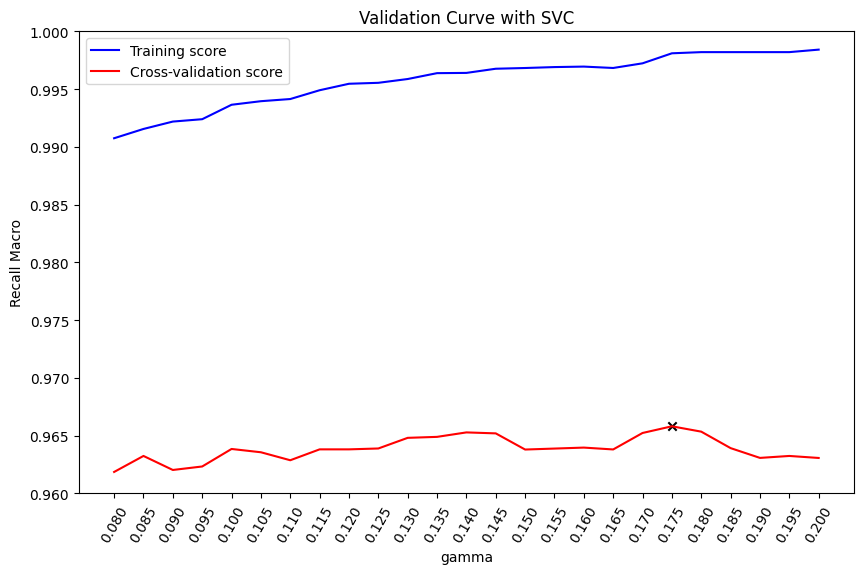

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Validation Curve with SVC')
plt.xlabel('gamma')
plt.ylabel('Recall Macro')
plt.ylim(0.0, 1.1)

plt.scatter(param_range_vc_svc[index_max_gamma[0]], val_vc_svc_gamma[index_max_gamma[0]], color='black', marker='x')

plt.plot(param_range_vc_svc, train_vc_svc_gamma, label='Training score', color='blue')
plt.plot(param_range_vc_svc, val_vc_svc_gamma, label='Cross-validation score', color='red')
plt.legend(loc='best')
plt.xticks(param_range_vc_svc, rotation=60)
plt.ylim(0.960, 1.000)
plt.show()

In [ ]:
svc_grid_hyper.best_estimator_['svc'].set_params(gamma = 0.175)

SVC(C=29, decision_function_shape='ovo', gamma=0.175)

Now with the found optimal value for gamma, we will check how different values of C will change the recall.  
(Remark: the values for C are relatively small because the higher values brings overfitting)

In [ ]:
param_range_vc_svc = np.arange(25, 41, 1)
train_vc_svc_c, val_vc_svc_c = validation_curve(svc_grid_hyper.best_estimator_, x_combined, y_combined, param_name="svc__C",
                                                      param_range=param_range_vc_svc, cv=ps, scoring="recall_macro", n_jobs=-1)

index_max_c = np.where(val_vc_svc_c == max(val_vc_svc_c))


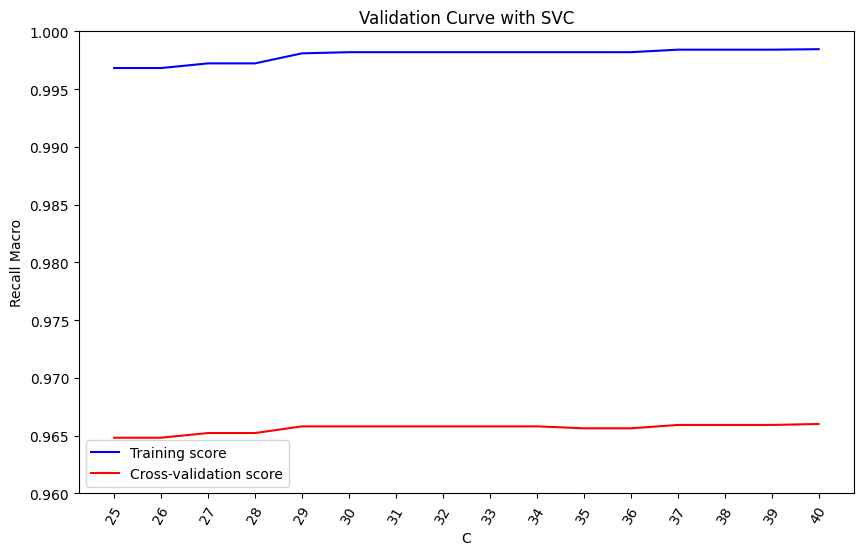

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Validation Curve with SVC')
plt.xlabel('C')
plt.ylabel('Recall Macro')
plt.ylim(0.0, 1.1)

plt.plot(param_range_vc_svc, train_vc_svc_c, label='Training score', color='blue')
plt.plot(param_range_vc_svc, val_vc_svc_c, label='Cross-validation score', color='red')
plt.legend(loc='best')
plt.xticks(param_range_vc_svc, rotation=60)
plt.ylim(0.960, 1.000)
plt.show()

Thus, we evaluate the SVC with best found preprocessing methods and hyperparameters on the actual test data.

In [ ]:
svc_grid_hyper.best_estimator_['svc'].set_params(C = 29)
svc_best = svc_grid_hyper.best_estimator_
svc_best.fit(x_train, y_train)

Pipeline(steps=[('scaler', PowerTransformer()),
                ('sampler', SMOTE(k_neighbors=1, random_state=73)),
                ('svc', SVC(C=29, decision_function_shape='ovo', gamma=0.175))])

In [ ]:
y_pred_svc_test = svc_best.predict(x_test)
y_pred_svc_train = svc_best.predict(x_train)

print('evaluation results on TRAIN data')
print('recall_macro: ', recall_score(y_train, y_pred_svc_train, average='macro'))
print('f1_macro: ', f1_score(y_train, y_pred_svc_train, average='macro'))
print('Cohens Kappa: ', cohen_kappa_score(y_train, y_pred_svc_train))
print()
print('evaluation results on TEST data')
print('recall_macro: ', recall_score(y_test, y_pred_svc_test, average='macro'))
print('f1_macro: ', f1_score(y_test, y_pred_svc_test, average='macro'))
print('Cohens Kappa: ', cohen_kappa_score(y_test, y_pred_svc_test))

evaluation results on TRAIN data
recall_macro:  0.9981045150775266
f1_macro:  0.9963279806393046
Cohens Kappa:  0.9969667879020742

evaluation results on TEST data
recall_macro:  0.9628287997891467
f1_macro:  0.9662545875551869
Cohens Kappa:  0.9760213004366903


There is a considerable overfitting, however, given the complexity of given dataset, we will ussume it neglectable.

Learning Curve SVC

Finally, we will see how different amount of training data affects evaluation results.

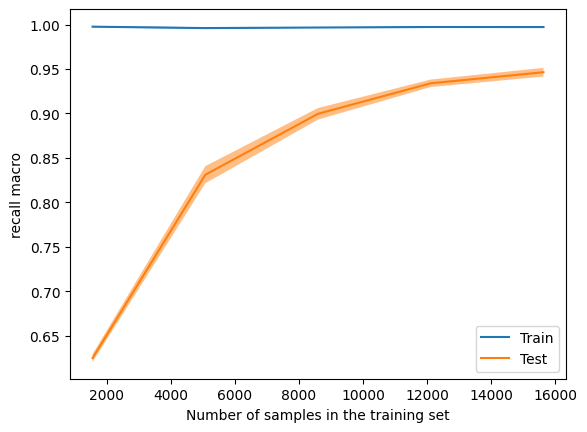

In [ ]:
learning_curve_svc = LearningCurveDisplay.from_estimator(svc_best, x_train, y_train, cv=skf, scoring='recall_macro', n_jobs=-1,
                                              random_state=73, score_name='recall macro', score_type='both', std_display_style='fill_between')

Confusion matrix

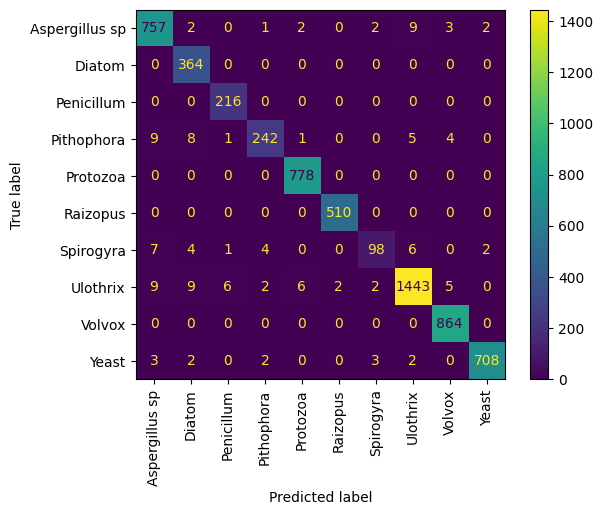

In [ ]:
cm_svc = confusion_matrix(y_test, y_pred_svc_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=svc_best.classes_)
disp.plot(cmap='viridis')
plt.xticks(rotation=90)
plt.show()

### MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
scalers_mlp = [StandardScaler(),
               RobustScaler(),
               PowerTransformer(method='yeo-johnson'),
               QuantileTransformer(output_distribution='uniform'),
               QuantileTransformer(output_distribution='normal')
               ]

list_of_scalers_mlp = [
    'No scaling',
    'StandardScaler',
    'RobustScaler',
    'PowerTransformer',
    'QuantileTransformer (uniform)',
    'QuantileTransformer (normal)'
    ]

mlp_quick_scores = pd.DataFrame(data=data_scalers, index=np.arange(len(list_of_scalers_mlp)))

x_train_scaled_mlp = [x_train, ]
x_val_scaled_mlp = [x_val, ]

for scaler in scalers_mlp:
    x_train_scaled_mlp.append(pd.DataFrame(scaler.fit_transform(x_train)))
    x_val_scaled_mlp.append(pd.DataFrame(scaler.transform(x_val)))

In [ ]:
for count, (x_train_scale, x_val_scale) in enumerate(zip(x_train_scaled_mlp, x_val_scaled_mlp)):

    mlp_base = MLPClassifier(max_iter=10_000)
    mlp_base.fit(x_train_scale, y_train)

    mlp_quick_scores.loc[count] = [
        list_of_scalers_mlp[count],
        recall_score(y_train, mlp_base.predict(x_train_scale), average='macro'),
        recall_score(y_val, mlp_base.predict(x_val_scale), average='macro'),
        f1_score(y_train, mlp_base.predict(x_train_scale), average='macro'),
        f1_score(y_val, mlp_base.predict(x_val_scale), average='macro'),
        cohen_kappa_score(y_train, mlp_base.predict(x_train_scale)),
        cohen_kappa_score(y_val, mlp_base.predict(x_val_scale))
        ]

In [ ]:
display(mlp_quick_scores)

Scaler macro recall train macro recall validation  \
0                     No scaling           0.660624                 0.63685   
1                 StandardScaler           0.846225                0.803185   
2                   RobustScaler           0.856303                0.818428   
3               PowerTransformer           0.838966                0.802191   
4  QuantileTransformer (uniform)           0.729671                0.721514   
5   QuantileTransformer (normal)           0.851142                0.817112   

  macro f1 train macro f1 validation Cohens Kappa train  \
0       0.688222            0.656836           0.657581   
1        0.85219            0.808808            0.84911   
2       0.867477            0.827005           0.862423   
3       0.849957            0.811613           0.838684   
4       0.739623            0.726085           0.706028   
5       0.864679            0.825279           0.858706   

  Cohens Kappa validation  
0                0.632798  
1                0.803665  
2                0.820294  
3                0.798712  
4                0.687668  
5                0.819111

We add RobustScaler() to pipeline.  
We already got decent results (for a base model).  
Thus, we proceed to tweak other steps in pipeline, starting with resampling.  

But first, we need to find optimal k_neighbors for SMOTE specifically for mlp.

In [ ]:
smote_pipe_mlp = ImbPipeline([
    ('smote', SMOTE(random_state=73)),
    ('scaler', RobustScaler()),
    ('mlp', MLPClassifier(max_iter=10_000))
])

validation_fold = [-1 for _ in range(x_train.shape[0])] + [0 for _ in range(x_val.shape[0])]
ps = PredefinedSplit(test_fold=validation_fold)

param_grid_mlp = {'smote__k_neighbors': np.arange(1, 21, 1)}
smote_grid_mlp = GridSearchCV(smote_pipe_mlp, param_grid=param_grid_mlp, scoring=scoring, refit='recall_macro', cv=ps, n_jobs=-1)

smote_grid_mlp.fit(x_combined, y_combined)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=73)),
                                       ('scaler', RobustScaler()),
                                       ('mlp', MLPClassifier(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'smote__k_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='recall_macro')

In [ ]:
print('best parameters: ', smote_grid_mlp.best_params_)
print('best recall_macro: ', smote_grid_mlp.best_score_)

best parameters:  {'smote__k_neighbors': 1}
best recall_macro:  0.8815143844075038


In [ ]:
best_smote_mlp = SMOTE(k_neighbors=smote_grid_mlp.best_params_['smote__k_neighbors'])

In [ ]:
initial_mlp = ImbPipeline([('scaler', RobustScaler()),
                           ('mlp', MLPClassifier(max_iter=10_000))])

undersampled_mlp = ImbPipeline([('scaler', RobustScaler()),
                                ('sampler', RandomUnderSampler()),
                                ('mlp', MLPClassifier(max_iter=10_000))])

smoted_mlp = ImbPipeline([('scaler', RobustScaler()),
                          ('sampler', best_smote_mlp),
                          ('mlp', MLPClassifier(max_iter=10_000))])

mlp_data = {
    'resampler': None,
    'macro recall train': None,
    'macro recall validation': None,
    'macro f1 train': None,
    'macro f1 validation': None,
    'Cohens Kappa train': None,
    'Cohens Kappa validation': None,
}

mlp_pipes = [initial_mlp, undersampled_mlp, smoted_mlp]

mlp_resample_scores = pd.DataFrame(data=mlp_data, index=np.arange(len(mlp_pipes)))
resamplers = ['No resampling', 'RandomUnderSampler', 'SMOTE']

for index, pipe in enumerate(mlp_pipes):

    pipe.fit(x_train, y_train)

    mlp_resample_scores.loc[index] = [
        resamplers[index],
        recall_score(y_train, pipe.predict(x_train), average='macro'),
        recall_score(y_val, pipe.predict(x_val), average='macro'),
        f1_score(y_train, pipe.predict(x_train), average='macro'),
        f1_score(y_val, pipe.predict(x_val), average='macro'),
        cohen_kappa_score(y_train, pipe.predict(x_train)),
        cohen_kappa_score(y_val, pipe.predict(x_val))
        ]

In [ ]:
display(mlp_resample_scores)

resampler macro recall train macro recall validation  \
0       No resampling           0.862991                0.834359   
1  RandomUnderSampler           0.789557                0.770349   
2               SMOTE           0.920449                0.882732   

  macro f1 train macro f1 validation Cohens Kappa train  \
0       0.869563            0.840513           0.865141   
1       0.716812            0.701569           0.683754   
2       0.889162            0.850776           0.863103   

  Cohens Kappa validation  
0                0.828926  
1                0.668649  
2                0.825734

With all optimal preprocessing steps found, we proceed with fine-tuning.  
First, we need to make an overfitting model. Then apply several techniques to reduce overfitting.

For now, we set alpha=0.

In [ ]:
mlp_pipe_final = ImbPipeline([('scaler', RobustScaler()),
                              ('sampler', best_smote_svc),
                              ('mlp', MLPClassifier(hidden_layer_sizes=(100, 60, 45), solver='adam',
                                                    learning_rate_init=0.001, tol=0.00001, alpha=0, n_iter_no_change=20, max_iter=100_000, verbose=1))])

mlp_pipe_final.fit(x_train, y_train)

Iteration 1, loss = 1.65583971
Iteration 2, loss = 1.17569612
Iteration 3, loss = 1.02582247
Iteration 4, loss = 0.92647924
Iteration 5, loss = 0.85065227
Iteration 6, loss = 0.78785316
Iteration 7, loss = 0.73827047
Iteration 8, loss = 0.69395283
Iteration 9, loss = 0.65143951
Iteration 10, loss = 0.61594873
Iteration 11, loss = 0.58127783
Iteration 12, loss = 0.55119163
Iteration 13, loss = 0.53165467
Iteration 14, loss = 0.50012359
Iteration 15, loss = 0.47415338
Iteration 16, loss = 0.45613753
Iteration 17, loss = 0.43969697
Iteration 18, loss = 0.42114570
Iteration 19, loss = 0.40452325
Iteration 20, loss = 0.39006735
Iteration 21, loss = 0.37229321
Iteration 22, loss = 0.36096058
Iteration 23, loss = 0.34895166
Iteration 24, loss = 0.33847772
Iteration 25, loss = 0.32700217
Iteration 26, loss = 0.31347266
Iteration 27, loss = 0.30442524
Iteration 28, loss = 0.29855414
Iteration 29, loss = 0.29041519
Iteration 30, loss = 0.27830430
Iteration 31, loss = 0.27679841
Iteration 32, los

Pipeline(steps=[('scaler', RobustScaler()),
                ('sampler', SMOTE(k_neighbors=6, random_state=73)),
                ('mlp',
                 MLPClassifier(alpha=0, hidden_layer_sizes=(100, 60, 45),
                               max_iter=100000, n_iter_no_change=20, tol=1e-05,
                               verbose=1))])

In [ ]:
mlp_train_predictions = mlp_pipe_final.predict(x_train)
mlp_val_predictions = mlp_pipe_final.predict(x_val)

print("Training    accuracy:", recall_score(y_train, mlp_train_predictions, average='macro'))
print("Validation  accuracy:", recall_score(y_val, mlp_val_predictions, average='macro'))

Training    accuracy: 0.9983905907032872
Validation  accuracy: 0.9634850013041033


In [ ]:
rbscaler = RobustScaler()
x_train_robust = rbscaler.fit_transform(x_train)
x_val_robust = rbscaler.transform(x_val)

In [ ]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

mlp_partial_fit = MLPClassifier(hidden_layer_sizes=(100, 60, 45), solver='adam',
                                learning_rate_init=0.001, tol=0.00001, alpha=0, n_iter_no_change=20,
                                max_iter=100_000, verbose=1, warm_start=True)

for i in range(250):
  mlp_partial_fit.partial_fit(x_train_robust, y_train, classes=np.unique(y_train))

  train_proba = mlp_partial_fit.predict_proba(x_train_robust)
  train_losses.append(log_loss(y_train, train_proba))

  val_proba = mlp_partial_fit.predict_proba(x_val_robust)
  val_losses.append(log_loss(y_val, val_proba))

  train_acc.append(recall_score(y_train, mlp_partial_fit.predict(x_train_robust), average='macro'))
  val_acc.append(recall_score(y_val, mlp_partial_fit.predict(x_val_robust), average='macro'))

Iteration 1, loss = 1.84372275
Iteration 1, loss = 1.46845075
Iteration 1, loss = 1.32151474
Iteration 1, loss = 1.23507389
Iteration 1, loss = 1.17263567
Iteration 1, loss = 1.12177780
Iteration 1, loss = 1.07727001
Iteration 1, loss = 1.03410552
Iteration 1, loss = 0.98843878
Iteration 1, loss = 0.95828966
Iteration 1, loss = 0.92603885
Iteration 1, loss = 0.89648092
Iteration 1, loss = 0.87398928
Iteration 1, loss = 0.84342896
Iteration 1, loss = 0.82160020
Iteration 1, loss = 0.80335447
Iteration 1, loss = 0.77715070
Iteration 1, loss = 0.75996705
Iteration 1, loss = 0.74637003
Iteration 1, loss = 0.72610677
Iteration 1, loss = 0.70771663
Iteration 1, loss = 0.69042334
Iteration 1, loss = 0.67570921
Iteration 1, loss = 0.66938259
Iteration 1, loss = 0.64834871
Iteration 1, loss = 0.63216737
Iteration 1, loss = 0.62068964
Iteration 1, loss = 0.60823919
Iteration 1, loss = 0.60650314
Iteration 1, loss = 0.59374376
Iteration 1, loss = 0.57264959
Iteration 1, loss = 0.56369248
Iteratio

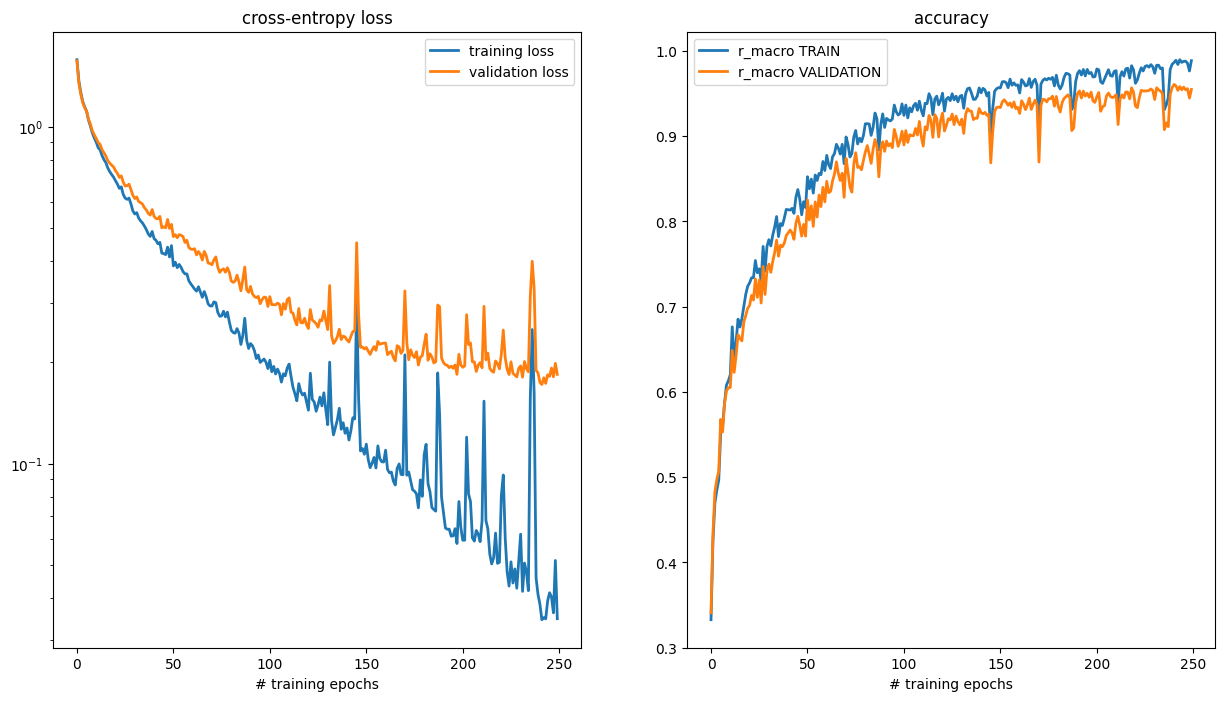

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 8))
axes[0].set_title("cross-entropy loss")
axes[0].plot(train_losses, label="training loss", lw=2)
axes[0].plot(val_losses, label="validation loss", lw=2)
axes[0].legend()
axes[0].set_yscale('log')

axes[1].set_title("accuracy")
axes[1].plot(train_acc, label="r_macro TRAIN", lw=2)
axes[1].plot(val_acc, label="r_macro VALIDATION", lw=2)
axes[1].legend()

axes[0].set_xlabel("# training epochs")
axes[1].set_xlabel("# training epochs")

plt.show()

We see that cross-entropy loss keeps getting lower with higher number of epochs. However, the steepness of the line with validation loss is decreasing, making a difference between train and validation loss bigger. It may be a sign of overfitting. (i.e. higher number of epochs -> more overfitting).  
However, we see that recall on both train and validation sets is getting higher without getting apart from each other too much.  
In addition, we see that higher jumps in recall and loss_function occur closer to higher number of epochs.  

Now we try the mode with bigger hidden layers to see if it can reduce overfitting.

In [ ]:
mlp_pipe_final_no_overfitting = ImbPipeline([('scaler', RobustScaler()),
                              ('sampler', best_smote_svc),
                              ('mlp', MLPClassifier(hidden_layer_sizes=(100, 70, 60), solver='adam',learning_rate_init=0.001, tol=0.00001, alpha=0,
                                                    n_iter_no_change=20, max_iter=100_000, verbose=1, warm_start=True))])
                               
mlp_pipe_final_no_overfitting.fit(x_train, y_train)

Iteration 1, loss = 1.60806371
Iteration 2, loss = 1.15387436
Iteration 3, loss = 0.99302746
Iteration 4, loss = 0.88793821
Iteration 5, loss = 0.80820888
Iteration 6, loss = 0.74627494
Iteration 7, loss = 0.68843414
Iteration 8, loss = 0.64497815
Iteration 9, loss = 0.60010399
Iteration 10, loss = 0.55796682
Iteration 11, loss = 0.52230975
Iteration 12, loss = 0.48987160
Iteration 13, loss = 0.46799973
Iteration 14, loss = 0.43686733
Iteration 15, loss = 0.41735388
Iteration 16, loss = 0.39892679
Iteration 17, loss = 0.38451729
Iteration 18, loss = 0.35797777
Iteration 19, loss = 0.34729486
Iteration 20, loss = 0.32886737
Iteration 21, loss = 0.31058909
Iteration 22, loss = 0.30055550
Iteration 23, loss = 0.29393041
Iteration 24, loss = 0.27631031
Iteration 25, loss = 0.26596303
Iteration 26, loss = 0.25382557
Iteration 27, loss = 0.24326259
Iteration 28, loss = 0.23638417
Iteration 29, loss = 0.23234805
Iteration 30, loss = 0.22430979
Iteration 31, loss = 0.21358861
Iteration 32, los

Pipeline(steps=[('scaler', RobustScaler()),
                ('sampler', SMOTE(k_neighbors=6, random_state=73)),
                ('mlp',
                 MLPClassifier(alpha=0, hidden_layer_sizes=(100, 70, 60),
                               max_iter=100000, n_iter_no_change=20, tol=1e-05,
                               verbose=1, warm_start=True))])

In [ ]:
mlp_train_predictions_no_overfitting = mlp_pipe_final_no_overfitting.predict(x_train)
mlp_val_predictions_no_overfitting = mlp_pipe_final_no_overfitting.predict(x_val)
mlp_test_predictions_no_overfitting = mlp_pipe_final_no_overfitting.predict(x_test)

print("Training    accuracy:", recall_score(y_train, mlp_train_predictions_no_overfitting, average='macro'))
print("Validation  accuracy:", recall_score(y_val, mlp_val_predictions_no_overfitting, average='macro'))
print('Test        accuracy:', recall_score(y_test, mlp_test_predictions_no_overfitting, average='macro'))

Training    accuracy: 0.9954936486752395
Validation  accuracy: 0.9621081194430753
Test        accuracy: 0.9599892069948718


Wee see that bigger model does not reduce overfitting.

Learning Curve for MLPClasssifier

Iteration 1, loss = 2.19229019
Iteration 2, loss = 1.95436633
Iteration 1, loss = 2.27977810
Iteration 2, loss = 2.01675975
Iteration 3, loss = 1.76134447
Iteration 1, loss = 2.04671702
Iteration 3, loss = 1.82168792
Iteration 4, loss = 1.58600498
Iteration 5, loss = 1.43326247
Iteration 4, loss = 1.64915419
Iteration 6, loss = 1.30809444
Iteration 5, loss = 1.49327381
Iteration 7, loss = 1.22515567
Iteration 6, loss = 1.36826108
Iteration 1, loss = 2.05305988
Iteration 2, loss = 1.56361214
Iteration 7, loss = 1.26828996
Iteration 1, loss = 1.88031047
Iteration 8, loss = 1.15234474
Iteration 8, loss = 1.19257411
Iteration 9, loss = 1.09643190
Iteration 3, loss = 1.30839533
Iteration 9, loss = 1.12565159
Iteration 2, loss = 1.60451606
Iteration 10, loss = 1.05032755
Iteration 10, loss = 1.07413133
Iteration 11, loss = 1.01674196
Iteration 1, loss = 1.88304932
Iteration 11, loss = 1.02703891
Iteration 12, loss = 0.98006865
Iteration 12, loss = 0.98816698
Iteration 13, loss = 0.95120687
I

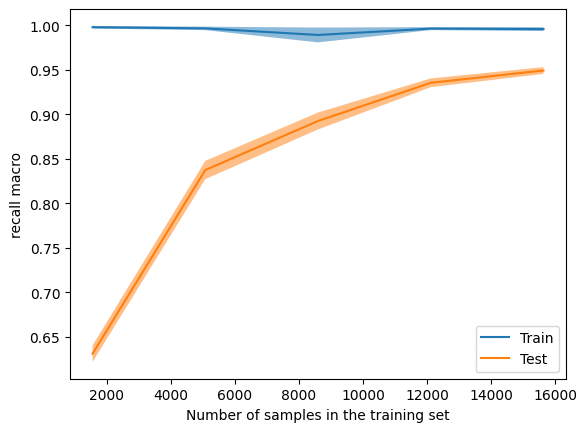

In [ ]:
learning_curve_mlp = LearningCurveDisplay.from_estimator(mlp_pipe_final, x_train, y_train, cv=skf, scoring='recall_macro', n_jobs=-1,
                                              random_state=73, score_name='recall macro', score_type='both', std_display_style='fill_between')